# Using non-traditional data to assess the public acceptability of reforms

Can we use non traditional data to assess the public acceptability of reforms? In this notebook, we study this research question focusing on the case study of the French pension reform. To make sense of the textual data, we leverage a framework developed by the OECD that identifies four dimensions of public acceptability: economy, fairness, risk and time, and process. For each dimension, we asked expert policy analysts to identify a lists of keywords which allows us to navigate the textual data and extract signal from them.

As X/Twitter data are not available anymore, we decided to focus on online media articles as the main data source. These documents are complemented by parliamentary speeches, which allow us to detect differences in the discourse about the reform in media and in the National Assembly.

In this notebook, we will:
- Train a Word2Vec model
- Obtain document embeddings computed as the centroid of the relative word-vectors
- Measure the IDF-weighted similarity between document embeddings and the four dimensions defined by the keywords
- Slice the set of documents to identify media articles and parliamentary speeches about the four dimensions
- Explore the media debate within each dimension with NMF topic modeling and appreciate the dynamics of the topic coverage with time series
- Compare media and parliamentary speeches with coupled matrix factorisation

In [1]:
import pandas as pd
import gensim
import numpy as np
from tqdm import tqdm
tqdm.pandas()

import spacy
nlp = spacy.load("fr_core_news_sm")
from spacy.lang.fr.stop_words import STOP_WORDS
import string 
from collections import Counter
from scipy import spatial

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

import matcouply.decomposition as decomposition
from matcouply.coupled_matrices import CoupledMatrixFactorization

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import plotly.graph_objs as go
import datetime

2024-04-27 14:45:47.758413: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-27 14:45:47.799575: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-27 14:45:47.799604: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-27 14:45:47.800990: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-27 14:45:47.808465: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructio

# Data prep

## Parliament

In [2]:
# Import data from session on retraite and speeches mentioning retraite
df_title_retraite = pd.read_csv('/home/sparazzoli/lagrange-oecd/data/Parliament/parl_corpus/parl_title_retraite.csv')
df_speech_retraite = pd.read_csv('/home/sparazzoli/lagrange-oecd/data/Parliament/parl_corpus/parl_speech_retraite.csv')

# Merge data from session on retraite and speeches mentioning retraite
df_parl = pd.concat([df_title_retraite, df_speech_retraite])
df_parl = df_parl.dropna(subset='speech').drop_duplicates(subset='speech')

# Filter speeches from November 2022 onwards
df_parl['dateSeance'] = pd.to_datetime(df_parl['dateSeance'], format='%Y%m%d%H%M%S%f')
df_parl = df_parl[df_parl['dateSeance'] >= pd.to_datetime('2022-11-01')]
df_parl.shape

(1395, 15)

In [3]:
# Preprocess data
stopwords = set(STOP_WORDS)
custom_sw_parl = {'réforme','retraite','retrait','oui','no','avis','mme','monsieur','parole','pouvoir','faire','devoir','bien',
                  'falloir','prendre','aller','bon','vouloir','bien','favorable','sous','remettre'}
stopwords.update(custom_sw_parl)

def lemmatizer(text):
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc]
    return lemmas

def whitespace_remover(tokens):
    filtered_tokens = [token for token in tokens if token.strip() != '']
    filtered_tokens_newline = [token for token in filtered_tokens if token != '\n\n']
    return filtered_tokens_newline
    
def sw_remover(tokens):
    filtered_tokens = [token for token in tokens if token.lower() not in stopwords]
    return filtered_tokens

def punct_remover(tokens):
    filtered_tokens = [token for token in tokens if not any(char in string.punctuation for char in token)] # I changed from all to any!!
    return filtered_tokens

def lowercaser(tokens):
    filtered_tokens = [token.lower() for token in tokens]
    return filtered_tokens

def joiner(tokens):
    joined_tokens = ' '.join(tokens)
    return joined_tokens

In [4]:
# Create a new column 'TextLemmatized'
df_parl['TextLemmatized'] = df_parl['speech'].progress_apply(lemmatizer)
df_parl['TextProcessed'] = df_parl['TextLemmatized'].progress_apply(whitespace_remover)
df_parl['TextProcessed'] = df_parl['TextProcessed'].progress_apply(sw_remover)
df_parl['TextProcessed'] = df_parl['TextProcessed'].progress_apply(punct_remover)
df_parl['TextProcessed'] = df_parl['TextProcessed'].progress_apply(lowercaser)
df_parl['TextProcessed'] = df_parl['TextProcessed'].progress_apply(joiner)

df_parl['TextProcessed']

100%|███████████████████████████████████| 1395/1395 [00:00<00:00, 197064.90it/s]


0       chose souhaiter rappeler solennellemer groupe ...
1       cadre semaine contrôle gouvernement groupe lfi...
2                        quell beau cravate rouge sourire
3       préambule aimerai prévenir amalgame rappeler p...
4       celer mois mouvement social opposer propos sal...
                              ...                        
1394    regretter oziol répondre réalité répondre poin...
1395    actuellement mettre contribution plateforme ac...
1396    matin subir tunnel interminable amendement ide...
1397    france insoumis mémoire court occasion crise s...
1398    triste spectacle cher collègue danièle obono e...
Name: TextProcessed, Length: 1395, dtype: object

In [5]:
df_parl_text = df_parl[['dateSeance','TextProcessed','speech']]
df_parl_text.rename(columns={"dateSeance": "Date", "TextProcessed": "TextProcessed", "speech":"Text"}, inplace = True)
df_parl_text['Source'] = 'Parliament'

/tmp/ipykernel_3621139/517243120.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_parl_text.rename(columns={"dateSeance": "Date", "TextProcessed": "TextProcessed", "speech":"Text"}, inplace = True)
/tmp/ipykernel_3621139/517243120.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_parl_text['Source'] = 'Parliament'


In [6]:
df_parl_text = df_parl_text[~df_parl_text['TextProcessed'].str.contains('orpea')]
df_parl_text.shape

(1392, 4)

## Media

In [7]:
# Import data
df_selectedmedia = pd.read_csv('/home/sparazzoli/lagrange-oecd/data/GDELT_221001_selectedmedia_Dec23.csv')
df_selectedmedia['DATE'] = pd.to_datetime(df_selectedmedia['DATE'])
df_selectedmedia['TextProcessed'] = df_selectedmedia['TextProcessed'].str.lower()
df_selectedmedia.shape

(10141, 12)

In [8]:
df_selectedmedia_text = df_selectedmedia[['DATE','TextProcessed','Text']]
df_selectedmedia_text.rename(columns={"DATE": "Date", "TextProcessed": "TextProcessed",'Text':'Text'}, inplace = True)
df_selectedmedia_text['Source'] = 'Media'

/tmp/ipykernel_3621139/4282530041.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selectedmedia_text.rename(columns={"DATE": "Date", "TextProcessed": "TextProcessed",'Text':'Text'}, inplace = True)
/tmp/ipykernel_3621139/4282530041.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selectedmedia_text['Source'] = 'Media'


In [9]:
df_selectedmedia_text = df_selectedmedia_text[~df_selectedmedia_text['TextProcessed'].str.contains('orpea')]
df_selectedmedia_text.shape

(10057, 4)

## Merge

In [10]:
df_merge = pd.concat([df_parl_text, df_selectedmedia_text])
df_merge

Date                                      TextProcessed  \
0     2023-05-03 15:00:00  chose souhaiter rappeler solennellemer groupe ...   
1     2023-05-03 15:00:00  cadre semaine contrôle gouvernement groupe lfi...   
2     2023-05-03 15:00:00                   quell beau cravate rouge sourire   
3     2023-05-03 15:00:00  préambule aimerai prévenir amalgame rappeler p...   
4     2023-05-03 15:00:00  celer mois mouvement social opposer propos sal...   
...                   ...                                                ...   
10136 2023-01-03 11:00:00  annonce douche froid partenaire social apprend...   
10137 2023-01-03 18:00:00  immobilier ancien retrouver phase atterrissage...   
10138 2023-03-18 15:45:00  paris reuters affrontement police lieu paris s...   
10139 2023-03-20 11:45:00  elizabeth pineau paris reuters gouvernement el...   
10140 2023-01-03 09:30:00  dernier round discussion partenaire social eli...   

                                                    Text      Source  
0      Avant toute chose, je souhaite rappeler solenn...  Parliament  
1      Dans le cadre de la semaine de contrôle du Gou...  Parliament  
2               Quelle belle cravate rouge ! (Sourires.)  Parliament  
3      En préambule, j’aimerais, pour prévenir tout a...  Parliament  
4      Cela fait quatre mois qu’un mouvement social s...  Parliament  
...                                                  ...         ...  
10136  L'annonce avait fait l'effet d'une douche froi...       Media  
10137  Le marché de l'immobilier ancien va retrouver ...       Media  
10138  PARIS (Reuters) - Des affrontements avec la po...       Media  
10139  par Elizabeth Pineau\n\nPARIS (Reuters) - Le g...       Media  
10140  Réforme des retraites : dernier round de discu...       Media  

[11449 rows x 4 columns]

# Similarity

## Word2Vec and centroids

In [11]:
documents = df_merge['Text'].astype(str).to_list()

documents_processed = df_merge['TextProcessed']
documents_processed = documents_processed.astype(str).to_list()

documents_tokenised = []
for doc in documents_processed:
  tokens = doc.split()
  documents_tokenised.append(tokens)

len(documents_tokenised)

11449

In [12]:
# Training Word2Vec model from the merged documents
model = gensim.models.Word2Vec(documents_tokenised, vector_size=100, window=5, min_count=1, workers=4)

In [13]:
document_centroids_in = []

for doc in documents_tokenised:

  document_vecs = []
  
  for word in doc:
    if word in model.wv:
      word_vec = model.wv[word]
      document_vecs.append(word_vec)
      
  if document_vecs: # I had to add this here because I obtained warning indicating there are some empty speech_vecs lists resulted in NaN when mean
      document_centroid = np.mean(document_vecs, axis=0)
      
  document_centroids_in.append(document_centroid)

## IDF

In [14]:
def calculate_idf(documents):
    
    N = len(documents)
    tD = Counter()

    # Count the number of documents that contain each term
    for document in documents:
        features = set(document.lower().split())
        for f in features:
            tD[f] += 1

    IDF = {}
    for term, term_frequency in tD.items():
        # Calculate the IDF for the term
        term_IDF = np.log(float(N) / term_frequency)
        IDF[term] = term_IDF

    return IDF

In [15]:
# Obtain the IDF values for each word in the vocabulary
voc_idf = calculate_idf(documents_processed)

## Weighted similarity

In [16]:
def keyword_sim_idfweight(keywords, doc_vecs, voc_idf):
    doc_scores = []

    for doc_vec in doc_vecs:
        keyword_sims = []
        total_weight = []

        for keyword in keywords:
            if keyword in model.wv:
                sim = 1 - spatial.distance.cosine(model.wv[keyword], doc_vec)
                idf_weight = voc_idf[keyword]                
                weighted_sim = sim * idf_weight
                
                keyword_sims.append(weighted_sim)
                total_weight.append(idf_weight)

        doc_score = sum(keyword_sims) / sum(total_weight)

        doc_scores.append(doc_score)

    return doc_scores

In [17]:
kws_econ_extended = ['compte public', 'finance', 'investissement', 'croissance', 'création emploi', 'compétitivité', 'soutenabilité', 'financement', 'pérennité', 'chômage', 'emploi', 'pib', 'prix', 'coût transition', 'incitation', 'espérance vie', 'départ anticipé', 'euro', 'contribution', 'productivité', 'dette', 'déficit', 'achat', 'démographique', 'attractivité', 'inflation', 'naissance', 'population', 'prime', 'travailleur', 'valeur', 'public', 'entreprise', 'banque', 'crise', 'cdc', 'industriel', 'territoire', 'fiscal', 'insee', 'revenu', 'cotisation', 'niveau', '62', 'argent', 'agriculture', 'industrie', 'totalenergie', 'cor', '64', 'actif', 'patrimoine', 'milliard', 'taux', 'cadre', 'travail', 'budget', 'direction', 'caisse', 'million', 'capital', 'salaire', 'pension', 'paiement', 'cotiser', 'facture', 'point', 'bourse', 'consommation', 'travailler', 'immobilier']
kws_fair_extended = ['gagnant', 'perdant', 'justice', 'morale', 'inégalité', 'riche', 'pauvre', 'pénibilité', 'carrière long', 'solidarité', 'décent', 'bonne santé', 'régime spécial', 'régime complémentaire', 'Agirc-Arrco', 'redistributif', 'femme', 'cotisation', 'équité', 'égalité', 'discrimination', 'privilège', 'richesse', 'classe sociale', 'précarité', '65', 'prime', 'fonctionnaire', 'public', 'mari', 'police', 'sncf', 'mixte', 'cheminots', 'niveau', 'edf', 'agriculture', 'industrie', 'ratp', 'fraude', 'jeunesse', 'totalenergie', 'usine', '64', 'marier', 'milliardaire', 'minimal', 'jeune', 'patrimoine', 'index', 'policier', 'taux', 'couple', 'cadre', 'plafond', 'homme', 'ouvrier', 'partage', 'social', 'capital', 'fortune', 'enseignant', 'smic', 'senior', 'agriculteur']
kws_risktime_extended = ['assurance', 'génération futur', 'génération', 'enfant', 'protection', 'mutualisation', 'myopie', 'déséquilibre', 'compréhension', 'ajustement automatique', 'ajustement', 'décote', 'bonus', 'malus', 'long terme', 'court terme', 'durabilité', 'vulnérabilité', 'incertitude', 'volatilité', 'futur', 'sécurité', 'aléas', 'imprévisibilité', 'imprévisible', 'scénario', 'jeune', 'climat', 'dette', '65', 'crise', 'cdc', 'vie', 'climatique', 'carbone', 'jeunesse', 'cor', 'soin', 'plan', 'index', 'temps', 'population', 'enfance', 'trimestre', 'naissance', 'ehpad']
kws_proc_extended = ['processus législatif', 'processus', 'vote', 'consultation', 'dialogue social', 'partenaire social', 'grève', 'manifestation', 'communication', 'confiance', 'polarisation', 'démocratie', '49', 'COR', 'période transition', 'motion censure', 'transparence', 'négociation', 'consensus', 'référendum', 'compromis', 'mobilisation', 'syndicat', 'liot', 'peuple', 'amendement', 'anti', 'populaire', 'crise', 'report', 'cgt', 'commission', 'police', 'intersyndicale', 'gauche', 'article', 'loi', 'leader', 'pause', 'examen', 'martinez', 'manifestant', 'motion', 'texte', 'dussopt', 'macron', 'projet', 'bloquer', 'borne', 'initiative', 'proposition', 'gouvernement', 'nupes', 'grenade', 'policier', 'censure', 'droit', 'rn', 'syndical', 'berger', 'obstruction', 'presse', 'mouvement', 'medef', 'crs', 'constitutionnel', 'lr', 'droite', 'force', 'ordre', 'bardella', 'accord', 'cnr', 'groupe', 'communiste', 'etat', 'riester', 'garde', 'rip', 'politique', 'dysfonctionnement', 'voter', 'journaliste', 'cfdt', 'revendication', 'retrait', 'juge', 'tribunal', 'maire', 'vert', 'violence']

economy_sims_weighted = keyword_sim_idfweight(kws_econ_extended, document_centroids_in, voc_idf)
fairness_sims_weighted = keyword_sim_idfweight(kws_fair_extended, document_centroids_in, voc_idf)
risktime_sims_weighted = keyword_sim_idfweight(kws_risktime_extended, document_centroids_in, voc_idf)
process_sims_weighted = keyword_sim_idfweight(kws_proc_extended, document_centroids_in, voc_idf)

In [18]:
sim_df = pd.DataFrame()

sim_df['economy_sim_weighted'] = economy_sims_weighted
sim_df['fairness_sim_weighted'] = fairness_sims_weighted
sim_df['risktime_sim_weighted'] = risktime_sims_weighted
sim_df['process_sim_weighted'] = process_sims_weighted

sim_df['article'] = documents
sim_df['article_processed'] = documents_processed
sim_df['Date'] = df_merge['Date'].values
sim_df['Source'] = df_merge['Source'].values

sim_df

economy_sim_weighted  fairness_sim_weighted  risktime_sim_weighted  \
0                  0.296723               0.372268               0.396682   
1                  0.222853               0.275428               0.264731   
2                  0.104313               0.226438               0.198963   
3                  0.239303               0.313710               0.333639   
4                  0.294988               0.348927               0.355471   
...                     ...                    ...                    ...   
11444              0.357763               0.344138               0.371933   
11445              0.526897               0.462229               0.539853   
11446              0.148913               0.205134               0.211013   
11447              0.195111               0.247560               0.265508   
11448              0.432275               0.363960               0.425409   

       process_sim_weighted  \
0                  0.446900   
1                  0.403763   
2                  0.211142   
3                  0.451802   
4                  0.416249   
...                     ...   
11444              0.366579   
11445              0.312749   
11446              0.379677   
11447              0.457159   
11448              0.261669   

                                                 article  \
0      Avant toute chose, je souhaite rappeler solenn...   
1      Dans le cadre de la semaine de contrôle du Gou...   
2               Quelle belle cravate rouge ! (Sourires.)   
3      En préambule, j’aimerais, pour prévenir tout a...   
4      Cela fait quatre mois qu’un mouvement social s...   
...                                                  ...   
11444  L'annonce avait fait l'effet d'une douche froi...   
11445  Le marché de l'immobilier ancien va retrouver ...   
11446  PARIS (Reuters) - Des affrontements avec la po...   
11447  par Elizabeth Pineau\n\nPARIS (Reuters) - Le g...   
11448  Réforme des retraites : dernier round de discu...   

                                       article_processed                Date  \
0      chose souhaiter rappeler solennellemer groupe ... 2023-05-03 15:00:00   
1      cadre semaine contrôle gouvernement groupe lfi... 2023-05-03 15:00:00   
2                       quell beau cravate rouge sourire 2023-05-03 15:00:00   
3      préambule aimerai prévenir amalgame rappeler p... 2023-05-03 15:00:00   
4      celer mois mouvement social opposer propos sal... 2023-05-03 15:00:00   
...                                                  ...                 ...   
11444  annonce douche froid partenaire social apprend... 2023-01-03 11:00:00   
11445  immobilier ancien retrouver phase atterrissage... 2023-01-03 18:00:00   
11446  paris reuters affrontement police lieu paris s... 2023-03-18 15:45:00   
11447  elizabeth pineau paris reuters gouvernement el... 2023-03-20 11:45:00   
11448  dernier round discussion partenaire social eli... 2023-01-03 09:30:00   

           Source  
0      Parliament  
1      Parliament  
2      Parliament  
3      Parliament  
4      Parliament  
...           ...  
11444       Media  
11445       Media  
11446       Media  
11447       Media  
11448       Media  

[11449 rows x 8 columns]

# Keyword count

In [19]:
def count_keywords(article, keywords):
  keyword_set = set(keywords)
  found_words = set()
  count = 0

  for word in article.split():
    if word in keyword_set:
      if word not in found_words:
        count += 1
        found_words.add(word)

  return count

In [20]:
sim_df['econ_count'] = 0
sim_df['fair_count'] = 0
sim_df['risktime_count'] = 0
sim_df['proc_count'] = 0

for index, row in sim_df.iterrows():
    sim_df.loc[index,'econ_count'] = count_keywords(row['article_processed'], kws_econ_extended)
    sim_df.loc[index,'fair_count'] = count_keywords(row['article_processed'], kws_fair_extended)
    sim_df.loc[index,'risktime_count'] = count_keywords(row['article_processed'], kws_risktime_extended)
    sim_df.loc[index,'proc_count'] = count_keywords(row['article_processed'], kws_proc_extended)

# Cutting the corpora

## Plots

In [21]:
sim_df_media = sim_df[sim_df['Source'] == 'Media']
sim_df_parl = sim_df[sim_df['Source'] == 'Parliament']
print(f'The shape of `sim_df_media` is {sim_df_media.shape} and the shape of `sim_df_parl is {sim_df_parl.shape}`')

The shape of `sim_df_media` is (10057, 12) and the shape of `sim_df_parl is (1392, 12)`


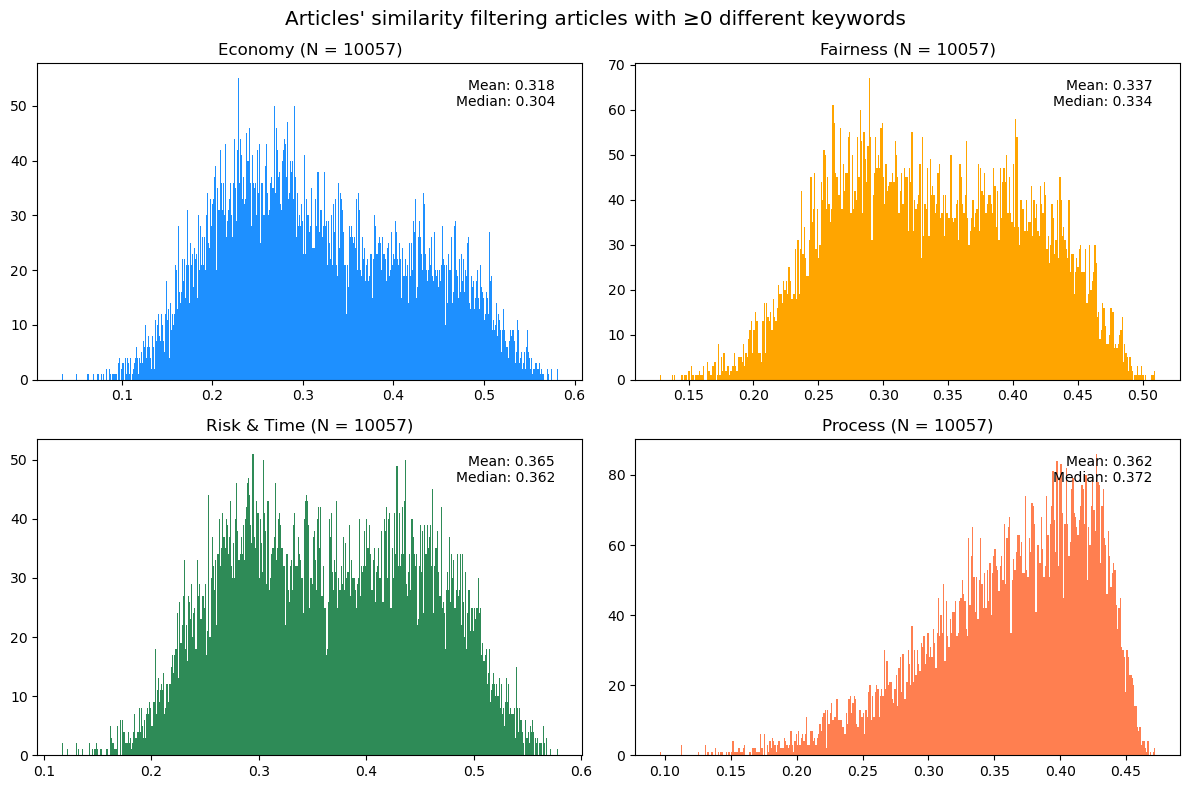

In [22]:
# Filtering on the number of keyword matches
filter_threshold = 0

# Sort for economy subplot
sim_df_economy = sim_df_media[sim_df_media['econ_count'] >= filter_threshold]
sim_df_fairness = sim_df_media[sim_df_media['fair_count'] >= filter_threshold]
sim_df_risktime = sim_df_media[sim_df_media['risktime_count'] >= filter_threshold]
sim_df_process = sim_df_media[sim_df_media['proc_count'] >= filter_threshold]
sim_df
fig, axs = plt.subplots(2, 2, figsize=(12,8))

axs[0,0].hist(sim_df_economy['economy_sim_weighted'], bins=np.arange(min(sim_df_economy['economy_sim_weighted']), max(sim_df_economy['economy_sim_weighted']) + 0.001, 0.001), color='dodgerblue')
axs[0,1].hist(sim_df_fairness['fairness_sim_weighted'], bins=np.arange(min(sim_df_fairness['fairness_sim_weighted']), max(sim_df_fairness['fairness_sim_weighted']) + 0.001, 0.001), color='orange')  
axs[1,0].hist(sim_df_risktime['risktime_sim_weighted'], bins=np.arange(min(sim_df_risktime['risktime_sim_weighted']), max(sim_df_risktime['risktime_sim_weighted']) + 0.001, 0.001), color='seagreen')
axs[1,1].hist(sim_df_process['process_sim_weighted'], bins=np.arange(min(sim_df_process['process_sim_weighted']), max(sim_df_process['process_sim_weighted']) + 0.001, 0.001), color='coral')

# Add titles to each subplot
axs[0, 0].set_title(f'Economy (N = {len(sim_df_economy)})')
axs[0, 1].set_title(f'Fairness (N = {len(sim_df_fairness)})')
axs[1, 0].set_title(f'Risk & Time (N = {len(sim_df_risktime)})')
axs[1, 1].set_title(f'Process (N = {len(sim_df_process)})')

# Add info about stats
economy_mean = np.mean(sim_df_economy['economy_sim_weighted'])
economy_median = np.median(sim_df_economy['economy_sim_weighted'])
axs[0,0].text(0.95, 0.95, f'Mean: {economy_mean:.3f}\nMedian: {economy_median:.3f}', horizontalalignment='right', verticalalignment='top', transform=axs[0,0].transAxes)

fairness_mean = np.mean(sim_df_fairness['fairness_sim_weighted'])
fairness_median = np.median(sim_df_fairness['fairness_sim_weighted'])
axs[0,1].text(0.95, 0.95, f'Mean: {fairness_mean:.3f}\nMedian: {fairness_median:.3f}', horizontalalignment='right', verticalalignment='top', transform=axs[0,1].transAxes)

risktime_mean = np.mean(sim_df_risktime['risktime_sim_weighted'])
risktime_median = np.median(sim_df_risktime['risktime_sim_weighted'])
axs[1,0].text(0.95, 0.95, f'Mean: {risktime_mean:.3f}\nMedian: {risktime_median:.3f}', horizontalalignment='right', verticalalignment='top', transform=axs[1,0].transAxes)

process_mean = np.mean(sim_df_process['process_sim_weighted'])
process_median = np.median(sim_df_process['process_sim_weighted'])
axs[1,1].text(0.95, 0.95, f'Mean: {process_mean:.3f}\nMedian: {process_median:.3f}', horizontalalignment='right', verticalalignment='top', transform=axs[1,1].transAxes)

# Add a general title to the figure
fig.suptitle(f"Articles' similarity filtering articles with ≥{filter_threshold} different keywords", size='x-large')

plt.tight_layout()
plt.show()

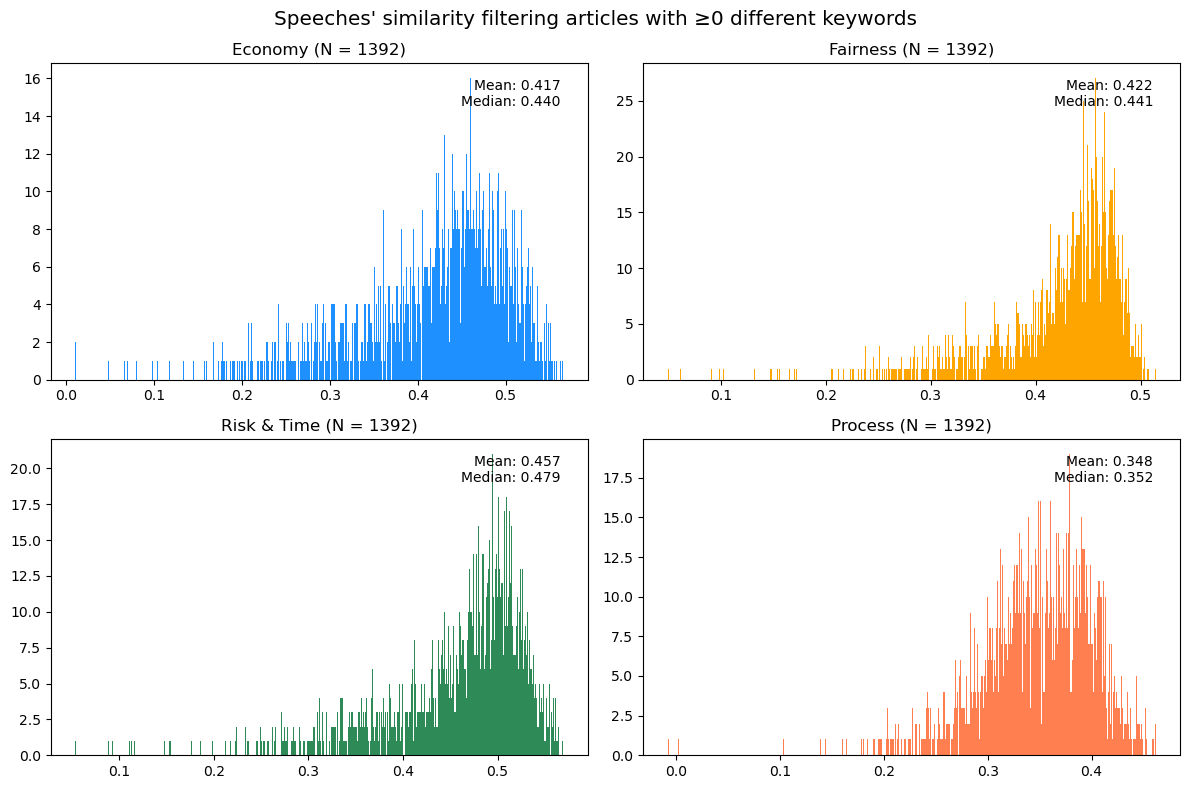

In [23]:
# Filtering on the number of keyword matches
filter_threshold = 0

# Sort for economy subplot
sim_df_economy = sim_df_parl[sim_df_parl['econ_count'] >= filter_threshold]
sim_df_fairness = sim_df_parl[sim_df_parl['fair_count'] >= filter_threshold]
sim_df_risktime = sim_df_parl[sim_df_parl['risktime_count'] >= filter_threshold]
sim_df_process = sim_df_parl[sim_df_parl['proc_count'] >= filter_threshold]
sim_df
fig, axs = plt.subplots(2, 2, figsize=(12,8))

axs[0,0].hist(sim_df_economy['economy_sim_weighted'], bins=np.arange(min(sim_df_economy['economy_sim_weighted']), max(sim_df_economy['economy_sim_weighted']) + 0.001, 0.001), color='dodgerblue')
axs[0,1].hist(sim_df_fairness['fairness_sim_weighted'], bins=np.arange(min(sim_df_fairness['fairness_sim_weighted']), max(sim_df_fairness['fairness_sim_weighted']) + 0.001, 0.001), color='orange')  
axs[1,0].hist(sim_df_risktime['risktime_sim_weighted'], bins=np.arange(min(sim_df_risktime['risktime_sim_weighted']), max(sim_df_risktime['risktime_sim_weighted']) + 0.001, 0.001), color='seagreen')
axs[1,1].hist(sim_df_process['process_sim_weighted'], bins=np.arange(min(sim_df_process['process_sim_weighted']), max(sim_df_process['process_sim_weighted']) + 0.001, 0.001), color='coral')

# Add titles to each subplot
axs[0, 0].set_title(f'Economy (N = {len(sim_df_economy)})')
axs[0, 1].set_title(f'Fairness (N = {len(sim_df_fairness)})')
axs[1, 0].set_title(f'Risk & Time (N = {len(sim_df_risktime)})')
axs[1, 1].set_title(f'Process (N = {len(sim_df_process)})')

# Add info about stats
economy_mean = np.mean(sim_df_economy['economy_sim_weighted'])
economy_median = np.median(sim_df_economy['economy_sim_weighted'])
axs[0,0].text(0.95, 0.95, f'Mean: {economy_mean:.3f}\nMedian: {economy_median:.3f}', horizontalalignment='right', verticalalignment='top', transform=axs[0,0].transAxes)

fairness_mean = np.mean(sim_df_fairness['fairness_sim_weighted'])
fairness_median = np.median(sim_df_fairness['fairness_sim_weighted'])
axs[0,1].text(0.95, 0.95, f'Mean: {fairness_mean:.3f}\nMedian: {fairness_median:.3f}', horizontalalignment='right', verticalalignment='top', transform=axs[0,1].transAxes)

risktime_mean = np.mean(sim_df_risktime['risktime_sim_weighted'])
risktime_median = np.median(sim_df_risktime['risktime_sim_weighted'])
axs[1,0].text(0.95, 0.95, f'Mean: {risktime_mean:.3f}\nMedian: {risktime_median:.3f}', horizontalalignment='right', verticalalignment='top', transform=axs[1,0].transAxes)

process_mean = np.mean(sim_df_process['process_sim_weighted'])
process_median = np.median(sim_df_process['process_sim_weighted'])
axs[1,1].text(0.95, 0.95, f'Mean: {process_mean:.3f}\nMedian: {process_median:.3f}', horizontalalignment='right', verticalalignment='top', transform=axs[1,1].transAxes)

# Add a general title to the figure
fig.suptitle(f"Speeches' similarity filtering articles with ≥{filter_threshold} different keywords", size='x-large')

plt.tight_layout()
plt.show()

## Min-max normalisation

### Media

In [24]:
# Normalize the distributions
sim_df_media_economy_norm = sim_df_media.copy()
sim_df_media_fairness_norm = sim_df_media.copy()
sim_df_media_risktime_norm = sim_df_media.copy()
sim_df_media_process_norm = sim_df_media.copy()

sim_df_media_economy_norm['economy_sim_weighted'] = (sim_df_media_economy_norm['economy_sim_weighted'] - sim_df_media_economy_norm['economy_sim_weighted'].min()) / (sim_df_media_economy_norm['economy_sim_weighted'].max() - sim_df_media_economy_norm['economy_sim_weighted'].min())
sim_df_media_fairness_norm['fairness_sim_weighted'] = (sim_df_media_fairness_norm['fairness_sim_weighted'] - sim_df_media_fairness_norm['fairness_sim_weighted'].min()) / (sim_df_media_fairness_norm['fairness_sim_weighted'].max() - sim_df_media_fairness_norm['fairness_sim_weighted'].min())
sim_df_media_risktime_norm['risktime_sim_weighted'] = (sim_df_media_risktime_norm['risktime_sim_weighted'] - sim_df_media_risktime_norm['risktime_sim_weighted'].min()) / (sim_df_media_risktime_norm['risktime_sim_weighted'].max() - sim_df_media_risktime_norm['risktime_sim_weighted'].min())
sim_df_media_process_norm['process_sim_weighted'] = (sim_df_media_process_norm['process_sim_weighted'] - sim_df_media_process_norm['process_sim_weighted'].min()) / (sim_df_media_process_norm['process_sim_weighted'].max() - sim_df_media_process_norm['process_sim_weighted'].min())

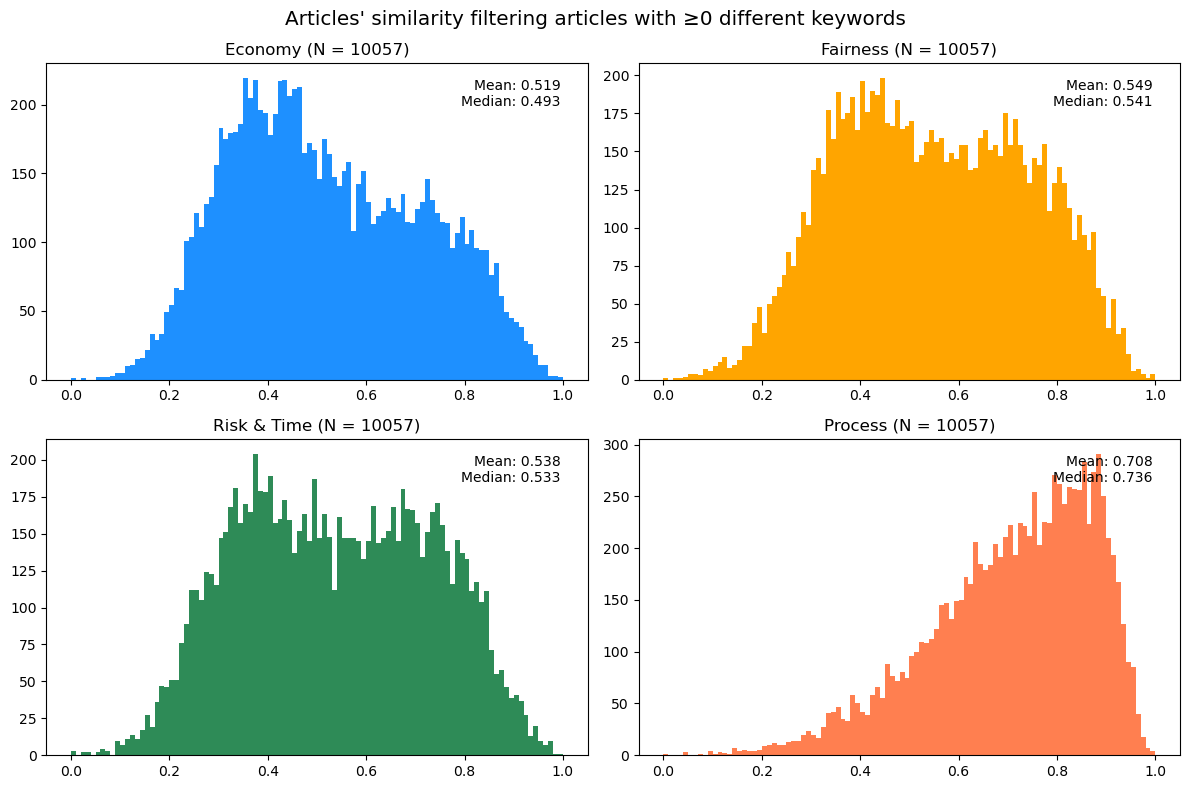

In [25]:
# Filtering on the number of keyword matches
filter_threshold = 0

# Sort for economy subplot
sim_df_economy = sim_df_media_economy_norm[sim_df_media_economy_norm['econ_count'] >= filter_threshold]
sim_df_fairness = sim_df_media_fairness_norm[sim_df_media_fairness_norm['fair_count'] >= filter_threshold]
sim_df_risktime = sim_df_media_risktime_norm[sim_df_media_risktime_norm['risktime_count'] >= filter_threshold]
sim_df_process = sim_df_media_process_norm[sim_df_media_process_norm['proc_count'] >= filter_threshold]

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

axs[0, 0].hist(sim_df_economy['economy_sim_weighted'], bins=np.linspace(0, 1, 101), color='dodgerblue')
axs[0, 1].hist(sim_df_fairness['fairness_sim_weighted'], bins=np.linspace(0, 1, 101), color='orange')
axs[1, 0].hist(sim_df_risktime['risktime_sim_weighted'], bins=np.linspace(0, 1, 101), color='seagreen')
axs[1, 1].hist(sim_df_process['process_sim_weighted'], bins=np.linspace(0, 1, 101), color='coral')

# Add titles to each subplot
axs[0, 0].set_title(f'Economy (N = {len(sim_df_economy)})')
axs[0, 1].set_title(f'Fairness (N = {len(sim_df_fairness)})')
axs[1, 0].set_title(f'Risk & Time (N = {len(sim_df_risktime)})')
axs[1, 1].set_title(f'Process (N = {len(sim_df_process)})')

# Add info about stats
economy_mean = np.mean(sim_df_economy['economy_sim_weighted'])
economy_median = np.median(sim_df_economy['economy_sim_weighted'])
axs[0, 0].text(0.95, 0.95, f'Mean: {economy_mean:.3f}\nMedian: {economy_median:.3f}', horizontalalignment='right', verticalalignment='top', transform=axs[0, 0].transAxes)

fairness_mean = np.mean(sim_df_fairness['fairness_sim_weighted'])
fairness_median = np.median(sim_df_fairness['fairness_sim_weighted'])
axs[0, 1].text(0.95, 0.95, f'Mean: {fairness_mean:.3f}\nMedian: {fairness_median:.3f}', horizontalalignment='right', verticalalignment='top', transform=axs[0, 1].transAxes)

risktime_mean = np.mean(sim_df_risktime['risktime_sim_weighted'])
risktime_median = np.median(sim_df_risktime['risktime_sim_weighted'])
axs[1, 0].text(0.95, 0.95, f'Mean: {risktime_mean:.3f}\nMedian: {risktime_median:.3f}', horizontalalignment='right', verticalalignment='top', transform=axs[1, 0].transAxes)

process_mean = np.mean(sim_df_process['process_sim_weighted'])
process_median = np.median(sim_df_process['process_sim_weighted'])
axs[1, 1].text(0.95, 0.95, f'Mean: {process_mean:.3f}\nMedian: {process_median:.3f}', horizontalalignment='right', verticalalignment='top', transform=axs[1, 1].transAxes)

# Add a general title to the figure
fig.suptitle(f"Articles' similarity filtering articles with ≥{filter_threshold} different keywords", size='x-large')

plt.tight_layout()
plt.show()

### Parliament

In [26]:
# Normalize the distributions
sim_df_parl_economy_norm = sim_df_parl.copy()
sim_df_parl_fairness_norm = sim_df_parl.copy()
sim_df_parl_risktime_norm = sim_df_parl.copy()
sim_df_parl_process_norm = sim_df_parl.copy()

sim_df_parl_economy_norm['economy_sim_weighted'] = (sim_df_parl_economy_norm['economy_sim_weighted'] - sim_df_parl_economy_norm['economy_sim_weighted'].min()) / (sim_df_parl_economy_norm['economy_sim_weighted'].max() - sim_df_parl_economy_norm['economy_sim_weighted'].min())
sim_df_parl_fairness_norm['fairness_sim_weighted'] = (sim_df_parl_fairness_norm['fairness_sim_weighted'] - sim_df_parl_fairness_norm['fairness_sim_weighted'].min()) / (sim_df_parl_fairness_norm['fairness_sim_weighted'].max() - sim_df_parl_fairness_norm['fairness_sim_weighted'].min())
sim_df_parl_risktime_norm['risktime_sim_weighted'] = (sim_df_parl_risktime_norm['risktime_sim_weighted'] - sim_df_parl_risktime_norm['risktime_sim_weighted'].min()) / (sim_df_parl_risktime_norm['risktime_sim_weighted'].max() - sim_df_parl_risktime_norm['risktime_sim_weighted'].min())
sim_df_parl_process_norm['process_sim_weighted'] = (sim_df_parl_process_norm['process_sim_weighted'] - sim_df_parl_process_norm['process_sim_weighted'].min()) / (sim_df_parl_process_norm['process_sim_weighted'].max() - sim_df_parl_process_norm['process_sim_weighted'].min())

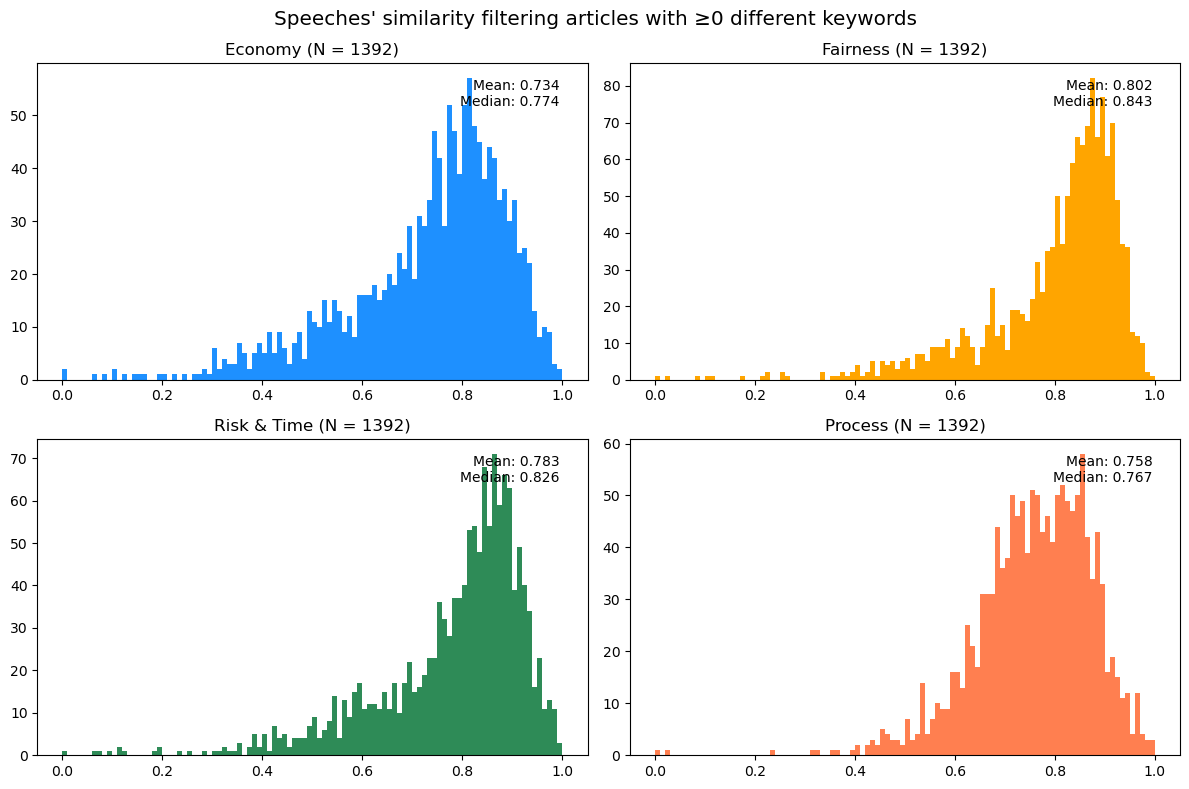

In [27]:
# Filtering on the number of keyword matches
filter_threshold = 0

# Sort for economy subplot
sim_df_economy = sim_df_parl_economy_norm[sim_df_parl_economy_norm['econ_count'] >= filter_threshold]
sim_df_fairness = sim_df_parl_fairness_norm[sim_df_parl_fairness_norm['fair_count'] >= filter_threshold]
sim_df_risktime = sim_df_parl_risktime_norm[sim_df_parl_risktime_norm['risktime_count'] >= filter_threshold]
sim_df_process = sim_df_parl_process_norm[sim_df_parl_process_norm['proc_count'] >= filter_threshold]

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

axs[0, 0].hist(sim_df_economy['economy_sim_weighted'], bins=np.linspace(0, 1, 101), color='dodgerblue')
axs[0, 1].hist(sim_df_fairness['fairness_sim_weighted'], bins=np.linspace(0, 1, 101), color='orange')
axs[1, 0].hist(sim_df_risktime['risktime_sim_weighted'], bins=np.linspace(0, 1, 101), color='seagreen')
axs[1, 1].hist(sim_df_process['process_sim_weighted'], bins=np.linspace(0, 1, 101), color='coral')

# Add titles to each subplot
axs[0, 0].set_title(f'Economy (N = {len(sim_df_economy)})')
axs[0, 1].set_title(f'Fairness (N = {len(sim_df_fairness)})')
axs[1, 0].set_title(f'Risk & Time (N = {len(sim_df_risktime)})')
axs[1, 1].set_title(f'Process (N = {len(sim_df_process)})')

# Add info about stats
economy_mean = np.mean(sim_df_economy['economy_sim_weighted'])
economy_median = np.median(sim_df_economy['economy_sim_weighted'])
axs[0, 0].text(0.95, 0.95, f'Mean: {economy_mean:.3f}\nMedian: {economy_median:.3f}', horizontalalignment='right', verticalalignment='top', transform=axs[0, 0].transAxes)

fairness_mean = np.mean(sim_df_fairness['fairness_sim_weighted'])
fairness_median = np.median(sim_df_fairness['fairness_sim_weighted'])
axs[0, 1].text(0.95, 0.95, f'Mean: {fairness_mean:.3f}\nMedian: {fairness_median:.3f}', horizontalalignment='right', verticalalignment='top', transform=axs[0, 1].transAxes)

risktime_mean = np.mean(sim_df_risktime['risktime_sim_weighted'])
risktime_median = np.median(sim_df_risktime['risktime_sim_weighted'])
axs[1, 0].text(0.95, 0.95, f'Mean: {risktime_mean:.3f}\nMedian: {risktime_median:.3f}', horizontalalignment='right', verticalalignment='top', transform=axs[1, 0].transAxes)

process_mean = np.mean(sim_df_process['process_sim_weighted'])
process_median = np.median(sim_df_process['process_sim_weighted'])
axs[1, 1].text(0.95, 0.95, f'Mean: {process_mean:.3f}\nMedian: {process_median:.3f}', horizontalalignment='right', verticalalignment='top', transform=axs[1, 1].transAxes)

# Add a general title to the figure
fig.suptitle(f"Speeches' similarity filtering articles with ≥{filter_threshold} different keywords", size='x-large')

plt.tight_layout()
plt.show()

## Slicing

In [28]:
# Filtering on common similarity threshold
shared_sim_threshold = 0.9

# Sort for economy subplot
top_economy_parl = sim_df_parl_economy_norm[sim_df_parl_economy_norm['economy_sim_weighted'] >= shared_sim_threshold]
top_fairness_parl = sim_df_parl_fairness_norm[sim_df_parl_fairness_norm['fairness_sim_weighted'] >= shared_sim_threshold]
top_risktime_parl = sim_df_parl_risktime_norm[sim_df_parl_risktime_norm['risktime_sim_weighted'] >= shared_sim_threshold]
top_process_parl = sim_df_parl_process_norm[sim_df_parl_process_norm['process_sim_weighted'] >= shared_sim_threshold]

# Prepare the four corpora
corpus_economy_parl = top_economy_parl['article_processed']
corpus_fairness_parl = top_fairness_parl['article_processed']
corpus_risktime_parl = top_risktime_parl['article_processed']
corpus_process_parl = top_process_parl['article_processed']

print('The number of PARLIAMENTARY SPEECHES for each corpus is:' +
      '\n - Economic dimension: ' + str(len(corpus_economy_parl)) +
      '\n - Fairness dimension: ' + str(len(corpus_fairness_parl)) +
      '\n - Risk & Time dimension: ' + str(len(corpus_risktime_parl)) +
      '\n - Process dimension: ' + str(len(corpus_process_parl)))

The number of PARLIAMENTARY SPEECHES for each corpus is:
 - Economic dimension: 150
 - Fairness dimension: 291
 - Risk & Time dimension: 239
 - Process dimension: 99


In [29]:
# Sort for economy subplot
top_economy_media = sim_df_media_economy_norm[sim_df_media_economy_norm['economy_sim_weighted'] >= shared_sim_threshold]
top_fairness_media = sim_df_media_fairness_norm[sim_df_media_fairness_norm['fairness_sim_weighted'] >= shared_sim_threshold]
top_risktime_media = sim_df_media_risktime_norm[sim_df_media_risktime_norm['risktime_sim_weighted'] >= shared_sim_threshold]
top_process_media = sim_df_media_process_norm[sim_df_media_process_norm['process_sim_weighted'] >= shared_sim_threshold]

# Prepare the four corpora
corpus_economy_media = top_economy_media['article_processed']
corpus_fairness_media = top_fairness_media['article_processed']
corpus_risktime_media = top_risktime_media['article_processed']
corpus_process_media = top_process_media['article_processed']

print('The number of MEDIA ARTICLES for each corpus is:' +
      '\n - Economic dimension: ' + str(len(corpus_economy_media)) +
      '\n - Fairness dimension: ' + str(len(corpus_fairness_media)) +
      '\n - Risk & Time dimension: ' + str(len(corpus_risktime_media)) +
      '\n - Process dimension: ' + str(len(corpus_process_media)))

The number of MEDIA ARTICLES for each corpus is:
 - Economic dimension: 182
 - Fairness dimension: 190
 - Risk & Time dimension: 167
 - Process dimension: 941


# Time series

In [30]:
econ_media_weekly = top_economy_media.resample('W', on='Date').count()
fair_media_weekly = top_fairness_media.resample('W', on='Date').count()
risk_media_weekly = top_risktime_media.resample('W', on='Date').count()
proc_media_weekly = top_process_media.resample('W', on='Date').count()

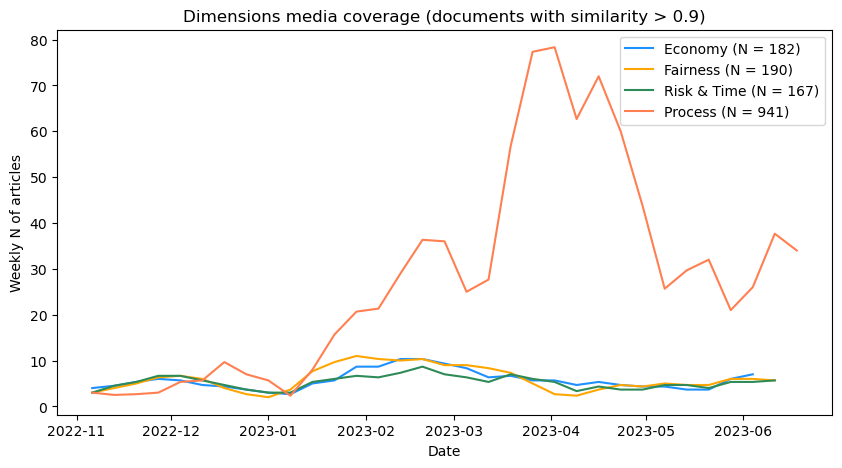

In [31]:
# Create a new figure with subplots
fig, ax = plt.subplots(figsize=(10, 5))

# Plot dimensions' data
ax.plot(econ_media_weekly.index, econ_media_weekly['Source'].rolling(3, min_periods=0).mean(), label=f'Economy (N = {len(top_economy_media)})', color='dodgerblue')
ax.plot(fair_media_weekly.index, fair_media_weekly['Source'].rolling(3, min_periods=0).mean(), label=f'Fairness (N = {len(top_fairness_media)})', color='orange')
ax.plot(risk_media_weekly.index, risk_media_weekly['Source'].rolling(3, min_periods=0).mean(), label=f'Risk & Time (N = {len(top_risktime_media)})', color='seagreen')
ax.plot(proc_media_weekly.index, proc_media_weekly['Source'].rolling(3, min_periods=0).mean(), label=f'Process (N = {len(top_process_media)})', color='coral')

# Set axis labels and title
ax.set_xlabel('Date')
ax.set_ylabel(f'Weekly N of articles')
ax.set_title(f'Dimensions media coverage (documents with similarity > {shared_sim_threshold})')

# Show legend
ax.legend()

plt.show()


In [32]:
econ_parl_weekly = top_economy_parl.resample('W', on='Date').count()
fair_parl_weekly = top_fairness_parl.resample('W', on='Date').count()
risk_parl_weekly = top_risktime_parl.resample('W', on='Date').count()
proc_parl_weekly = top_process_parl.resample('W', on='Date').count()

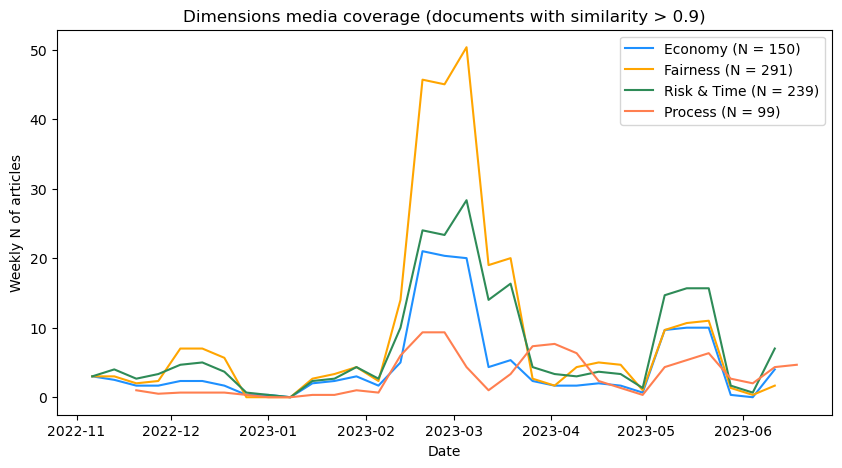

In [33]:
# Create a new figure with subplots
fig, ax = plt.subplots(figsize=(10, 5))

# Plot dimensions' data
ax.plot(econ_parl_weekly.index, econ_parl_weekly['Source'].rolling(3, min_periods=0).mean(), label=f'Economy (N = {len(top_economy_parl)})', color='dodgerblue')
ax.plot(fair_parl_weekly.index, fair_parl_weekly['Source'].rolling(3, min_periods=0).mean(), label=f'Fairness (N = {len(top_fairness_parl)})', color='orange')
ax.plot(risk_parl_weekly.index, risk_parl_weekly['Source'].rolling(3, min_periods=0).mean(), label=f'Risk & Time (N = {len(top_risktime_parl)})', color='seagreen')
ax.plot(proc_parl_weekly.index, proc_parl_weekly['Source'].rolling(3, min_periods=0).mean(), label=f'Process (N = {len(top_process_parl)})', color='coral')

# Set axis labels and title
ax.set_xlabel('Date')
ax.set_ylabel(f'Weekly N of articles')
ax.set_title(f'Dimensions media coverage (documents with similarity > {shared_sim_threshold})')

# Show legend
ax.legend()

plt.show()

## Normalisation by number of articles published each unit of time

In [34]:
# Resample to obtain time series
econ_media_source = top_economy_media.resample('W', on='Date').count()['Source']
fair_media_source = top_fairness_media.resample('W', on='Date').count()['Source']
risk_media_source = top_risktime_media.resample('W', on='Date').count()['Source']
proc_media_source = top_process_media.resample('W', on='Date').count()['Source']

documents_media_daily = sim_df_media.resample('W', on='Date').count()['Source']

In [35]:
# Concatenate the extracted columns along columns axis
weekly_data_media = pd.concat([documents_media_daily, econ_media_source, fair_media_source, risk_media_source, proc_media_source], axis=1)
weekly_data_media.columns = ['N_Documents', 'Economy', 'Fairness', 'RiskTime', 'Process']
weekly_data_media.fillna(0, inplace=True)

In [36]:
# Divide each dimension's time series by the total N of docs published on that unit of time
weekly_data_media['Economy_norm'] = weekly_data_media['Economy'] / weekly_data_media['N_Documents']
weekly_data_media['Fairness_norm'] = weekly_data_media['Fairness'] / weekly_data_media['N_Documents']
weekly_data_media['RiskTime_norm'] = weekly_data_media['RiskTime'] / weekly_data_media['N_Documents']
weekly_data_media['Process_norm'] = weekly_data_media['Process'] / weekly_data_media['N_Documents']

weekly_data_media.fillna(0, inplace=True)
weekly_data_media.head()

N_Documents  Economy  Fairness  RiskTime  Process  Economy_norm  \
Date                                                                          
2022-11-06           59      4.0       3.0       3.0        3      0.067797   
2022-11-13          118      5.0       5.0       6.0        2      0.042373   
2022-11-20          111      7.0       7.0       7.0        3      0.063063   
2022-11-27          105      6.0       7.0       7.0        4      0.057143   
2022-12-04          136      4.0       6.0       6.0        9      0.029412   

            Fairness_norm  RiskTime_norm  Process_norm  
Date                                                    
2022-11-06       0.050847       0.050847      0.050847  
2022-11-13       0.042373       0.050847      0.016949  
2022-11-20       0.063063       0.063063      0.027027  
2022-11-27       0.066667       0.066667      0.038095  
2022-12-04       0.044118       0.044118      0.066176

In [37]:
# Cut the last week because we don't have reliable data
weekly_data_media_cut = weekly_data_media.iloc[:-1]

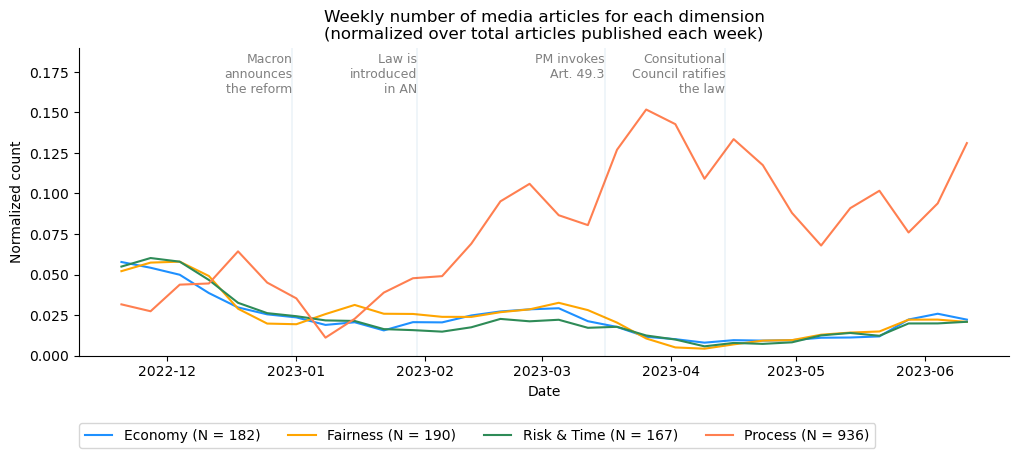

In [38]:
# Define important dates 
important_dates = {
    datetime.datetime(2022, 12, 31): 'Macron\nannounces\nthe reform',
    datetime.datetime(2023, 1, 30): 'Law is\nintroduced\nin AN',
    datetime.datetime(2023, 3, 16): 'PM invokes\nArt. 49.3',
    datetime.datetime(2023, 4, 14): 'Consitutional\nCouncil ratifies\nthe law',
}

# Plot the normalized time series
plt.figure(figsize=(12, 4))
ax = plt.gca()  # Get the current Axes instance

plt.plot(weekly_data_media_cut.index, weekly_data_media_cut['Economy_norm'].rolling(3).mean(), label=f"Economy (N = {int(sum(weekly_data_media_cut['Economy']))})", color='dodgerblue')
plt.plot(weekly_data_media_cut.index, weekly_data_media_cut['Fairness_norm'].rolling(3).mean(), label=f"Fairness (N = {int(sum(weekly_data_media_cut['Fairness']))})", color='orange')
plt.plot(weekly_data_media_cut.index, weekly_data_media_cut['RiskTime_norm'].rolling(3).mean(), label=f"Risk & Time (N = {int(sum(weekly_data_media_cut['RiskTime']))})", color='seagreen')
plt.plot(weekly_data_media_cut.index, weekly_data_media_cut['Process_norm'].rolling(3).mean(), label=f"Process (N = {int(sum(weekly_data_media_cut['Process']))})", color='coral') 

plt.xlabel('Date')
plt.ylabel('Normalized count')
plt.ylim(0, 0.19)
plt.title('Weekly number of media articles for each dimension\n(normalized over total articles published each week)')
ax.legend(loc=(0,-0.3), ncol=4)

# Remove top and right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add vertical lines and annotations
for date, description in important_dates.items():
    plt.axvline(x=date, linewidth=0.1)  # Add vertical line
    plt.text(date, plt.ylim()[1] - 0.003, description, rotation=0, va='top', ha='right', fontsize=9, color='grey')

plt.show()

In [39]:
# Resample to obtain time series
econ_parl_source = top_economy_parl.resample('W', on='Date').count()['Source']
fair_parl_source = top_fairness_parl.resample('W', on='Date').count()['Source']
risk_parl_source = top_risktime_parl.resample('W', on='Date').count()['Source']
proc_parl_source = top_process_parl.resample('W', on='Date').count()['Source']

documents_parl_daily = sim_df_parl.resample('W', on='Date').count()['Source']

In [40]:
# Concatenate the extracted columns along columns axis
weekly_data_parl = pd.concat([documents_parl_daily, econ_parl_source, fair_parl_source, risk_parl_source, proc_parl_source], axis=1)
weekly_data_parl.columns = ['N_Documents', 'Economy', 'Fairness', 'RiskTime', 'Process']
weekly_data_parl.fillna(0, inplace=True)

In [41]:
# Divide each dimension's time series by the total N of docs published on that unit of time
weekly_data_parl['Economy_norm'] = weekly_data_parl['Economy'] / weekly_data_parl['N_Documents']
weekly_data_parl['Fairness_norm'] = weekly_data_parl['Fairness'] / weekly_data_parl['N_Documents']
weekly_data_parl['RiskTime_norm'] = weekly_data_parl['RiskTime'] / weekly_data_parl['N_Documents']
weekly_data_parl['Process_norm'] = weekly_data_parl['Process'] / weekly_data_parl['N_Documents']

weekly_data_parl.fillna(0, inplace=True)
weekly_data_parl.head()

N_Documents  Economy  Fairness  RiskTime  Process  Economy_norm  \
Date                                                                          
2022-11-06            5      3.0       3.0       3.0      0.0      0.600000   
2022-11-13           10      2.0       3.0       5.0      0.0      0.200000   
2022-11-20           13      0.0       0.0       0.0      1.0      0.000000   
2022-11-27           12      3.0       4.0       5.0      0.0      0.250000   
2022-12-04           36      4.0      17.0       9.0      1.0      0.111111   

            Fairness_norm  RiskTime_norm  Process_norm  
Date                                                    
2022-11-06       0.600000       0.600000      0.000000  
2022-11-13       0.300000       0.500000      0.000000  
2022-11-20       0.000000       0.000000      0.076923  
2022-11-27       0.333333       0.416667      0.000000  
2022-12-04       0.472222       0.250000      0.027778

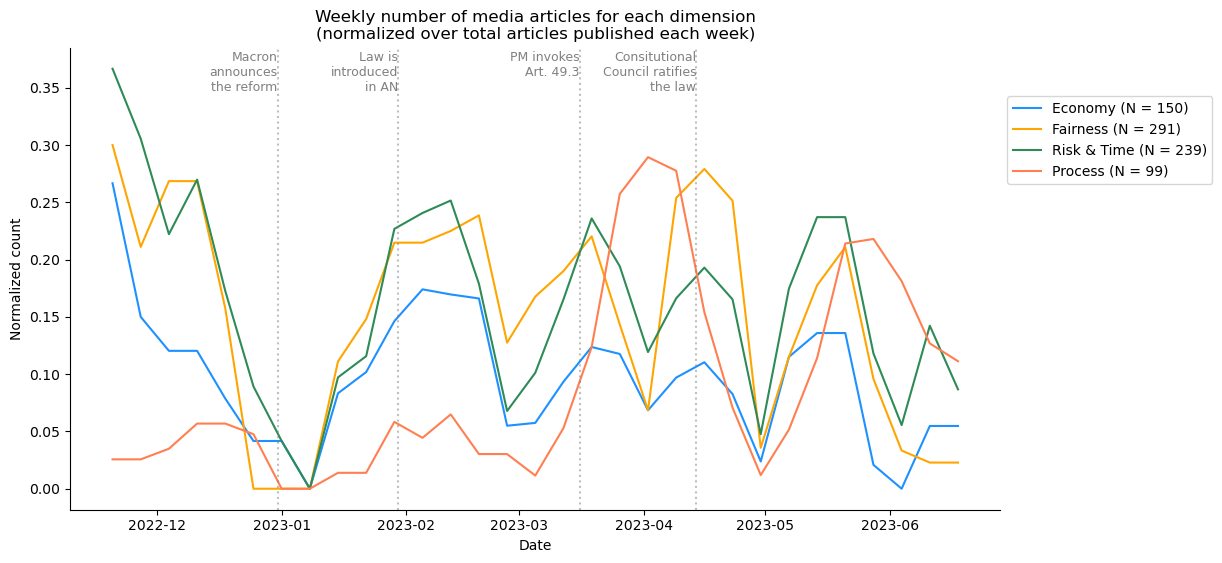

In [42]:
# Plot the normalized time series
plt.figure(figsize=(12, 6))
ax = plt.gca()  # Get the current Axes instance

plt.plot(weekly_data_parl.index, weekly_data_parl['Economy_norm'].rolling(3).mean(), label=f"Economy (N = {int(sum(weekly_data_parl['Economy']))})", color='dodgerblue')
plt.plot(weekly_data_parl.index, weekly_data_parl['Fairness_norm'].rolling(3).mean(), label=f"Fairness (N = {int(sum(weekly_data_parl['Fairness']))})", color='orange')
plt.plot(weekly_data_parl.index, weekly_data_parl['RiskTime_norm'].rolling(3).mean(), label=f"Risk & Time (N = {int(sum(weekly_data_parl['RiskTime']))})", color='seagreen')
plt.plot(weekly_data_parl.index, weekly_data_parl['Process_norm'].rolling(3).mean(), label=f"Process (N = {int(sum(weekly_data_parl['Process']))})", color='coral')

plt.xlabel('Date')
plt.ylabel('Normalized count')
#plt.ylim(0, 0.5)
plt.title('Weekly number of media articles for each dimension\n(normalized over total articles published each week)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.8))

# Remove top and right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add vertical lines and annotations
for date, description in important_dates.items():
    plt.axvline(x=date, color='gray', linestyle=':', alpha=0.5)  # Add vertical line
    plt.text(date, plt.ylim()[1] - 0.003, description, rotation=0, va='top', ha='right', fontsize=9, color='grey')

plt.show()

# Topic modeling

## Media

### Economy

In [43]:
# Initialize variables which will be used later
n_features = 5000
n_components = 10 
n_top_words = 15 

In [44]:
# Create the TF-IDF matrix
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.95, min_df=5,  
    max_features=n_features, 
    ngram_range=(1, 1))

tfidf_economy = tfidf_vectorizer.fit_transform(corpus_economy_media)

In [45]:
# Perform NMF
seed = 42
nmf_economy = NMF(n_components=n_components,
                  random_state=seed, 
                  alpha_W=0, # Constant that multiplies the regularization terms of W. Set it to zero (default) to have no regularization on W
                  l1_ratio=0, # The regularization mixing parameter 0-1. l1_ratio = 0, penalty is an elementwise L2 penalty (aka Frobenius Norm). For l1_ratio = 1 it is an elementwise L1 penalty. For 0 < l1_ratio < 1, the penalty is a combination of L1 and L2.
                  max_iter=1000,
                  init='random'
                  ).fit(tfidf_economy)

In [46]:
def plot_top_words(model, feature_names, n_top_words, title, name, n_topics, n_seed):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.9)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=50)

    plt.subplots_adjust(top=0.87, bottom=0.05, wspace=0.7, hspace=0.2)
    #plt.savefig('./figures/'+str(name)+'_topics'+str(n_topics)+'_seed'+str(n_seed)+'.png')
    plt.show()

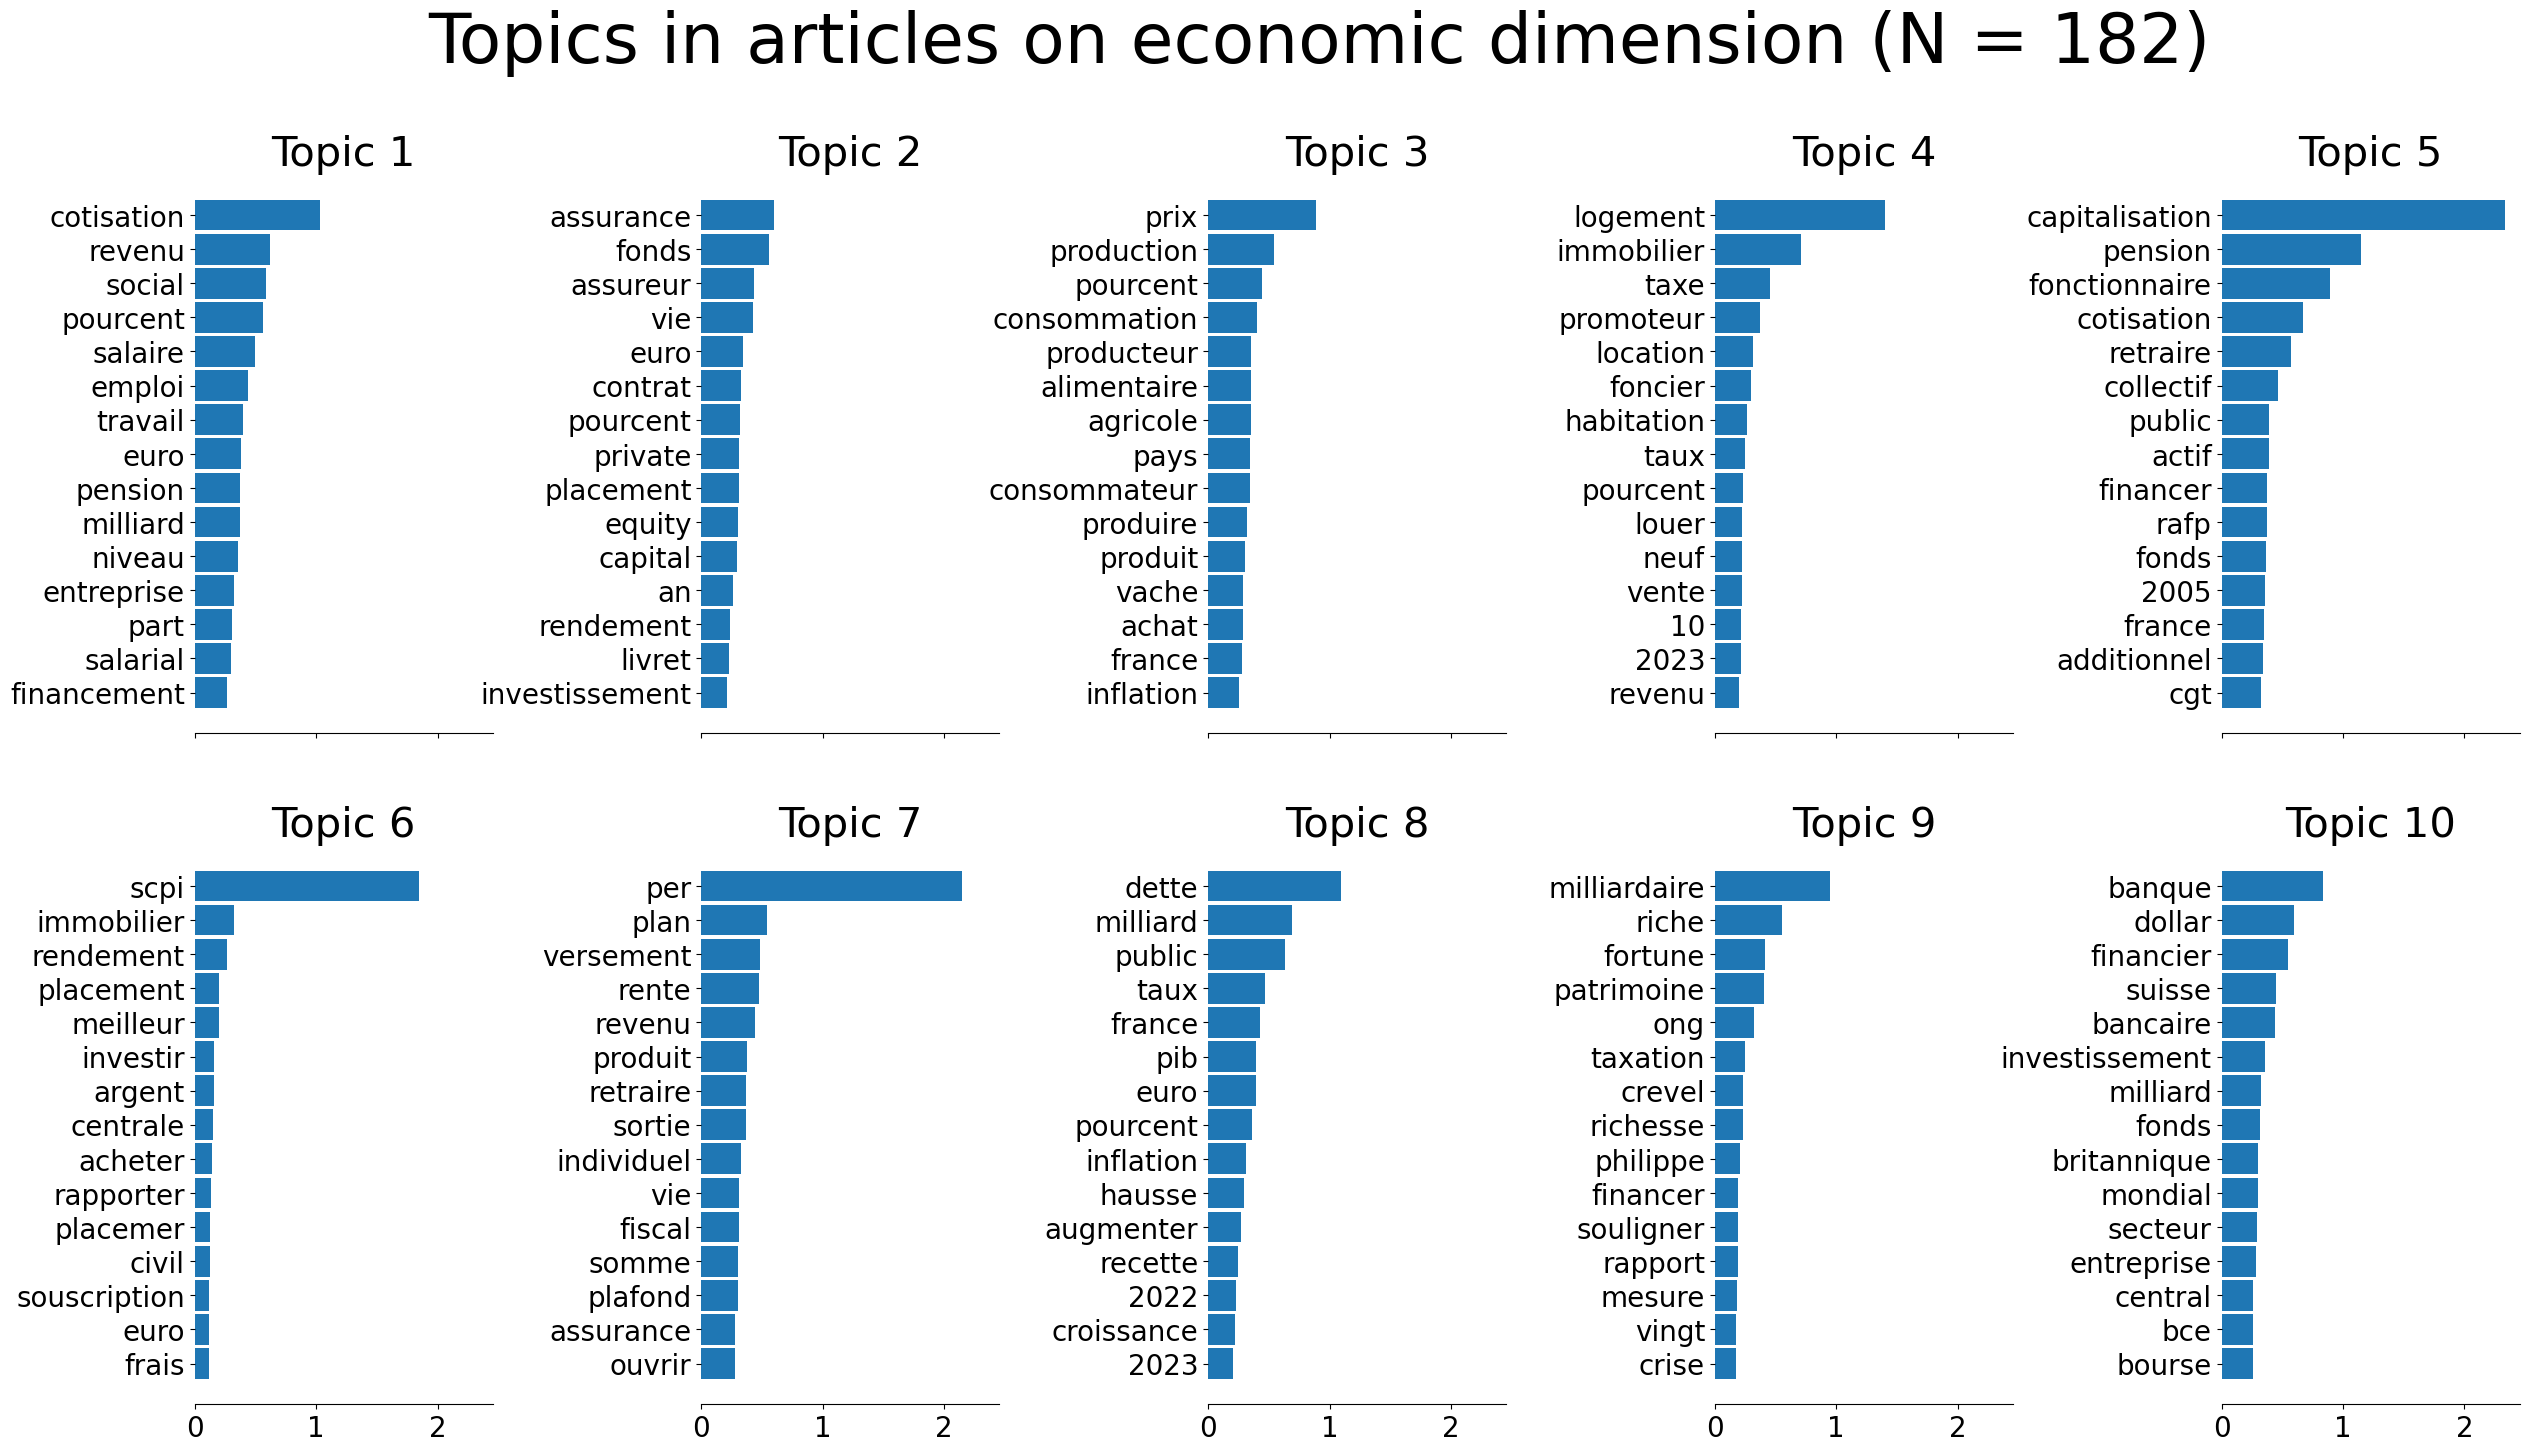

In [47]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

plot_top_words(
    nmf_economy, tfidf_feature_names, n_top_words, f"Topics in articles on economic dimension (N = {len(corpus_economy_media)})", 'scikit_selmedia_nofiltSW', n_components, seed)

In [48]:
# Get the feature names from the vectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()

# Get the top 3 indices for each topic
top_indices = nmf_economy.components_.argsort()[:,-5:]

# Create empty list to store top words  
top_words_economy = []

# Loop through each topic
for topic in top_indices:
  
  # Extract top 3 words
  top_3 = [feature_names[i] for i in topic]
  
  # Add to list
  top_words_economy.extend(top_3)

In [49]:
# Get the document-topic matrix
doc_topic_matrix = nmf_economy.transform(tfidf_economy)

# Calculate topic frequencies across corpus
topic_freqs = doc_topic_matrix.sum(axis=0) 

# Get top 3 words for each topic
top_word_indices = nmf_economy.components_.argsort()[:, -3:]
top_words = [[tfidf_feature_names[i] for i in topic[::-1]] for topic in top_word_indices]
top_words = [' '.join(words) for words in top_words]

# Combine topics and top words
topics_with_words = list(zip(topic_freqs, top_words))

# Sort by frequency
sorted_topics = sorted(topics_with_words, key=lambda x: x[0], reverse=False)

# Extract sorted freqs and topic names  
sorted_freqs, sorted_top_words = zip(*sorted_topics)

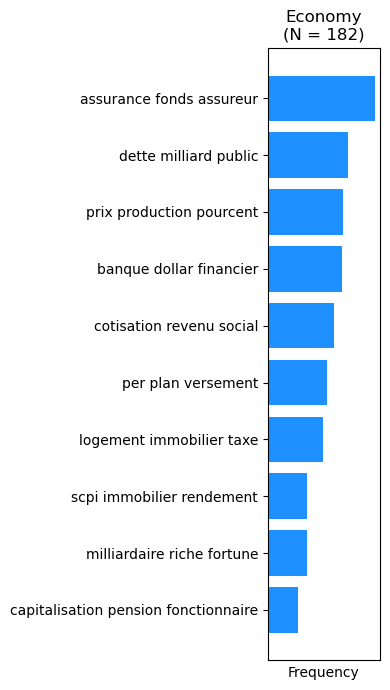

In [50]:
# Plot sorted topics and freqs  
fig, ax = plt.subplots(figsize=(4, 7)) 

# Plot horizontal bars
ax.barh(range(n_components), sorted_freqs, color='dodgerblue')

# Set y-ticks and labels
ax.set_yticks(range(n_components)) 
ax.set_yticklabels(sorted_top_words)

# Remove x-axis tick labels  
ax.set_xticks([]) 

# Axis labels
ax.set_xlabel("Frequency")

# Title and tight layout
ax.set_title(f"Economy\n(N = {len(doc_topic_matrix)})")
plt.tight_layout()
plt.show()

In [51]:
w_df = pd.DataFrame(doc_topic_matrix)
w_df.columns = top_words
w_df.shape

(182, 10)

In [52]:
w_df_date = w_df.copy()
w_df_date['Date'] = top_economy_media['Date'].values

# Convert 'Date' column to datetime and set it as the index
w_df_date['Date'] = pd.to_datetime(w_df_date['Date'])
w_df_date.set_index('Date', inplace=True)

# Resample at weekly level
w_df_date = w_df_date.resample('W').sum()

Text(0.5, 1.0, 'Topic evolution over time in media articles about the economic dimension (N = 182)')

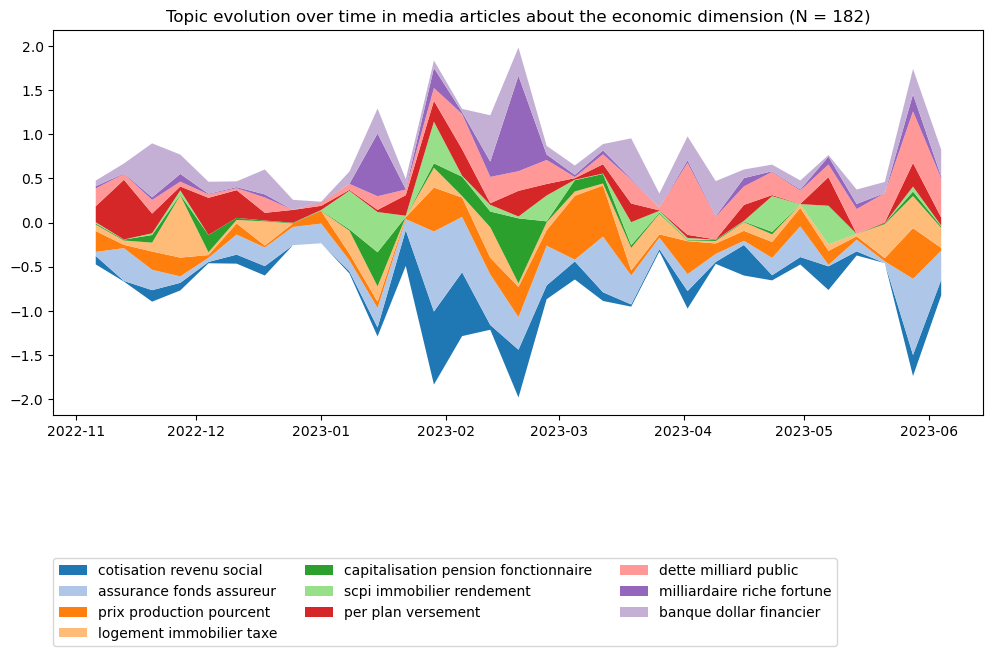

In [53]:
colors = sns.color_palette("tab20")

fig, ax = plt.subplots(figsize=(12,5))

# Plot a stackplot
ax.stackplot(w_df_date.index, w_df_date.T, baseline='sym', labels=w_df_date.columns, colors=colors)

# Move the legend off of the chart
ax.legend(loc=(0,-0.6), ncol=3)

plt.title(f'Topic evolution over time in media articles about the economic dimension (N = {len(w_df)})')

In [54]:
# Divide each value of the time series by the total weight across all topics
w_df_date_norm = w_df_date.copy()
w_df_date_norm['weekly_weight_sum'] = w_df_date_norm.apply(np.sum, axis=1)
w_df_date_norm.iloc[:, :-1] = w_df_date_norm.iloc[:, :-1].div(w_df_date_norm['weekly_weight_sum'], axis=0)

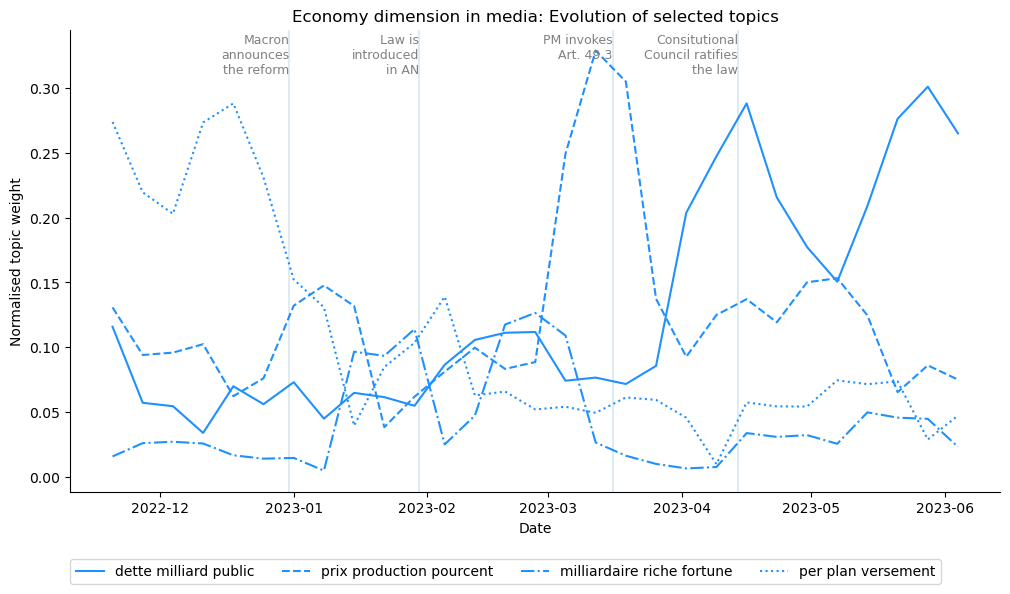

In [55]:
selected_columns = [
    "dette milliard public",
    "prix production pourcent",
    "milliardaire riche fortune",
    "per plan versement",
]

# Define line styles
line_styles = ['-', '--', '-.', ':']

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Loop through each selected column, apply rolling average to normalized data, and plot the smoothed time series
for i, column in enumerate(selected_columns):
    smoothed_series = w_df_date_norm[column].rolling(window=3).mean()
    ax.plot(w_df_date.index, smoothed_series, label=f'{column}', color='dodgerblue', linestyle=line_styles[i])

# Set the labels and legend
ax.set_xlabel('Date')
ax.set_ylabel('Normalised topic weight')
ax.set_title(f'Economy dimension in media: Evolution of selected topics')
ax.legend(loc=(0,-0.2), ncol=4)

plt.xticks(rotation=0)

# Remove top and right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add vertical lines and annotations
for date, description in important_dates.items():
    plt.axvline(x=date, linewidth=0.2)  # Add vertical line
    plt.text(date, plt.ylim()[1] - 0.003, description, rotation=0, va='top', ha='right', fontsize=9, color='grey')

# Display the plot
plt.show()

### Fairness

In [56]:
# Create the TF-IDF matrix
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.95, min_df=5,  
    max_features=n_features, 
    ngram_range=(1, 1))

tfidf_fairness = tfidf_vectorizer.fit_transform(corpus_fairness_media)

In [57]:
# Perform NMF
seed = 42
nmf_fairness = NMF(n_components=n_components,
                  random_state=seed, # Pass an int for reproducible results across multiple function calls.
                  alpha_W=0, # Constant that multiplies the regularization terms of W. Set it to zero (default) to have no regularization on W
                  l1_ratio=0, # The regularization mixing parameter 0-1. l1_ratio = 0, penalty is an elementwise L2 penalty (aka Frobenius Norm). For l1_ratio = 1 it is an elementwise L1 penalty. For 0 < l1_ratio < 1, the penalty is a combination of L1 and L2.
                  max_iter=1000,
                  init='random'
                  ).fit(tfidf_fairness)

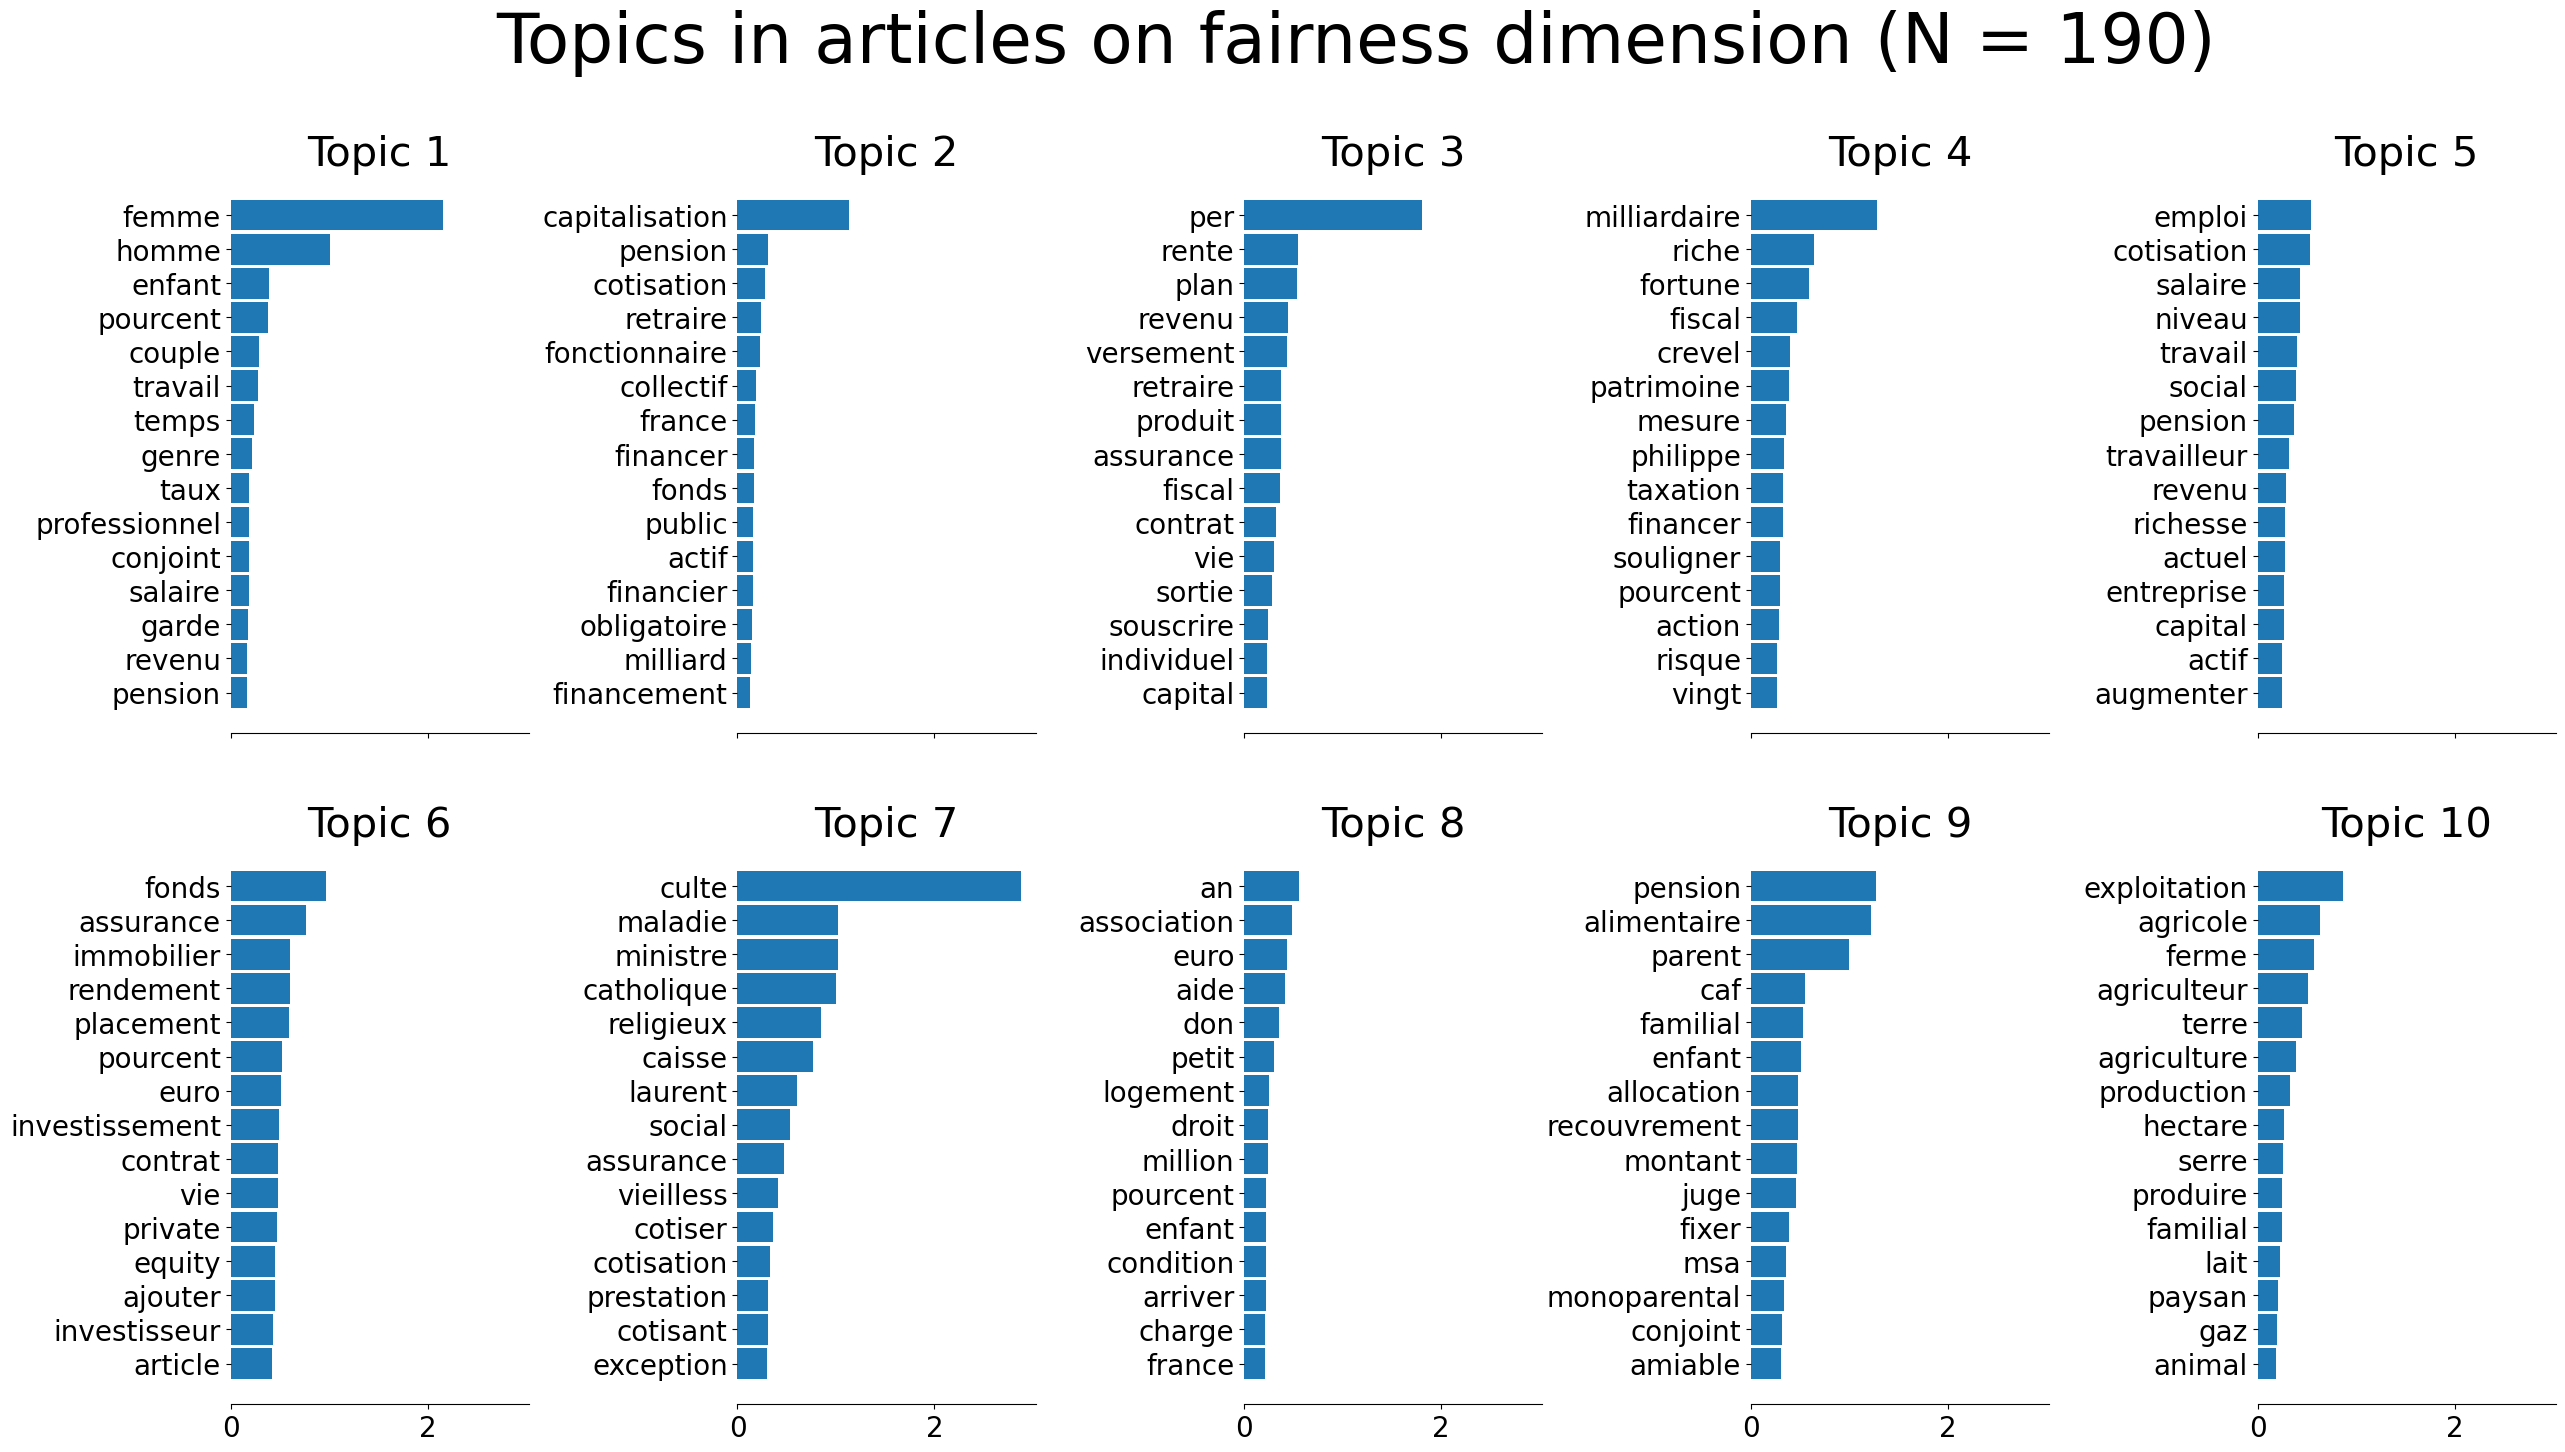

In [58]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

plot_top_words(
    nmf_fairness, tfidf_feature_names, n_top_words, f"Topics in articles on fairness dimension (N = {len(corpus_fairness_media)})", 'scikit_selmedia_nofiltSW', n_components, seed)

In [59]:
# Get the feature names from the vectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()

# Get the top 3 indices for each topic
top_indices = nmf_fairness.components_.argsort()[:,-5:]

# Create empty list to store top words  
top_words_fairness = []

# Loop through each topic
for topic in top_indices:
  
  # Extract top 3 words
  top_3 = [feature_names[i] for i in topic]
  
  # Add to list
  top_words_fairness.extend(top_3)

In [60]:
# Get the document-topic matrix
doc_topic_matrix = nmf_fairness.transform(tfidf_fairness)

# Calculate topic frequencies across corpus
topic_freqs = doc_topic_matrix.sum(axis=0) 

# Get top 3 words for each topic
top_word_indices = nmf_fairness.components_.argsort()[:, -3:]
top_words = [[tfidf_feature_names[i] for i in topic[::-1]] for topic in top_word_indices]
top_words = [' '.join(words) for words in top_words]

# Combine topics and top words
topics_with_words = list(zip(topic_freqs, top_words))

# Sort by frequency
sorted_topics = sorted(topics_with_words, key=lambda x: x[0], reverse=False)

# Extract sorted freqs and topic names  
sorted_freqs, sorted_top_words = zip(*sorted_topics)

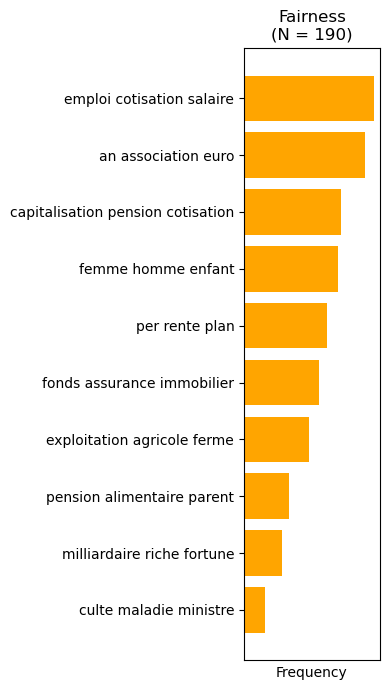

In [61]:
# Plot sorted topics and freqs  
fig, ax = plt.subplots(figsize=(4, 7)) 

# Plot horizontal bars
ax.barh(range(n_components), sorted_freqs, color='orange')

# Set y-ticks and labels
ax.set_yticks(range(n_components)) 
ax.set_yticklabels(sorted_top_words)

# Remove x-axis tick labels  
ax.set_xticks([]) 

# Axis labels
ax.set_xlabel("Frequency")

# Title and tight layout
ax.set_title(f"Fairness\n(N = {len(doc_topic_matrix)})")
plt.tight_layout()
plt.show()

In [62]:
w_df = pd.DataFrame(doc_topic_matrix)
w_df.columns = top_words
w_df.shape

(190, 10)

In [63]:
w_df_date = w_df.copy()
w_df_date['Date'] = top_fairness_media['Date'].values

# Convert 'Date' column to datetime and set it as the index
w_df_date['Date'] = pd.to_datetime(w_df_date['Date'])
w_df_date.set_index('Date', inplace=True)

# Resample at weekly level
w_df_date = w_df_date.resample('W').sum()

Text(0.5, 1.0, 'Topic evolution over time in media articles about the fairness dimension (N = 190)')

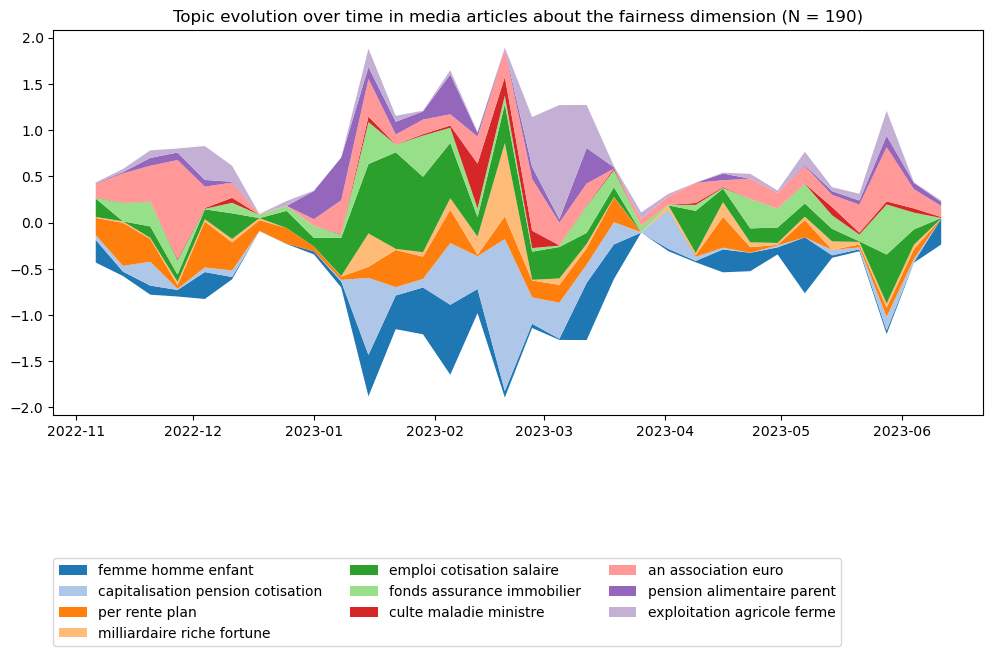

In [64]:
fig, ax = plt.subplots(figsize=(12,5))

# Plot a stackplot
ax.stackplot(w_df_date.index, w_df_date.T, baseline='sym', labels=w_df_date.columns, colors=colors)

# Move the legend off of the chart
ax.legend(loc=(0,-0.6), ncol=3)

plt.title(f'Topic evolution over time in media articles about the fairness dimension (N = {len(w_df)})')

In [65]:
# Divide each value of the time series by the total weight across all topics
w_df_date_norm = w_df_date.copy()
w_df_date_norm['weekly_weight_sum'] = w_df_date_norm.apply(np.sum, axis=1)
w_df_date_norm.iloc[:, :-1] = w_df_date_norm.iloc[:, :-1].div(w_df_date_norm['weekly_weight_sum'], axis=0)

w_df_date_norm.fillna(0, inplace=True)

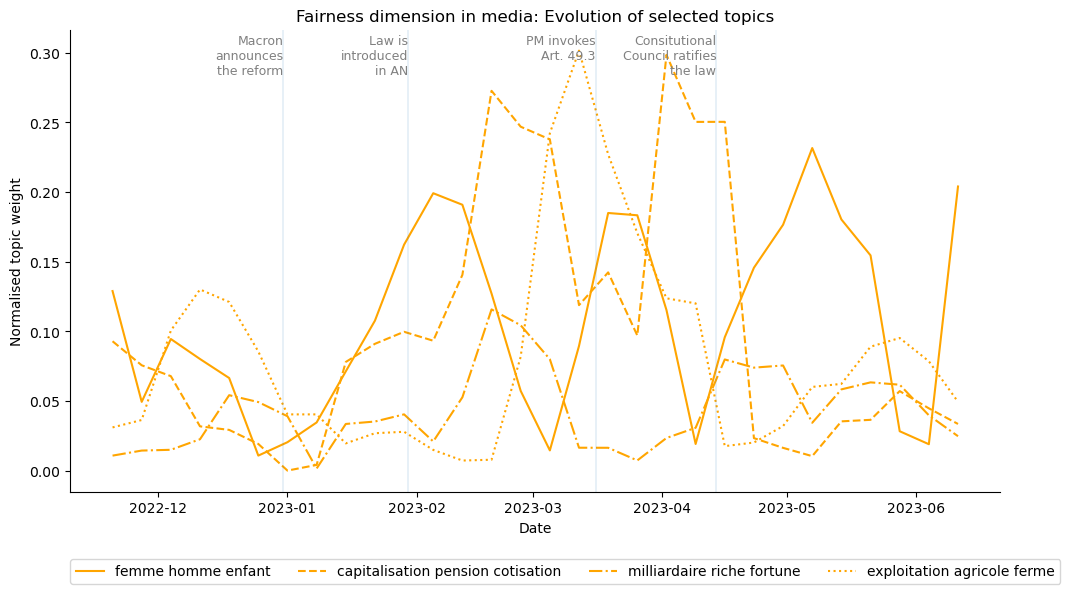

In [70]:
selected_columns = [
    "femme homme enfant",
    "capitalisation pension cotisation",
    "milliardaire riche fortune",
    "exploitation agricole ferme",
]

# Define line styles
line_styles = ['-', '--', '-.', ':']

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Loop through each selected column, apply rolling average to normalized data, and plot the smoothed time series
for i, column in enumerate(selected_columns):
    smoothed_series = w_df_date_norm[column].rolling(window=3).mean()
    ax.plot(w_df_date.index, smoothed_series, label=f'{column}', color='orange', linestyle=line_styles[i])

# Set the labels and legend
ax.set_xlabel('Date')
ax.set_ylabel('Normalised topic weight')
ax.set_title(f'Fairness dimension in media: Evolution of selected topics')
ax.legend(loc=(0,-0.2), ncol=4)

plt.xticks(rotation=0)

# Remove top and right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add vertical lines and annotations
for date, description in important_dates.items():
    plt.axvline(x=date, linewidth=.3, alpha=0.5)  # Add vertical line
    plt.text(date, plt.ylim()[1] - 0.003, description, rotation=0, va='top', ha='right', fontsize=9, color='grey')

# Display the plot
plt.show()

### Risk & Time

In [71]:
# Create the TF-IDF matrix
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.95, min_df=5,  
    max_features=n_features, 
    ngram_range=(1, 1))

tfidf_risktime = tfidf_vectorizer.fit_transform(corpus_risktime_media)

In [72]:
# Perform NMF
seed = 42
nmf_risktime = NMF(n_components=n_components,
                  random_state=seed, # Pass an int for reproducible results across multiple function calls.
                  alpha_W=0, # Constant that multiplies the regularization terms of W. Set it to zero (default) to have no regularization on W
                  l1_ratio=0, # The regularization mixing parameter 0-1. l1_ratio = 0, penalty is an elementwise L2 penalty (aka Frobenius Norm). For l1_ratio = 1 it is an elementwise L1 penalty. For 0 < l1_ratio < 1, the penalty is a combination of L1 and L2.
                  max_iter=1000,
                  init='random'
                  ).fit(tfidf_risktime)

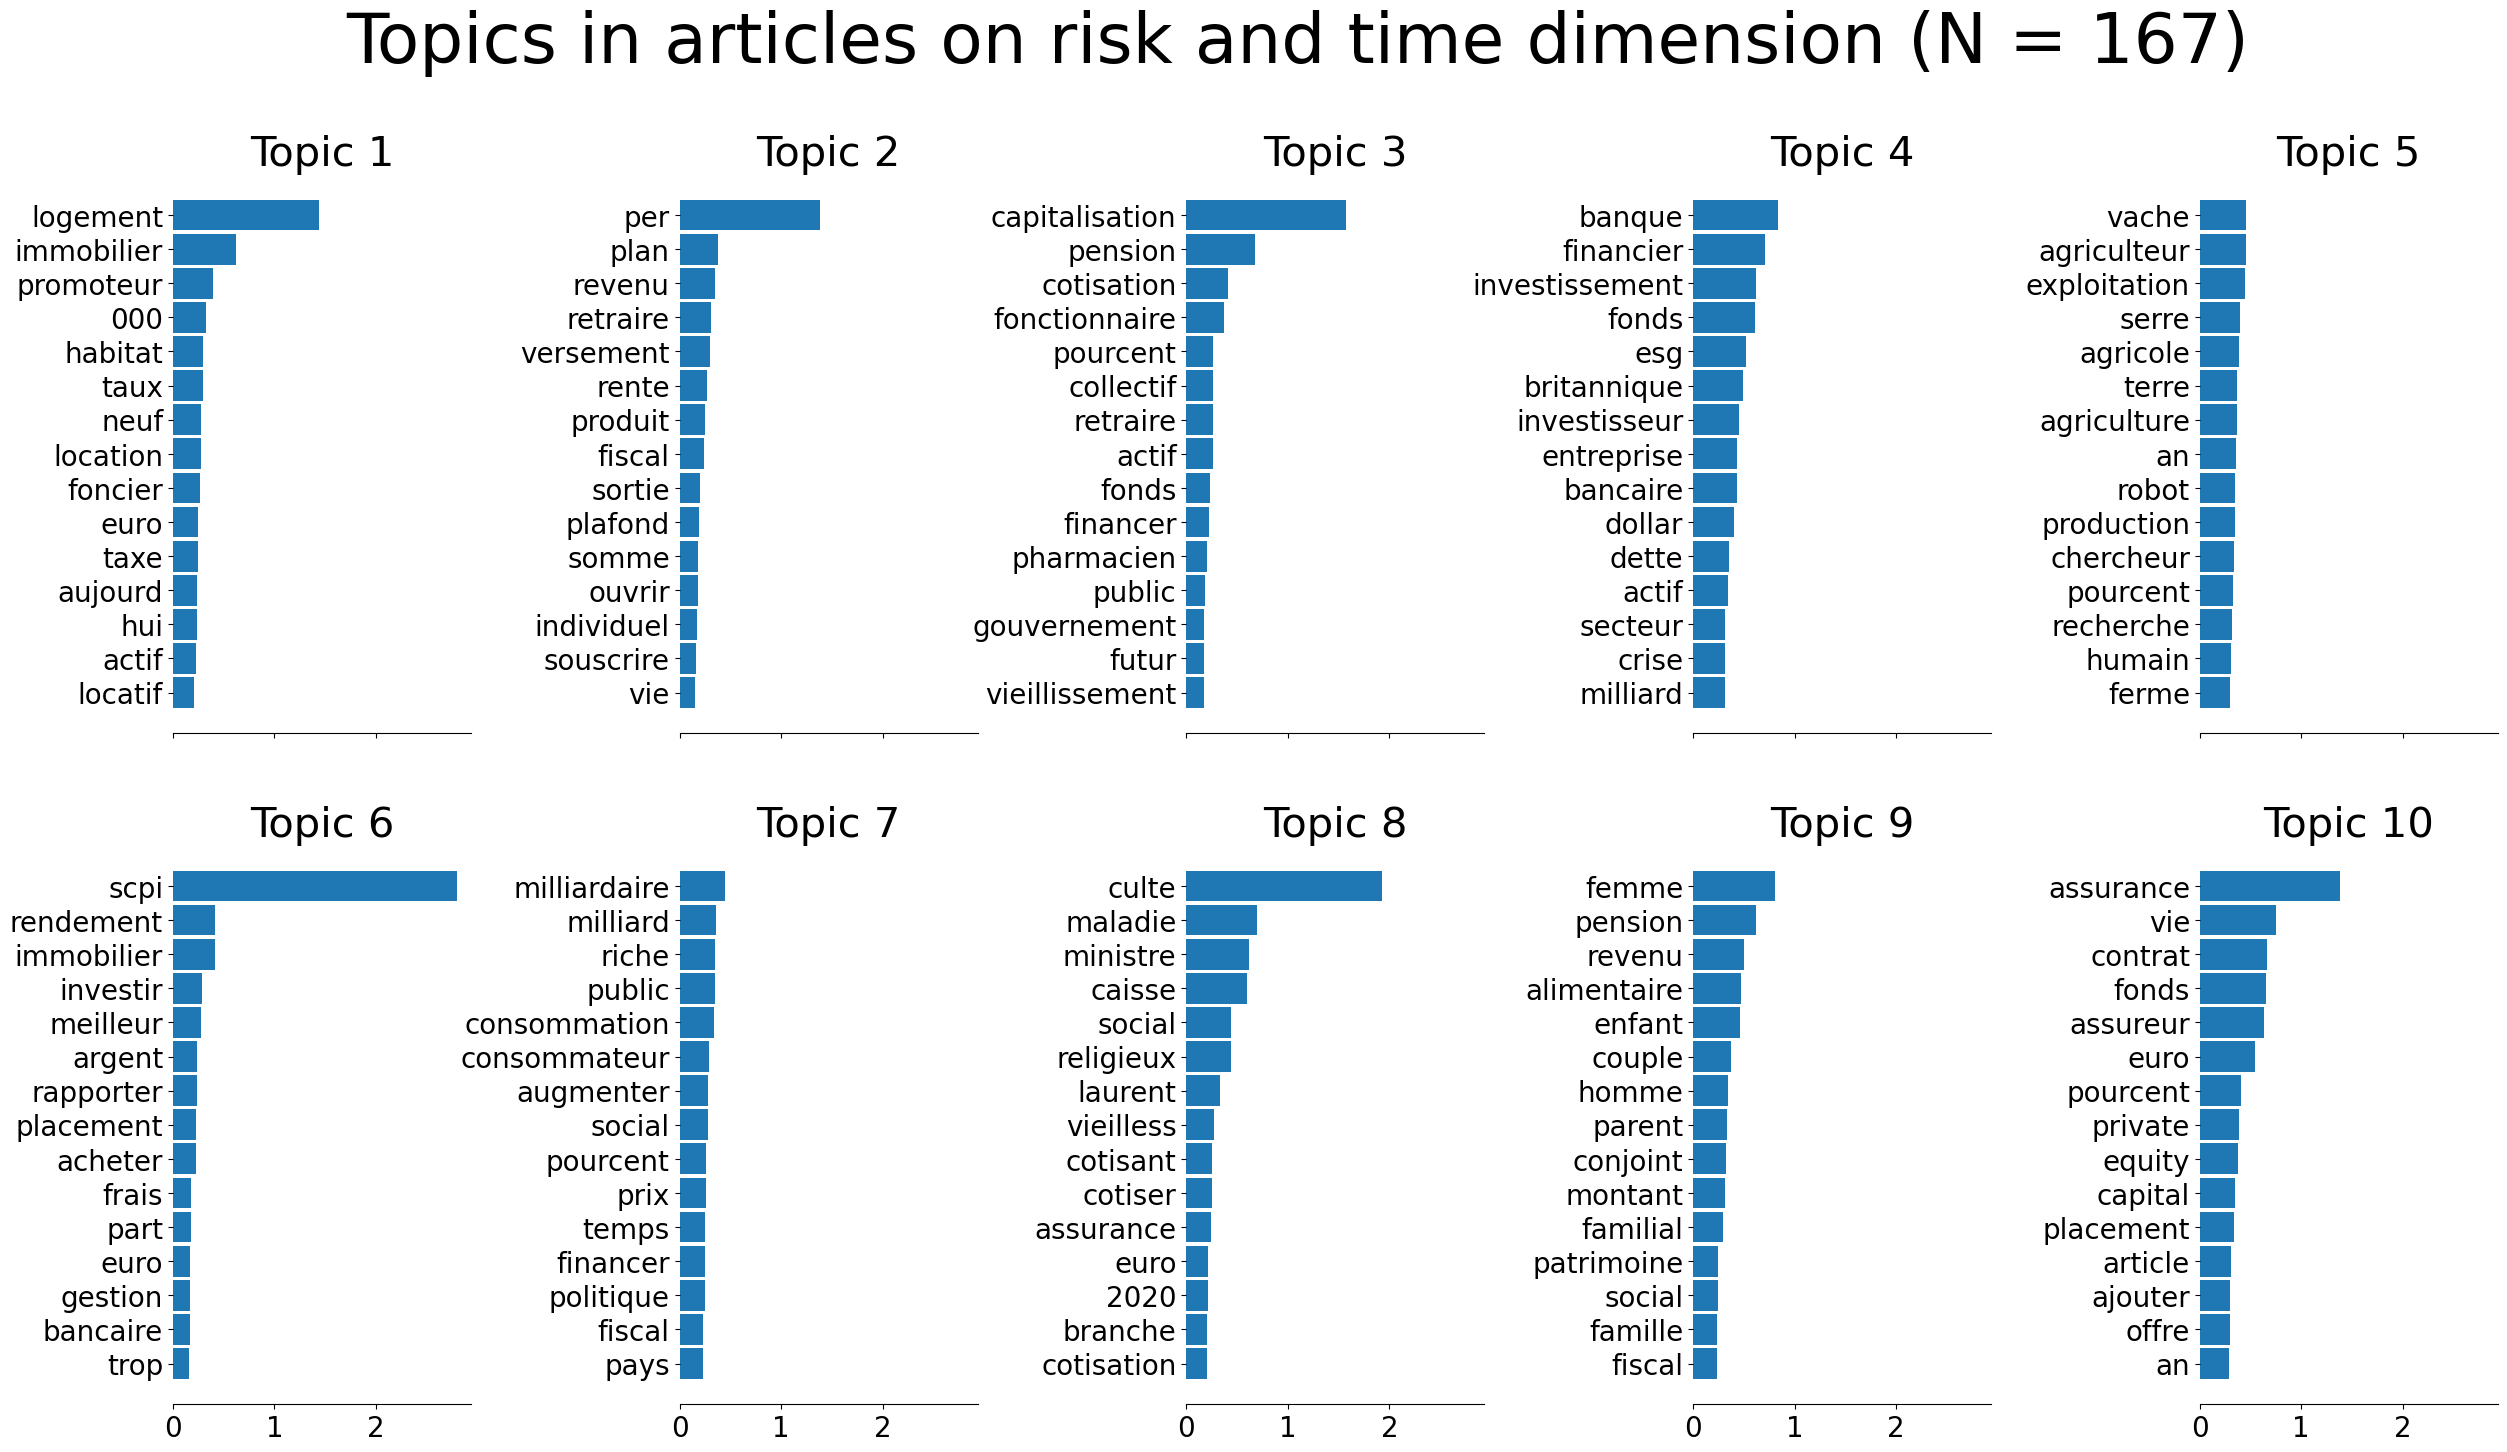

In [73]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

plot_top_words(
    nmf_risktime, tfidf_feature_names, n_top_words, f"Topics in articles on risk and time dimension (N = {len(corpus_risktime_media)})", 'scikit_selmedia_nofiltSW', n_components, seed)

In [74]:
# Get the feature names from the vectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()

# Get the top 3 indices for each topic
top_indices = nmf_risktime.components_.argsort()[:,-5:]

# Create empty list to store top words  
top_words_risktime = []

# Loop through each topic
for topic in top_indices:
  
  # Extract top 3 words
  top_3 = [feature_names[i] for i in topic]
  
  # Add to list
  top_words_risktime.extend(top_3)

In [75]:
# Get the document-topic matrix
doc_topic_matrix = nmf_risktime.transform(tfidf_risktime)

# Calculate topic frequencies across corpus
topic_freqs = doc_topic_matrix.sum(axis=0) 

# Get top 3 words for each topic
top_word_indices = nmf_risktime.components_.argsort()[:, -3:]
top_words = [[tfidf_feature_names[i] for i in topic[::-1]] for topic in top_word_indices]
top_words = [' '.join(words) for words in top_words]

# Combine topics and top words
topics_with_words = list(zip(topic_freqs, top_words))

# Sort by frequency
sorted_topics = sorted(topics_with_words, key=lambda x: x[0], reverse=False)

# Extract sorted freqs and topic names  
sorted_freqs, sorted_top_words = zip(*sorted_topics)

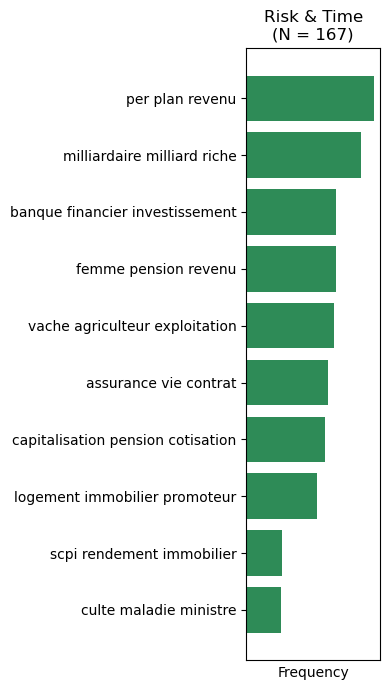

In [76]:
# Plot sorted topics and freqs  
fig, ax = plt.subplots(figsize=(4, 7)) 

# Plot horizontal bars
ax.barh(range(n_components), sorted_freqs, color='seagreen')

# Set y-ticks and labels
ax.set_yticks(range(n_components)) 
ax.set_yticklabels(sorted_top_words)

# Remove x-axis tick labels  
ax.set_xticks([]) 

# Axis labels
ax.set_xlabel("Frequency")

# Title and tight layout
ax.set_title(f"Risk & Time\n(N = {len(doc_topic_matrix)})")
plt.tight_layout()
plt.show()

In [77]:
w_df = pd.DataFrame(doc_topic_matrix)
w_df.columns = top_words
w_df.shape

(167, 10)

In [78]:
w_df_date = w_df.copy()
w_df_date['Date'] = top_risktime_media['Date'].values

# Convert 'Date' column to datetime and set it as the index
w_df_date['Date'] = pd.to_datetime(w_df_date['Date'])
w_df_date.set_index('Date', inplace=True)

# Resample at weekly level
w_df_date = w_df_date.resample('W').sum()

Text(0.5, 1.0, 'Topic evolution over time in media articles about the risk & time dimension (N = 167)')

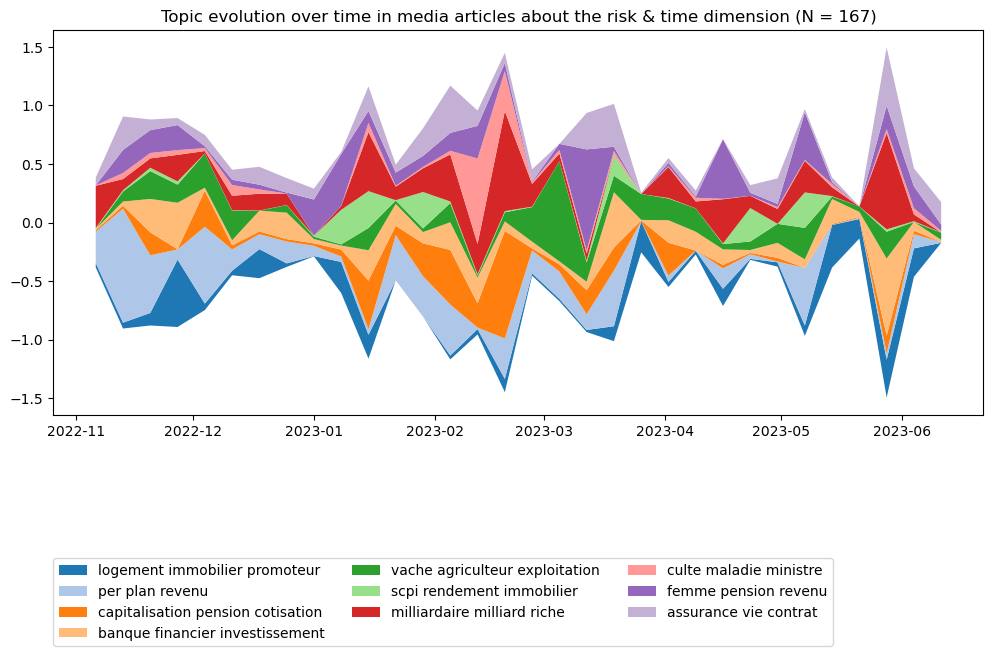

In [79]:
fig, ax = plt.subplots(figsize=(12,5))

# Plot a stackplot
ax.stackplot(w_df_date.index, w_df_date.T, baseline='sym', labels=w_df_date.columns, colors=colors)

# Move the legend off of the chart
ax.legend(loc=(0,-0.6), ncol=3)

plt.title(f'Topic evolution over time in media articles about the risk & time dimension (N = {len(w_df)})')

In [80]:
# Divide each value of the time series by the total weight across all topics
w_df_date_norm = w_df_date.copy()
w_df_date_norm['weekly_weight_sum'] = w_df_date_norm.apply(np.sum, axis=1)
w_df_date_norm.iloc[:, :-1] = w_df_date_norm.iloc[:, :-1].div(w_df_date_norm['weekly_weight_sum'], axis=0)

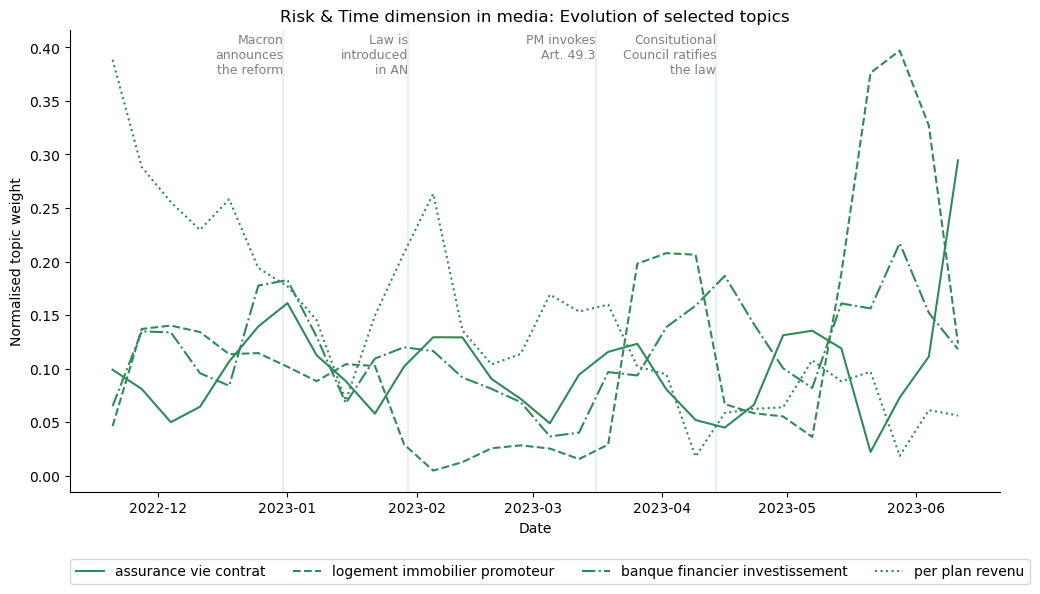

In [83]:
selected_columns = [
    "assurance vie contrat",
    "logement immobilier promoteur",
    "banque financier investissement",
    "per plan revenu",
]

# Define line styles
line_styles = ['-', '--', '-.', ':']

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Loop through each selected column, apply rolling average to normalized data, and plot the smoothed time series
for i, column in enumerate(selected_columns):
    smoothed_series = w_df_date_norm[column].rolling(window=3).mean()
    ax.plot(w_df_date.index, smoothed_series, label=f'{column}', color='seagreen', linestyle=line_styles[i])

# Set the labels and legend
ax.set_xlabel('Date')
ax.set_ylabel('Normalised topic weight')
ax.set_title(f'Risk & Time dimension in media: Evolution of selected topics')
ax.legend(loc=(0,-0.2), ncol=4)

plt.xticks(rotation=0)

# Remove top and right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add vertical lines and annotations
for date, description in important_dates.items():
    plt.axvline(x=date, linewidth=.3, alpha=0.5)  # Add vertical line
    plt.text(date, plt.ylim()[1] - 0.003, description, rotation=0, va='top', ha='right', fontsize=9, color='grey')

# Display the plot
plt.show()

### Process

In [84]:
# Create the TF-IDF matrix
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.95, min_df=5,  
    max_features=n_features, 
    ngram_range=(1, 1))

tfidf_process = tfidf_vectorizer.fit_transform(corpus_process_media)

In [85]:
# Perform NMF
seed = 42
nmf_process = NMF(n_components=n_components,
                  random_state=seed, # Pass an int for reproducible results across multiple function calls.
                  alpha_W=0, # Constant that multiplies the regularization terms of W. Set it to zero (default) to have no regularization on W
                  l1_ratio=0, # The regularization mixing parameter 0-1. l1_ratio = 0, penalty is an elementwise L2 penalty (aka Frobenius Norm). For l1_ratio = 1 it is an elementwise L1 penalty. For 0 < l1_ratio < 1, the penalty is a combination of L1 and L2.
                  max_iter=1000,
                  init='random'
                  ).fit(tfidf_process)

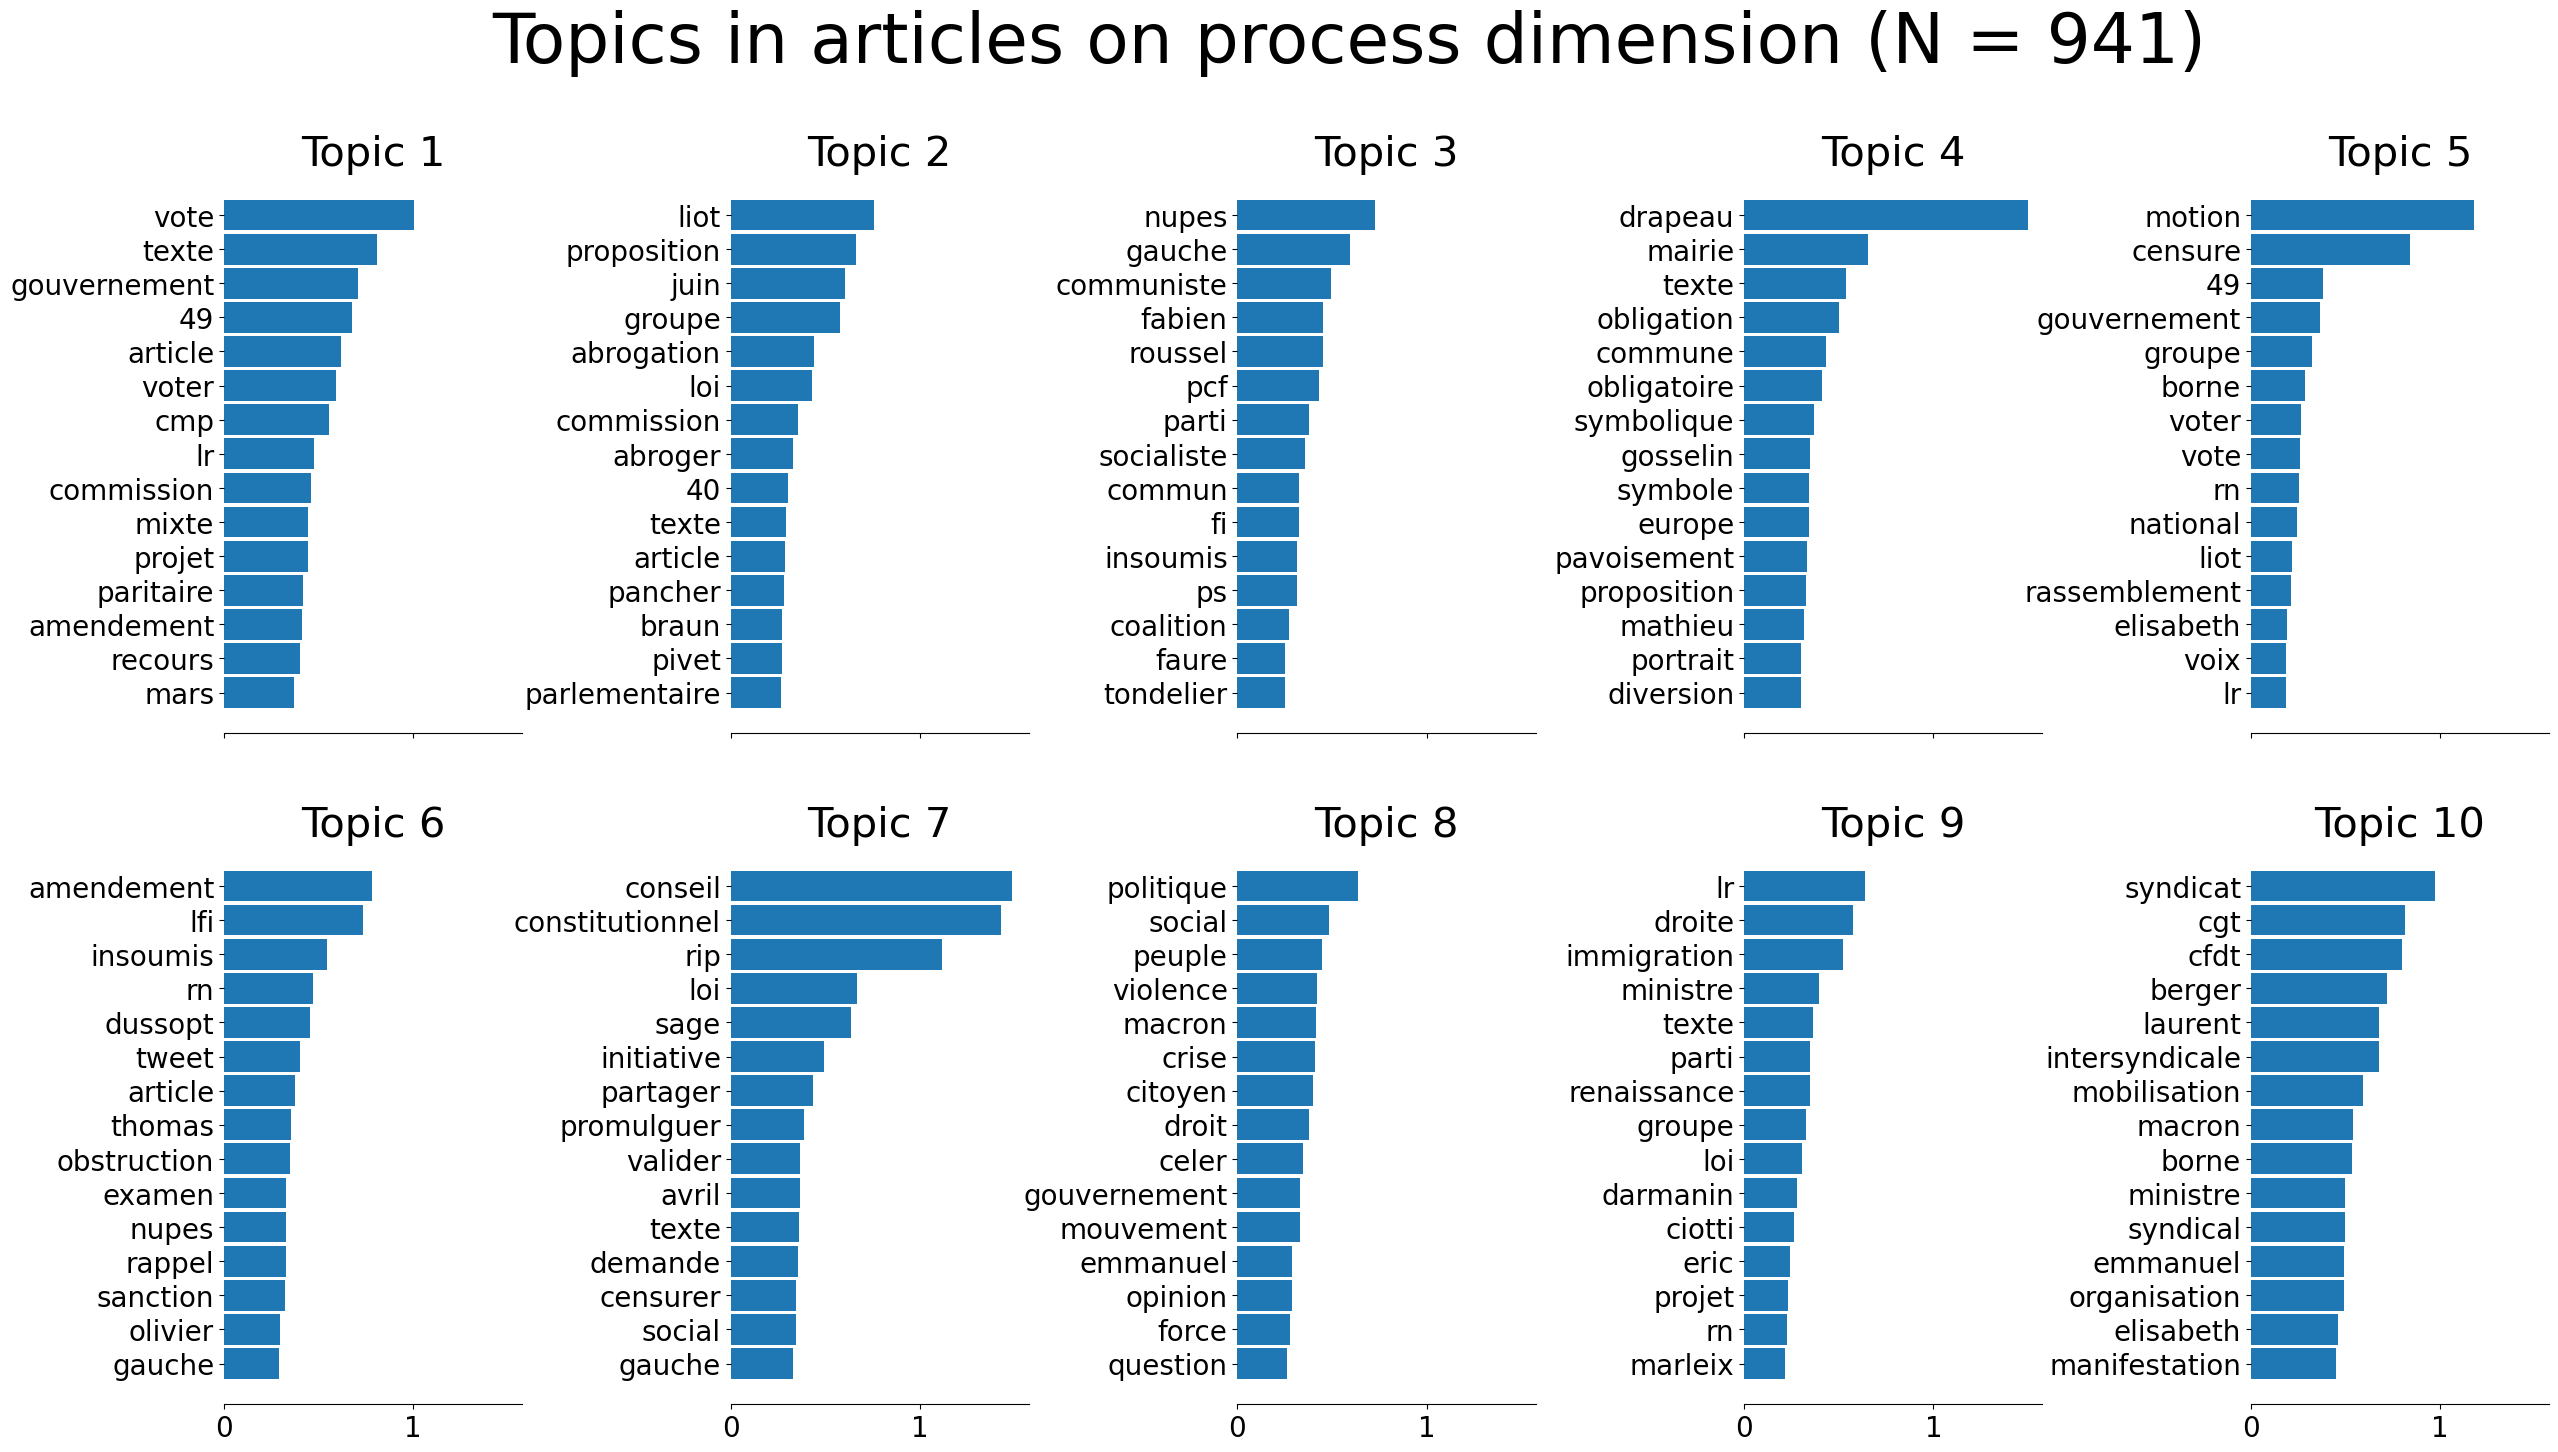

In [86]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

plot_top_words(
    nmf_process, tfidf_feature_names, n_top_words, f"Topics in articles on process dimension (N = {len(corpus_process_media)})", 'scikit_selmedia_nofiltSW', n_components, seed)

In [87]:
# Get the feature names from the vectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()

# Get the top 3 indices for each topic
top_indices = nmf_process.components_.argsort()[:,-5:]

# Create empty list to store top words  
top_words_process = []

# Loop through each topic
for topic in top_indices:
  
  # Extract top 3 words
  top_3 = [feature_names[i] for i in topic]
  
  # Add to list
  top_words_process.extend(top_3)

In [88]:
# Get the document-topic matrix
doc_topic_matrix = nmf_process.transform(tfidf_process)

# Calculate topic frequencies across corpus
topic_freqs = doc_topic_matrix.sum(axis=0) 

# Get top 3 words for each topic
top_word_indices = nmf_process.components_.argsort()[:, -3:]
top_words = [[tfidf_feature_names[i] for i in topic[::-1]] for topic in top_word_indices]
top_words = [' '.join(words) for words in top_words]

# Combine topics and top words
topics_with_words = list(zip(topic_freqs, top_words))

# Sort by frequency
sorted_topics = sorted(topics_with_words, key=lambda x: x[0], reverse=False)

# Extract sorted freqs and topic names  
sorted_freqs, sorted_top_words = zip(*sorted_topics)

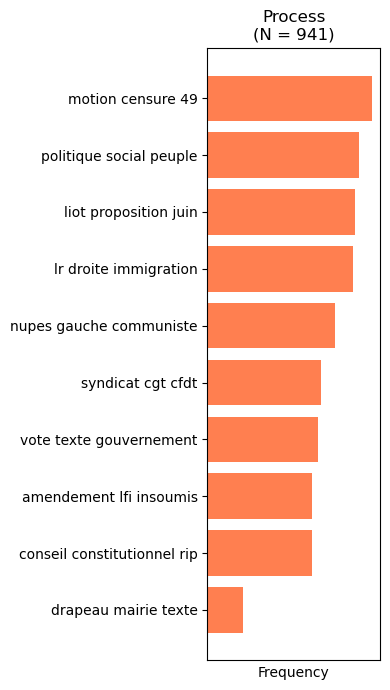

In [89]:
# Plot sorted topics and freqs  
fig, ax = plt.subplots(figsize=(4, 7)) 

# Plot horizontal bars
ax.barh(range(n_components), sorted_freqs, color='coral')

# Set y-ticks and labels
ax.set_yticks(range(n_components)) 
ax.set_yticklabels(sorted_top_words)

# Remove x-axis tick labels  
ax.set_xticks([]) 

# Axis labels
ax.set_xlabel("Frequency")

# Title and tight layout
ax.set_title(f"Process\n(N = {len(doc_topic_matrix)})")
plt.tight_layout()
plt.show()

In [90]:
w_df = pd.DataFrame(doc_topic_matrix)
w_df.columns = top_words
w_df.shape

(941, 10)

In [91]:
w_df_date = w_df.copy()
w_df_date['Date'] = top_process_media['Date'].values

# Convert 'Date' column to datetime and set it as the index
w_df_date['Date'] = pd.to_datetime(w_df_date['Date'])
w_df_date.set_index('Date', inplace=True)

# Resample at weekly level
w_df_date = w_df_date.resample('W').sum()

Text(0.5, 1.0, 'Topic evolution over time in media articles about the process dimension (N = 941)')

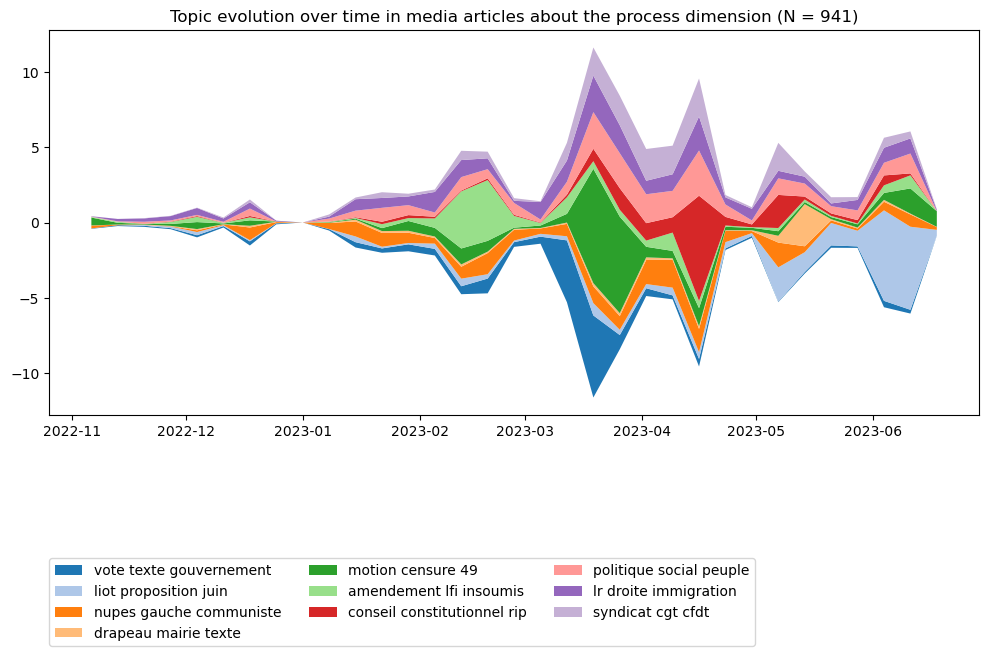

In [92]:
fig, ax = plt.subplots(figsize=(12,5))

# Plot a stackplot
ax.stackplot(w_df_date.index, w_df_date.T, baseline='sym', labels=w_df_date.columns, colors=colors)

# Move the legend off of the chart
ax.legend(loc=(0,-0.6), ncol=3)

plt.title(f'Topic evolution over time in media articles about the process dimension (N = {len(w_df)})')

In [93]:
# Divide each value of the time series by the total weight across all topics
w_df_date_norm = w_df_date.copy()
w_df_date_norm['weekly_weight_sum'] = w_df_date_norm.apply(np.sum, axis=1)
w_df_date_norm.iloc[:, :-1] = w_df_date_norm.iloc[:, :-1].div(w_df_date_norm['weekly_weight_sum'], axis=0)

w_df_date_norm.fillna(0, inplace=True)

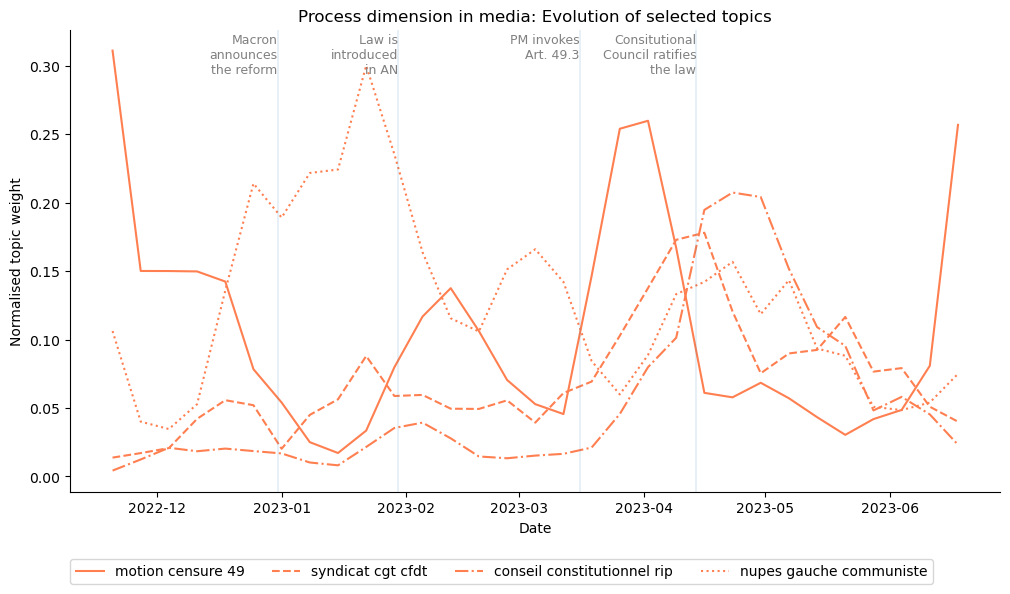

In [94]:
selected_columns = [
    "motion censure 49",
    "syndicat cgt cfdt",
    "conseil constitutionnel rip",
    "nupes gauche communiste",
]

# Define line styles
line_styles = ['-', '--', '-.', ':']

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Loop through each selected column, apply rolling average to normalized data, and plot the smoothed time series
for i, column in enumerate(selected_columns):
    smoothed_series = w_df_date_norm[column].rolling(window=3).mean()
    ax.plot(w_df_date.index, smoothed_series, label=f'{column}', color='coral', linestyle=line_styles[i])

# Set the labels and legend
ax.set_xlabel('Date')
ax.set_ylabel('Normalised topic weight')
ax.set_title(f'Process dimension in media: Evolution of selected topics')
ax.legend(loc=(0,-0.2), ncol=4)

plt.xticks(rotation=0)

# Remove top and right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add vertical lines and annotations
for date, description in important_dates.items():
    plt.axvline(x=date, linewidth=.3, alpha=0.5)  # Add vertical line
    plt.text(date, plt.ylim()[1] - 0.003, description, rotation=0, va='top', ha='right', fontsize=9, color='grey')

# Display the plot
plt.show()

# Coupled matrix factorisation

## Media vs speeches

### General

In [95]:
documents = sim_df_parl['article_processed'].to_list() + sim_df_media['article_processed'].to_list()

In [96]:
# Initialize variables which will be used later
n_features = 5000

# Create TF matrix
count_vectorizer = CountVectorizer(max_df=0.95, min_df=5, 
                                   max_features=n_features, 
                                   ngram_range=(1, 1))

count_matrix = count_vectorizer.fit_transform(documents)

# Split the count_matrix into two matrices for each corpus
count_matrix_parl = count_matrix[:len(sim_df_parl), :]
count_matrix_media = count_matrix[-len(sim_df_media):, :]

In [97]:
# Calculate TF-IDF values for each corpus
tfidf_transformer = TfidfTransformer()
tfidf_matrix_parl = tfidf_transformer.fit_transform(count_matrix_parl,)
tfidf_matrix_media = tfidf_transformer.fit_transform(count_matrix_media)

In [98]:
# Prepare matrices for CMF
matrices = [np.array(tfidf_matrix_parl.todense()), np.array(tfidf_matrix_media.todense())]

In [99]:
n_components = 20
n_top_words = 10
penalty_strength = 0.08

cmf = decomposition.cmf_aoadmm(matrices, rank=n_components, 
                               non_negative=True,
                               l2_penalty=[0,penalty_strength,0],
                               l1_penalty=[0,0,penalty_strength],
                               init='random',
                               n_iter_max=1000,
                              )

weights, (A, B_is, C) = cmf

In [100]:
# Get feature names (words) from the TF-IDF vectorizer
feature_names = count_vectorizer.get_feature_names_out()

# Initialize an empty list to store top words for each topic
top_words_list = []
top_3_words = []

# Print the top words for each topic
for topic_idx, topic in enumerate(C.T):
    top_words_idx = topic.argsort()[:-10 - 1:-1]
    top_words = [feature_names[i] for i in top_words_idx]
    
    # Append the list of top words for the current topic to the main list
    top_words_list.append(top_words)

    # Concatenate the top three words into a single string
    top_words_string = ' '.join(top_words[:3])
    top_3_words.append(top_words_string)
    
    print(f"Topic #{topic_idx + 1}: {', '.join(top_words)}")

Topic #1: vie, femme, politique, jeune, enfant, travail, monde, grand, temps, homme
Topic #2: policier, manifestant, police, manifestation, ordre, paris, violence, force, contre, brav
Topic #3: emploi, travail, senior, entreprise, index, professionnel, salarier, social, dussopt, travailleur
Topic #4: senior, index, âge, emploi, départ, légal, amendement, entreprise, taux, chômage
Topic #5: loi, constitutionnel, conseil, texte, proposition, article, rip, constitution, parlementaire, initiative
Topic #6: régime, spécial, général, suppression, supprimer, ratp, article, travailleur, pénibilité, extinction
Topic #7: train, sncf, trafic, ligne, raffinerie, rer, ratp, normal, vol, station
Topic #8: cgt, syndicat, mobilisation, cfdt, berger, syndical, laurent, janvier, organisation, martinez
Topic #9: pourcent, inflation, prix, taux, hausse, 2022, point, baisse, niveau, france
Topic #10: an, pension, 64, travailler, partir, 62, cotisation, trimestre, femme, 65
Topic #11: motion, censure, vote,

In [101]:
def l2_norm(matrix):
    """Computes the L2 norm of a matrix."""
    return np.sqrt(np.sum(np.square(matrix)))

def norm_topics_in_corpus(i, n_components, A, B_is, C):
    "Computes the L2 norm of the product of the component matrices which describe one topic in one corpus for all the components"
    
    # i is the index of the corpus (hence, 0 or 1 in case we perform coupled matrix factorisation with two matrices)
    # n_components is the number of components - in topic modeling topics - that we extract from the corpora
    
    topic_weights = []

    # Computes the L2 norm of the product of all the matrices
    Ai = A[i]
    Bi = B_is[i]
    Ai_rs = Ai.reshape(-1, 1)
    Bi_rs = Bi.reshape(-1, 1)
    corpus_i = np.dot(np.dot(Ai_rs, Bi_rs.T).T, C.T)
    corpus_norm_i = l2_norm(corpus_i)
    
    # Computes the weight of each topic in corpus as norm of the product of the component matrices divided by corpus-wide norm
    for t in range(0, n_components):
        Ait = A[i][t]
        Bit = B_is[i][:, t]
        Ct = C[:,t]
    
        Ait_rs = Ait.reshape(-1, 1)
        Bit_rs = Bit.reshape(-1, 1)
        Ct_rs = Ct.reshape(-1, 1)
    
        topic_component_it = np.dot(np.dot(Ait_rs, Bit_rs.T).T, Ct_rs.T)
        topic_norm_it = l2_norm(topic_component_it)
        topic_weight_it = topic_norm_it/corpus_norm_i
        
        topic_weights.append(topic_weight_it)
        
    return topic_weights

In [102]:
topic_weights_0 = norm_topics_in_corpus(0, n_components, A, B_is, C)
topic_weights_1 = norm_topics_in_corpus(1, n_components, A, B_is, C)

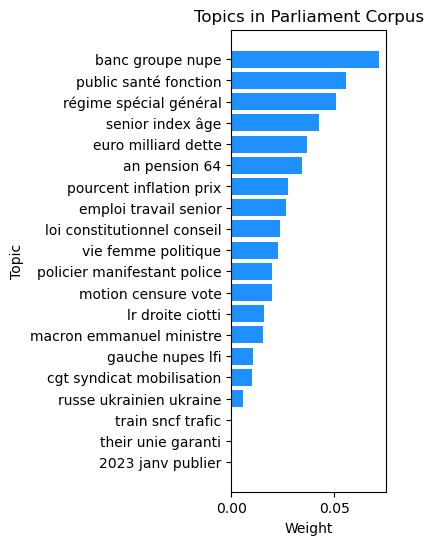

In [103]:
# Create a DataFrame with one row containing the information from A[0]
df_topics_parl = pd.DataFrame(data=[topic_weights_0], index=['Parliament Topic Weights'], columns=top_3_words)

# Sort the topics based on their weights
sorted_topics_df_parl = df_topics_parl.iloc[:, df_topics_parl.iloc[0].argsort()[::-1]]

# Display the sorted horizontal histogram
plt.figure(figsize=(2, 6))
plt.barh(range(1, n_components + 1), sorted_topics_df_parl.values[0][::-1], color='dodgerblue')
plt.ylabel('Topic')
plt.xlabel('Weight')
plt.title('Topics in Parliament Corpus')
plt.yticks(range(1, n_components + 1), sorted_topics_df_parl.columns[::-1])

plt.show()

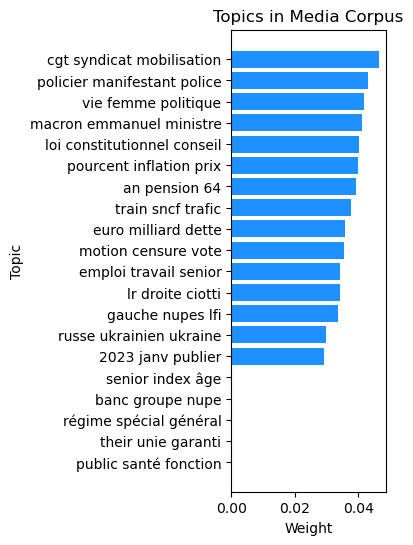

In [104]:
# Create a DataFrame with one row containing the information from A[0]
df_topics_media = pd.DataFrame(data=[topic_weights_1], index=['Media Topic Weights'], columns=top_3_words)

# Sort the topics based on their weights
sorted_topics_df_media = df_topics_media.iloc[:, df_topics_media.iloc[0].argsort()[::-1]]

# Display the sorted horizontal histogram
plt.figure(figsize=(2, 6))
plt.barh(range(1, n_components + 1), sorted_topics_df_media.values[0][::-1], color='dodgerblue')
plt.ylabel('Topic')
plt.xlabel('Weight')
plt.title('Topics in Media Corpus')
plt.yticks(range(1, n_components + 1), sorted_topics_df_media.columns[::-1])

plt.show()

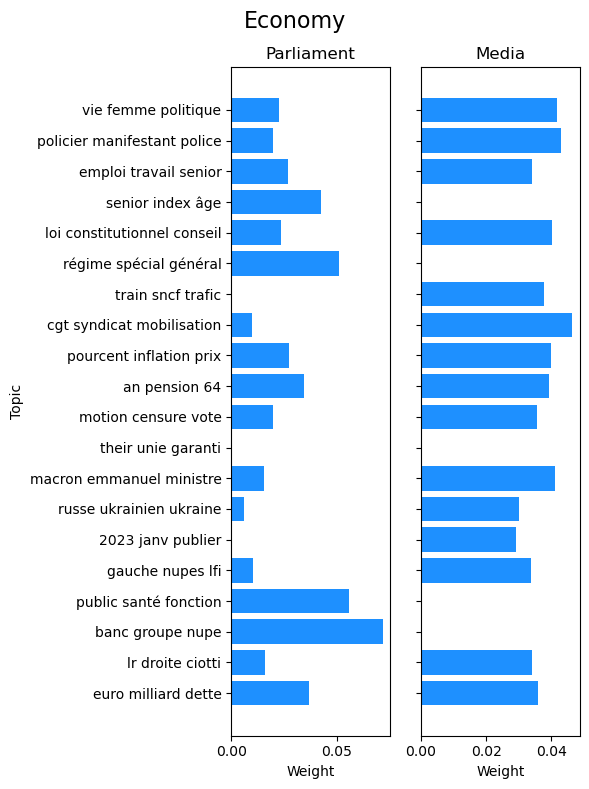

In [105]:
# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(6, 8), sharey=True)

# Plot Parliament Corpus Topics
axs[0].barh(range(1, n_components + 1), df_topics_parl.values[0][::-1], color='dodgerblue')
axs[0].set_ylabel('Topic')
axs[0].set_xlabel('Weight')
axs[0].set_title('Parliament')
axs[0].set_yticks(range(1, n_components + 1))
axs[0].set_yticklabels(top_3_words[::-1])  # Use the same y-axis labels as the sorted one

# Plot Media Corpus Topics
axs[1].barh(range(1, n_components + 1), df_topics_media.values[0][::-1], color='dodgerblue')
axs[1].set_xlabel('Weight')
axs[1].set_title('Media')
axs[1].set_yticks(range(1, n_components + 1))
axs[1].set_yticklabels(top_3_words[::-1])  # Use the same y-axis labels as the sorted one

fig.suptitle('Economy', fontsize=16)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

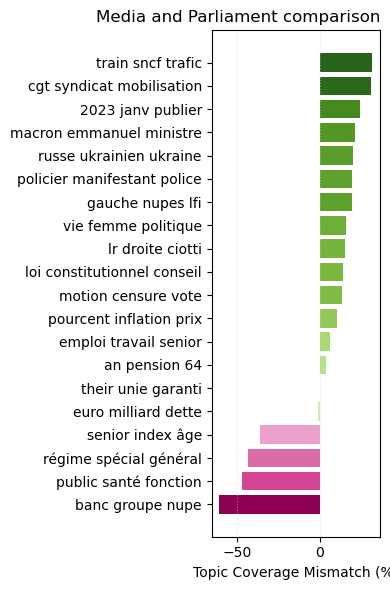

In [106]:
df_corporacomparison = pd.concat([df_topics_parl, df_topics_media], axis=0)

# Transpose the DataFrame to have topics as rows and corpora as columns
df_corpcomp_T = df_corporacomparison.transpose()

# Calculate the difference between Media and Parliament for each topic
df_corpcomp_T['Difference'] = (df_corpcomp_T['Media Topic Weights'] - df_corpcomp_T['Parliament Topic Weights'])*100/(df_corpcomp_T['Media Topic Weights'].max() + df_corpcomp_T['Parliament Topic Weights'].max())

# Sort the DataFrame based on the 'Difference' column
df_corpcomp_T_sorted = df_corpcomp_T.sort_values(by='Difference', ascending=True)

# Plot the data
fig = plt.figure(figsize=(4, 6)) 
ax = fig.add_subplot(111)

# Normalize the 'Difference' values for color assignment
norm = plt.Normalize(vmin=df_corpcomp_T_sorted['Difference'].min(), vmax=df_corpcomp_T_sorted['Difference'].max())

# Plot the bars with color based on the 'Difference' values using the 'RdYlBu' colormap
bars = ax.barh(df_corpcomp_T_sorted.index, df_corpcomp_T_sorted['Difference'], color=plt.cm.PiYG(norm(df_corpcomp_T_sorted['Difference'])))

# Set the labels and title
plt.xlabel('Topic Coverage Mismatch (%)')
#plt.ylabel('Topics')
plt.title(f'Media and Parliament comparison', loc='right')

# Add light grey grid
ax.grid(axis='x', linestyle=':', alpha=0.5, color='lightgrey', zorder=0)

# Show the plot
plt.tight_layout()
plt.show()

#fig.set_size_inches(8, 10, forward=True)
#fig.savefig('/home/sparazzoli/lagrange-oecd/code/corpus_comparison/TopicCoverageDifference_February.png', dpi=300, bbox_inches='tight') # Set desired DPI value and pass 'bbox_inches' argument to remove white spaces around the edges

### Economy

In [107]:
documents = corpus_economy_parl.to_list() + corpus_economy_media.to_list()

In [108]:
# Initialize variables which will be used later
n_features = 5000

# Create TF matrix
count_vectorizer = CountVectorizer(max_df=0.95, min_df=5, 
                                   max_features=n_features, 
                                   ngram_range=(1, 1))

count_matrix = count_vectorizer.fit_transform(documents)

# Split the count_matrix into two matrices for each corpus
count_matrix_parl = count_matrix[:len(corpus_economy_parl), :]
count_matrix_media = count_matrix[-len(corpus_economy_media):, :]

In [109]:
# Calculate TF-IDF values for each corpus
tfidf_transformer = TfidfTransformer()
tfidf_matrix_parl = tfidf_transformer.fit_transform(count_matrix_parl,)
tfidf_matrix_media = tfidf_transformer.fit_transform(count_matrix_media)

In [110]:
# Prepare matrices for CMF
matrices = [np.array(tfidf_matrix_parl.todense()), np.array(tfidf_matrix_media.todense())]

In [111]:
n_components = 10
n_top_words = 10
penalty_strength = 0.08

cmf = decomposition.cmf_aoadmm(matrices, rank=n_components, 
                               non_negative=True,
                               l2_penalty=[0,penalty_strength,0],
                               l1_penalty=[0,0,penalty_strength],
                               init='random',
                               n_iter_max=1000,
                              )

weights, (A, B_is, C) = cmf

In [112]:
# Get feature names (words) from the TF-IDF vectorizer
feature_names = count_vectorizer.get_feature_names_out()

# Initialize an empty list to store top words for each topic
top_words_list = []
top_3_words = []

# Print the top words for each topic
for topic_idx, topic in enumerate(C.T):
    top_words_idx = topic.argsort()[:-10 - 1:-1]
    top_words = [feature_names[i] for i in top_words_idx]
    
    # Append the list of top words for the current topic to the main list
    top_words_list.append(top_words)

    # Concatenate the top three words into a single string
    top_words_string = ' '.join(top_words[:3])
    top_3_words.append(top_words_string)
    
    print(f"Topic #{topic_idx + 1}: {', '.join(top_words)}")

Topic #1: dette, taux, public, pib, france, rembourser, croissance, social, inflation, terme
Topic #2: per, plan, rente, revenu, versement, produit, retraire, sortie, vie, assurance
Topic #3: logement, immobilier, taxe, revenu, foncier, location, promoteur, habitation, louer, pourcent
Topic #4: fonds, assurance, assureur, vie, investissement, pourcent, placement, private, equity, euro
Topic #5: recherche, chercheur, france, scientifique, public, développement, national, laboratoire, université, plan
Topic #6: milliard, euro, 2022, pourcent, entreprise, social, dividende, public, recette, an
Topic #7: csg, système, retraité, année, régime, pension, banc, français, amendement, social
Topic #8: prix, pourcent, inflation, alimentaire, hausse, consommation, augmenter, pays, production, agricole
Topic #9: cotisation, capitalisation, pension, fonctionnaire, pourcent, salaire, social, revenu, retraire, niveau
Topic #10: scpi, immobilier, rendement, meilleur, placement, centrale, argent, invest

In [113]:
def l2_norm(matrix):
    """Computes the L2 norm of a matrix."""
    return np.sqrt(np.sum(np.square(matrix)))

def norm_topics_in_corpus(i, n_components, A, B_is, C):
    "Computes the L2 norm of the product of the component matrices which describe one topic in one corpus for all the components"
    
    # i is the index of the corpus (hence, 0 or 1 in case we perform coupled matrix factorisation with two matrices)
    # n_components is the number of components - in topic modeling topics - that we extract from the corpora
    
    topic_weights = []

    # Computes the L2 norm of the product of all the matrices
    Ai = A[i]
    Bi = B_is[i]
    Ai_rs = Ai.reshape(-1, 1)
    Bi_rs = Bi.reshape(-1, 1)
    corpus_i = np.dot(np.dot(Ai_rs, Bi_rs.T).T, C.T)
    corpus_norm_i = l2_norm(corpus_i)
    
    # Computes the weight of each topic in corpus as norm of the product of the component matrices divided by corpus-wide norm
    for t in range(0, n_components):
        Ait = A[i][t]
        Bit = B_is[i][:, t]
        Ct = C[:,t]
    
        Ait_rs = Ait.reshape(-1, 1)
        Bit_rs = Bit.reshape(-1, 1)
        Ct_rs = Ct.reshape(-1, 1)
    
        topic_component_it = np.dot(np.dot(Ait_rs, Bit_rs.T).T, Ct_rs.T)
        topic_norm_it = l2_norm(topic_component_it)
        topic_weight_it = topic_norm_it/corpus_norm_i
        
        topic_weights.append(topic_weight_it)
        
    return topic_weights

In [114]:
topic_weights_0 = norm_topics_in_corpus(0, n_components, A, B_is, C)
topic_weights_1 = norm_topics_in_corpus(1, n_components, A, B_is, C)

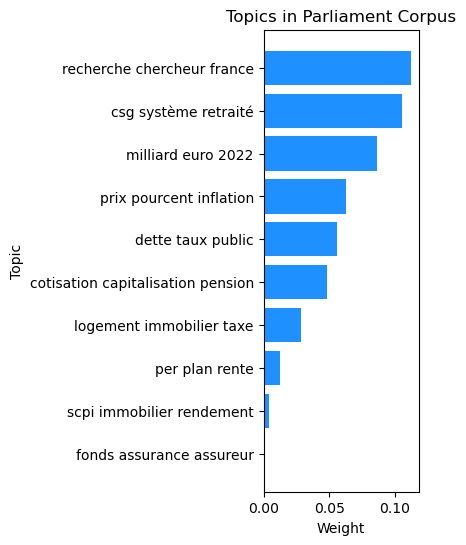

In [115]:
# Create a DataFrame with one row containing the information from A[0]
df_topics_parl = pd.DataFrame(data=[topic_weights_0], index=['Parliament Topic Weights'], columns=top_3_words)

# Sort the topics based on their weights
sorted_topics_df_parl = df_topics_parl.iloc[:, df_topics_parl.iloc[0].argsort()[::-1]]

# Display the sorted horizontal histogram
plt.figure(figsize=(2, 6))
plt.barh(range(1, n_components + 1), sorted_topics_df_parl.values[0][::-1], color='dodgerblue')
plt.ylabel('Topic')
plt.xlabel('Weight')
plt.title('Topics in Parliament Corpus')
plt.yticks(range(1, n_components + 1), sorted_topics_df_parl.columns[::-1])

plt.show()

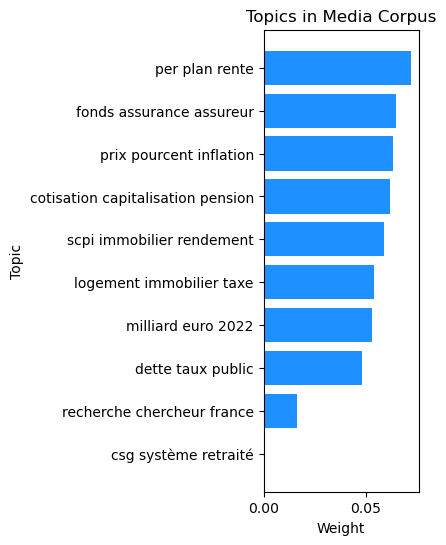

In [116]:
# Create a DataFrame with one row containing the information from A[0]
df_topics_media = pd.DataFrame(data=[topic_weights_1], index=['Media Topic Weights'], columns=top_3_words)

# Sort the topics based on their weights
sorted_topics_df_media = df_topics_media.iloc[:, df_topics_media.iloc[0].argsort()[::-1]]

# Display the sorted horizontal histogram
plt.figure(figsize=(2, 6))
plt.barh(range(1, n_components + 1), sorted_topics_df_media.values[0][::-1], color='dodgerblue')
plt.ylabel('Topic')
plt.xlabel('Weight')
plt.title('Topics in Media Corpus')
plt.yticks(range(1, n_components + 1), sorted_topics_df_media.columns[::-1])

plt.show()

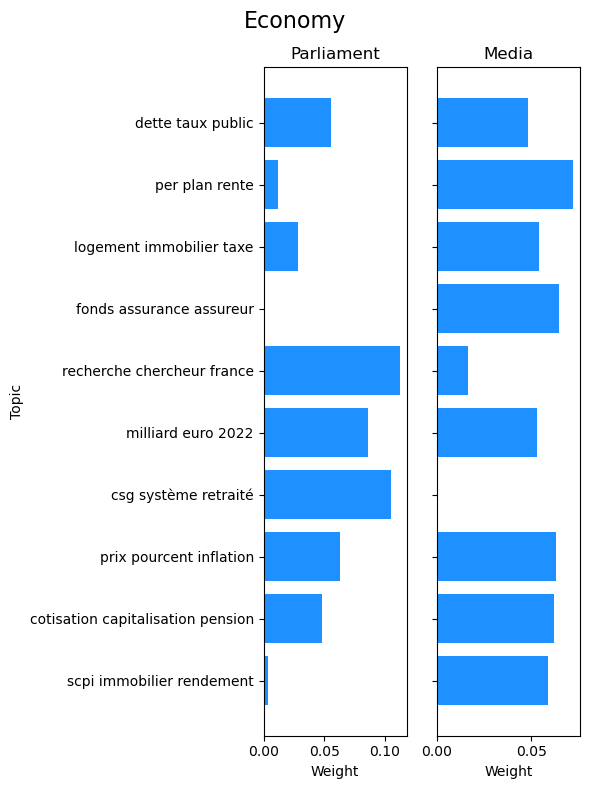

In [117]:
# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(6, 8), sharey=True)

# Plot Parliament Corpus Topics
axs[0].barh(range(1, n_components + 1), df_topics_parl.values[0][::-1], color='dodgerblue')
axs[0].set_ylabel('Topic')
axs[0].set_xlabel('Weight')
axs[0].set_title('Parliament')
axs[0].set_yticks(range(1, n_components + 1))
axs[0].set_yticklabels(top_3_words[::-1])  # Use the same y-axis labels as the sorted one

# Plot Media Corpus Topics
axs[1].barh(range(1, n_components + 1), df_topics_media.values[0][::-1], color='dodgerblue')
axs[1].set_xlabel('Weight')
axs[1].set_title('Media')
axs[1].set_yticks(range(1, n_components + 1))
axs[1].set_yticklabels(top_3_words[::-1])  # Use the same y-axis labels as the sorted one

fig.suptitle('Economy', fontsize=16)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

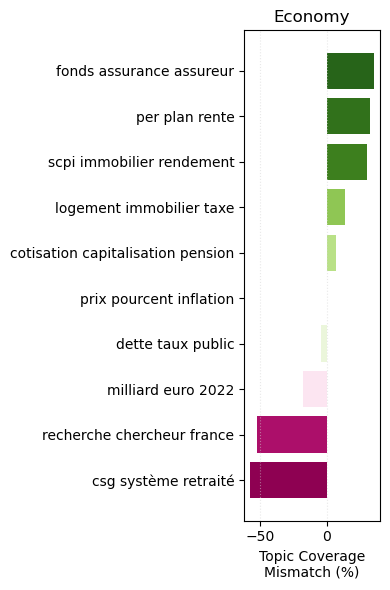

In [118]:
df_corporacomparison = pd.concat([df_topics_parl, df_topics_media], axis=0)

# Transpose the DataFrame to have topics as rows and corpora as columns
df_corpcomp_T = df_corporacomparison.transpose()

# Calculate the difference between Media and Parliament for each topic
df_corpcomp_T['Difference'] = (df_corpcomp_T['Media Topic Weights'] - df_corpcomp_T['Parliament Topic Weights'])*100/(df_corpcomp_T['Media Topic Weights'].max() + df_corpcomp_T['Parliament Topic Weights'].max())

# Sort the DataFrame based on the 'Difference' column
df_corpcomp_T_sorted = df_corpcomp_T.sort_values(by='Difference', ascending=True)

# Plot the data
fig = plt.figure(figsize=(4, 6)) 
ax = fig.add_subplot(111)

# Normalize the 'Difference' values for color assignment
norm = plt.Normalize(vmin=df_corpcomp_T_sorted['Difference'].min(), vmax=df_corpcomp_T_sorted['Difference'].max())

# Plot the bars with color based on the 'Difference' values using the 'RdYlBu' colormap
bars = ax.barh(df_corpcomp_T_sorted.index, df_corpcomp_T_sorted['Difference'], color=plt.cm.PiYG(norm(df_corpcomp_T_sorted['Difference'])))

# Set the labels and title
plt.xlabel('Topic Coverage\nMismatch (%)')
#plt.ylabel('Topics')
plt.title(f'Economy', loc='center')

# Add light grey grid
ax.grid(axis='x', linestyle=':', alpha=0.5, color='lightgrey', zorder=0)

# Show the plot
plt.tight_layout()
plt.show()

#fig.set_size_inches(8, 10, forward=True)
#fig.savefig('/home/sparazzoli/lagrange-oecd/code/corpus_comparison/TopicCoverageDifference_February.png', dpi=300, bbox_inches='tight') # Set desired DPI value and pass 'bbox_inches' argument to remove white spaces around the edges

### Fairness

In [119]:
documents = corpus_fairness_parl.to_list() + corpus_fairness_media.to_list()

In [120]:
# Initialize variables which will be used later
n_features = 5000

# Create TF matrix
count_vectorizer = CountVectorizer(max_df=0.95, min_df=5, 
                                   max_features=n_features, 
                                   ngram_range=(1, 1))

count_matrix = count_vectorizer.fit_transform(documents)

# Split the count_matrix into two matrices for each corpus
count_matrix_parl = count_matrix[:len(corpus_fairness_parl), :]
count_matrix_media = count_matrix[-len(corpus_fairness_media):, :]

In [121]:
# Calculate TF-IDF values for each corpus
tfidf_transformer = TfidfTransformer()
tfidf_matrix_parl = tfidf_transformer.fit_transform(count_matrix_parl,)
tfidf_matrix_media = tfidf_transformer.fit_transform(count_matrix_media)

In [122]:
# Prepare matrices for CMF
matrices = [np.array(tfidf_matrix_parl.todense()), np.array(tfidf_matrix_media.todense())]

In [123]:
n_components = 10
n_top_words = 10
penalty_strength = 0.08

cmf = decomposition.cmf_aoadmm(matrices, rank=n_components, 
                               non_negative=True,
                               l2_penalty=[0,penalty_strength,0],
                               l1_penalty=[0,0,penalty_strength],
                               init='random',
                               n_iter_max=1000,
                              )

weights, (A, B_is, C) = cmf

In [124]:
# Get feature names (words) from the TF-IDF vectorizer
feature_names = count_vectorizer.get_feature_names_out()

# Initialize an empty list to store top words for each topic
top_words_list = []
top_3_words = []

# Print the top words for each topic
for topic_idx, topic in enumerate(C.T):
    top_words_idx = topic.argsort()[:-10 - 1:-1]
    top_words = [feature_names[i] for i in top_words_idx]
    
    # Append the list of top words for the current topic to the main list
    top_words_list.append(top_words)

    # Concatenate the top three words into a single string
    top_words_string = ' '.join(top_words[:3])
    top_3_words.append(top_words_string)
    
    print(f"Topic #{topic_idx + 1}: {', '.join(top_words)}")

Topic #1: travail, temps, professionnel, formation, permettre, article, trop, transaction, investissement, face
Topic #2: soignant, volume, 2023, face, métier, robot, afp, fortune, perte, mobiliser
Topic #3: capitalisation, pension, cotisation, fonds, actif, pourcent, fonctionnaire, retraire, financier, financer
Topic #4: milliard, cotisation, revenu, banc, groupe, dividende, français, entreprise, euro, an
Topic #5: agricole, agriculteur, exploitation, pension, agriculture, conjoint, loi, terre, euro, chassaigne
Topic #6: recherche, chercheur, cancer, scientifique, france, public, français, développement, université, laboratoire
Topic #7: per, assurance, rente, plan, contrat, vie, revenu, versement, produit, capital
Topic #8: enfant, social, alimentaire, an, aide, euro, famille, parent, logement, droit
Topic #9: régime, spécial, pénibilité, métier, compte, général, départ, concerner, âge, salarié
Topic #10: femme, homme, pourcent, pension, inégalité, enfant, salarial, couple, salaire, 

In [125]:
def l2_norm(matrix):
    """Computes the L2 norm of a matrix."""
    return np.sqrt(np.sum(np.square(matrix)))

def norm_topics_in_corpus(i, n_components, A, B_is, C):
    "Computes the L2 norm of the product of the component matrices which describe one topic in one corpus for all the components"
    
    # i is the index of the corpus (hence, 0 or 1 in case we perform coupled matrix factorisation with two matrices)
    # n_components is the number of components - in topic modeling topics - that we extract from the corpora
    
    topic_weights = []

    # Computes the L2 norm of the product of all the matrices
    Ai = A[i]
    Bi = B_is[i]
    Ai_rs = Ai.reshape(-1, 1)
    Bi_rs = Bi.reshape(-1, 1)
    corpus_i = np.dot(np.dot(Ai_rs, Bi_rs.T).T, C.T)
    corpus_norm_i = l2_norm(corpus_i)
    
    # Computes the weight of each topic in corpus as norm of the product of the component matrices divided by corpus-wide norm
    for t in range(0, n_components):
        Ait = A[i][t]
        Bit = B_is[i][:, t]
        Ct = C[:,t]
    
        Ait_rs = Ait.reshape(-1, 1)
        Bit_rs = Bit.reshape(-1, 1)
        Ct_rs = Ct.reshape(-1, 1)
    
        topic_component_it = np.dot(np.dot(Ait_rs, Bit_rs.T).T, Ct_rs.T)
        topic_norm_it = l2_norm(topic_component_it)
        topic_weight_it = topic_norm_it/corpus_norm_i
        
        topic_weights.append(topic_weight_it)
        
    return topic_weights

In [126]:
topic_weights_0 = norm_topics_in_corpus(0, n_components, A, B_is, C)
topic_weights_1 = norm_topics_in_corpus(1, n_components, A, B_is, C)

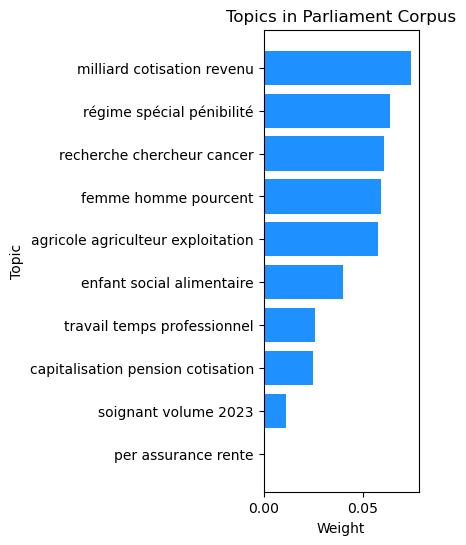

In [127]:
# Create a DataFrame with one row containing the information from A[0]
df_topics_parl = pd.DataFrame(data=[topic_weights_0], index=['Parliament Topic Weights'], columns=top_3_words)

# Sort the topics based on their weights
sorted_topics_df_parl = df_topics_parl.iloc[:, df_topics_parl.iloc[0].argsort()[::-1]]

# Display the sorted horizontal histogram
plt.figure(figsize=(2, 6))
plt.barh(range(1, n_components + 1), sorted_topics_df_parl.values[0][::-1], color='dodgerblue')
plt.ylabel('Topic')
plt.xlabel('Weight')
plt.title('Topics in Parliament Corpus')
plt.yticks(range(1, n_components + 1), sorted_topics_df_parl.columns[::-1])

plt.show()

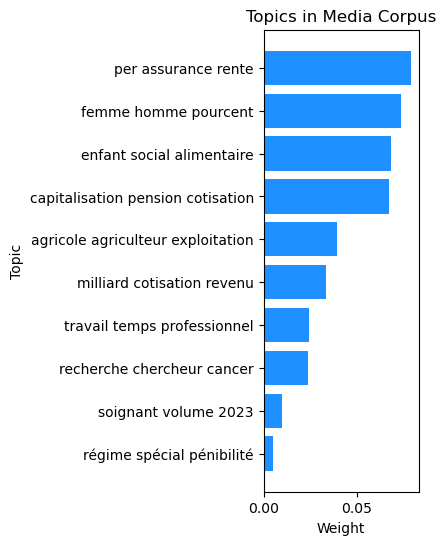

In [128]:
# Create a DataFrame with one row containing the information from A[0]
df_topics_media = pd.DataFrame(data=[topic_weights_1], index=['Media Topic Weights'], columns=top_3_words)

# Sort the topics based on their weights
sorted_topics_df_media = df_topics_media.iloc[:, df_topics_media.iloc[0].argsort()[::-1]]

# Display the sorted horizontal histogram
plt.figure(figsize=(2, 6))
plt.barh(range(1, n_components + 1), sorted_topics_df_media.values[0][::-1], color='dodgerblue')
plt.ylabel('Topic')
plt.xlabel('Weight')
plt.title('Topics in Media Corpus')
plt.yticks(range(1, n_components + 1), sorted_topics_df_media.columns[::-1])

plt.show()

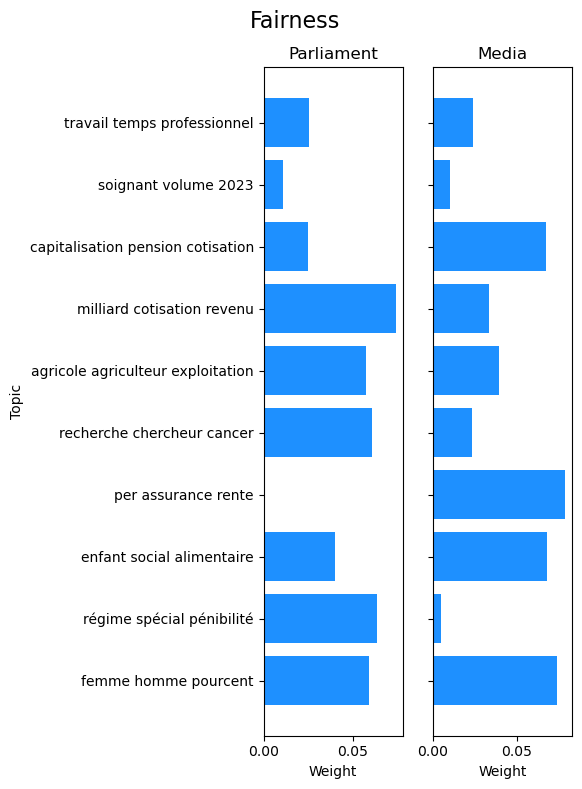

In [129]:
# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(6, 8), sharey=True)

# Plot Parliament Corpus Topics
axs[0].barh(range(1, n_components + 1), df_topics_parl.values[0][::-1], color='dodgerblue')
axs[0].set_ylabel('Topic')
axs[0].set_xlabel('Weight')
axs[0].set_title('Parliament')
axs[0].set_yticks(range(1, n_components + 1))
axs[0].set_yticklabels(top_3_words[::-1])  # Use the same y-axis labels as the sorted one

# Plot Media Corpus Topics
axs[1].barh(range(1, n_components + 1), df_topics_media.values[0][::-1], color='dodgerblue')
axs[1].set_xlabel('Weight')
axs[1].set_title('Media')
axs[1].set_yticks(range(1, n_components + 1))
axs[1].set_yticklabels(top_3_words[::-1])  # Use the same y-axis labels as the sorted one

fig.suptitle('Fairness', fontsize=16)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

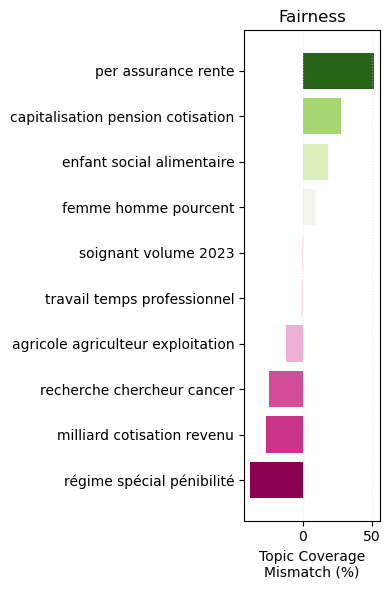

In [130]:
df_corporacomparison = pd.concat([df_topics_parl, df_topics_media], axis=0)

# Transpose the DataFrame to have topics as rows and corpora as columns
df_corpcomp_T = df_corporacomparison.transpose()

# Calculate the difference between Media and Parliament for each topic
df_corpcomp_T['Difference'] = (df_corpcomp_T['Media Topic Weights'] - df_corpcomp_T['Parliament Topic Weights'])*100/(df_corpcomp_T['Media Topic Weights'].max() + df_corpcomp_T['Parliament Topic Weights'].max())

# Sort the DataFrame based on the 'Difference' column
df_corpcomp_T_sorted = df_corpcomp_T.sort_values(by='Difference', ascending=True)

# Plot the data
fig = plt.figure(figsize=(4, 6)) 
ax = fig.add_subplot(111)

# Normalize the 'Difference' values for color assignment
norm = plt.Normalize(vmin=df_corpcomp_T_sorted['Difference'].min(), vmax=df_corpcomp_T_sorted['Difference'].max())

# Plot the bars with color based on the 'Difference' values using the 'RdYlBu' colormap
bars = ax.barh(df_corpcomp_T_sorted.index, df_corpcomp_T_sorted['Difference'], color=plt.cm.PiYG(norm(df_corpcomp_T_sorted['Difference'])))

# Set the labels and title
plt.xlabel('Topic Coverage\nMismatch (%)')
#plt.ylabel('Topics')
plt.title(f'Fairness', loc='center')

# Add light grey grid
ax.grid(axis='x', linestyle=':', alpha=0.5, color='lightgrey', zorder=0)

# Show the plot
plt.tight_layout()
plt.show()

#fig.set_size_inches(8, 10, forward=True)
#fig.savefig('/home/sparazzoli/lagrange-oecd/code/corpus_comparison/TopicCoverageDifference_February.png', dpi=300, bbox_inches='tight') # Set desired DPI value and pass 'bbox_inches' argument to remove white spaces around the edges

### Risk & Time

In [131]:
documents = corpus_risktime_parl.to_list() + corpus_risktime_media.to_list()

In [132]:
# Initialize variables which will be used later
n_features = 5000

# Create TF matrix
count_vectorizer = CountVectorizer(max_df=0.95, min_df=5, 
                                   max_features=n_features, 
                                   ngram_range=(1, 1))

count_matrix = count_vectorizer.fit_transform(documents)

# Split the count_matrix into two matrices for each corpus
count_matrix_parl = count_matrix[:len(corpus_risktime_parl), :]
count_matrix_media = count_matrix[-len(corpus_risktime_media):, :]

In [133]:
# Calculate TF-IDF values for each corpus
tfidf_transformer = TfidfTransformer()
tfidf_matrix_parl = tfidf_transformer.fit_transform(count_matrix_parl,)
tfidf_matrix_media = tfidf_transformer.fit_transform(count_matrix_media)

In [134]:
# Prepare matrices for CMF
matrices = [np.array(tfidf_matrix_parl.todense()), np.array(tfidf_matrix_media.todense())]

In [135]:
n_components = 10
n_top_words = 10
penalty_strength = 0.08

cmf = decomposition.cmf_aoadmm(matrices, rank=n_components, 
                               non_negative=True,
                               l2_penalty=[0,penalty_strength,0],
                               l1_penalty=[0,0,penalty_strength],
                               init='random',
                               n_iter_max=1000,
                              )

weights, (A, B_is, C) = cmf

In [136]:
# Get feature names (words) from the TF-IDF vectorizer
feature_names = count_vectorizer.get_feature_names_out()

# Initialize an empty list to store top words for each topic
top_words_list = []
top_3_words = []

# Print the top words for each topic
for topic_idx, topic in enumerate(C.T):
    top_words_idx = topic.argsort()[:-10 - 1:-1]
    top_words = [feature_names[i] for i in top_words_idx]
    
    # Append the list of top words for the current topic to the main list
    top_words_list.append(top_words)

    # Concatenate the top three words into a single string
    top_words_string = ' '.join(top_words[:3])
    top_3_words.append(top_words_string)
    
    print(f"Topic #{topic_idx + 1}: {', '.join(top_words)}")

Topic #1: social, milliard, français, déficit, euro, public, groupe, banc, sécurité, dépense
Topic #2: régime, pénibilité, droit, risque, spécial, travail, compte, branche, évoquer, maladie
Topic #3: culte, social, ailleurs, propre, chute, aujourd, métier, crise, capitalisme, transaction
Topic #4: fonds, logement, pourcent, investissement, banque, financier, prix, entreprise, euro, taux
Topic #5: femme, enfant, revenu, pension, familial, famille, homme, couple, parent, conjoint
Topic #6: recherche, chercheur, scientifique, france, cancer, université, laboratoire, public, national, français
Topic #7: per, assurance, revenu, plan, vie, rente, contrat, versement, retraire, produit
Topic #8: scpi, immobilier, rendement, investir, meilleur, centrale, placement, argent, acheter, rapporter
Topic #9: capitalisation, pension, cotisation, fonds, fonctionnaire, actif, pourcent, retraire, répartition, caisse
Topic #10: agriculteur, agricole, agriculture, exploitation, alimentaire, terre, climatiqu

In [137]:
def l2_norm(matrix):
    """Computes the L2 norm of a matrix."""
    return np.sqrt(np.sum(np.square(matrix)))

def norm_topics_in_corpus(i, n_components, A, B_is, C):
    "Computes the L2 norm of the product of the component matrices which describe one topic in one corpus for all the components"
    
    # i is the index of the corpus (hence, 0 or 1 in case we perform coupled matrix factorisation with two matrices)
    # n_components is the number of components - in topic modeling topics - that we extract from the corpora
    
    topic_weights = []

    # Computes the L2 norm of the product of all the matrices
    Ai = A[i]
    Bi = B_is[i]
    Ai_rs = Ai.reshape(-1, 1)
    Bi_rs = Bi.reshape(-1, 1)
    corpus_i = np.dot(np.dot(Ai_rs, Bi_rs.T).T, C.T)
    corpus_norm_i = l2_norm(corpus_i)
    
    # Computes the weight of each topic in corpus as norm of the product of the component matrices divided by corpus-wide norm
    for t in range(0, n_components):
        Ait = A[i][t]
        Bit = B_is[i][:, t]
        Ct = C[:,t]
    
        Ait_rs = Ait.reshape(-1, 1)
        Bit_rs = Bit.reshape(-1, 1)
        Ct_rs = Ct.reshape(-1, 1)
    
        topic_component_it = np.dot(np.dot(Ait_rs, Bit_rs.T).T, Ct_rs.T)
        topic_norm_it = l2_norm(topic_component_it)
        topic_weight_it = topic_norm_it/corpus_norm_i
        
        topic_weights.append(topic_weight_it)
        
    return topic_weights

In [138]:
topic_weights_0 = norm_topics_in_corpus(0, n_components, A, B_is, C)
topic_weights_1 = norm_topics_in_corpus(1, n_components, A, B_is, C)

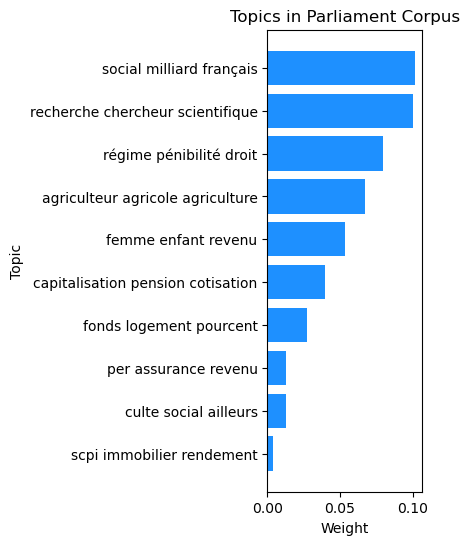

In [139]:
# Create a DataFrame with one row containing the information from A[0]
df_topics_parl = pd.DataFrame(data=[topic_weights_0], index=['Parliament Topic Weights'], columns=top_3_words)

# Sort the topics based on their weights
sorted_topics_df_parl = df_topics_parl.iloc[:, df_topics_parl.iloc[0].argsort()[::-1]]

# Display the sorted horizontal histogram
plt.figure(figsize=(2, 6))
plt.barh(range(1, n_components + 1), sorted_topics_df_parl.values[0][::-1], color='dodgerblue')
plt.ylabel('Topic')
plt.xlabel('Weight')
plt.title('Topics in Parliament Corpus')
plt.yticks(range(1, n_components + 1), sorted_topics_df_parl.columns[::-1])

plt.show()

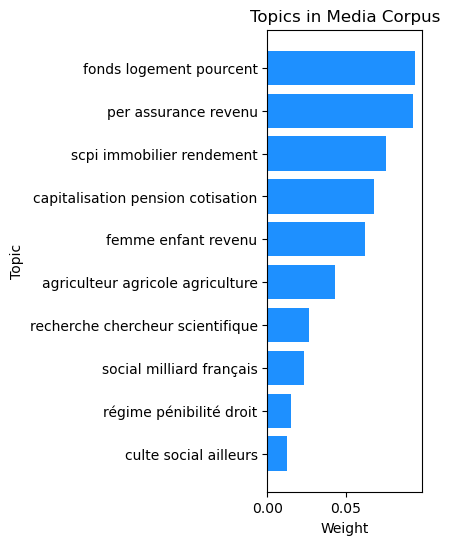

In [140]:
# Create a DataFrame with one row containing the information from A[0]
df_topics_media = pd.DataFrame(data=[topic_weights_1], index=['Media Topic Weights'], columns=top_3_words)

# Sort the topics based on their weights
sorted_topics_df_media = df_topics_media.iloc[:, df_topics_media.iloc[0].argsort()[::-1]]

# Display the sorted horizontal histogram
plt.figure(figsize=(2, 6))
plt.barh(range(1, n_components + 1), sorted_topics_df_media.values[0][::-1], color='dodgerblue')
plt.ylabel('Topic')
plt.xlabel('Weight')
plt.title('Topics in Media Corpus')
plt.yticks(range(1, n_components + 1), sorted_topics_df_media.columns[::-1])

plt.show()

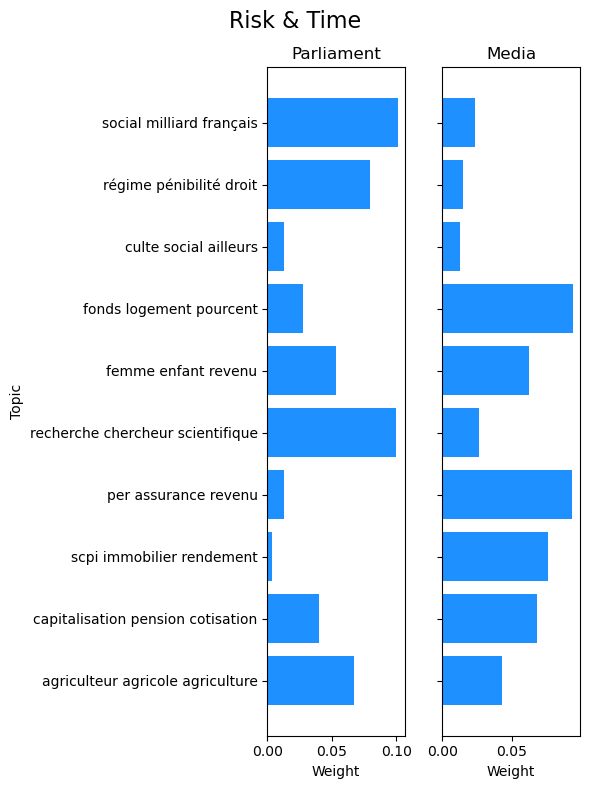

In [141]:
# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(6, 8), sharey=True)

# Plot Parliament Corpus Topics
axs[0].barh(range(1, n_components + 1), df_topics_parl.values[0][::-1], color='dodgerblue')
axs[0].set_ylabel('Topic')
axs[0].set_xlabel('Weight')
axs[0].set_title('Parliament')
axs[0].set_yticks(range(1, n_components + 1))
axs[0].set_yticklabels(top_3_words[::-1])  # Use the same y-axis labels as the sorted one

# Plot Media Corpus Topics
axs[1].barh(range(1, n_components + 1), df_topics_media.values[0][::-1], color='dodgerblue')
axs[1].set_xlabel('Weight')
axs[1].set_title('Media')
axs[1].set_yticks(range(1, n_components + 1))
axs[1].set_yticklabels(top_3_words[::-1])  # Use the same y-axis labels as the sorted one

fig.suptitle('Risk & Time', fontsize=16)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

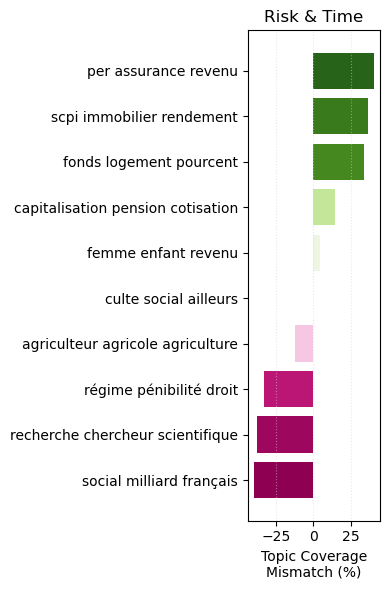

In [142]:
df_corporacomparison = pd.concat([df_topics_parl, df_topics_media], axis=0)

# Transpose the DataFrame to have topics as rows and corpora as columns
df_corpcomp_T = df_corporacomparison.transpose()

# Calculate the difference between Media and Parliament for each topic
df_corpcomp_T['Difference'] = (df_corpcomp_T['Media Topic Weights'] - df_corpcomp_T['Parliament Topic Weights'])*100/(df_corpcomp_T['Media Topic Weights'].max() + df_corpcomp_T['Parliament Topic Weights'].max())

# Sort the DataFrame based on the 'Difference' column
df_corpcomp_T_sorted = df_corpcomp_T.sort_values(by='Difference', ascending=True)

# Plot the data
fig = plt.figure(figsize=(4, 6)) 
ax = fig.add_subplot(111)

# Normalize the 'Difference' values for color assignment
norm = plt.Normalize(vmin=df_corpcomp_T_sorted['Difference'].min(), vmax=df_corpcomp_T_sorted['Difference'].max())

# Plot the bars with color based on the 'Difference' values using the 'RdYlBu' colormap
bars = ax.barh(df_corpcomp_T_sorted.index, df_corpcomp_T_sorted['Difference'], color=plt.cm.PiYG(norm(df_corpcomp_T_sorted['Difference'])))

# Set the labels and title
plt.xlabel('Topic Coverage\nMismatch (%)')
#plt.ylabel('Topics')
plt.title(f'Risk & Time', loc='center')

# Add light grey grid
ax.grid(axis='x', linestyle=':', alpha=0.5, color='lightgrey', zorder=0)

# Show the plot
plt.tight_layout()
plt.show()

#fig.set_size_inches(8, 10, forward=True)
#fig.savefig('/home/sparazzoli/lagrange-oecd/code/corpus_comparison/TopicCoverageDifference_February.png', dpi=300, bbox_inches='tight') # Set desired DPI value and pass 'bbox_inches' argument to remove white spaces around the edges

### Process

In [143]:
documents = corpus_process_parl.to_list() + corpus_process_media.to_list()

In [144]:
# Initialize variables which will be used later
n_features = 5000

# Create TF matrix
count_vectorizer = CountVectorizer(max_df=0.95, min_df=5, 
                                   max_features=n_features, 
                                   ngram_range=(1, 1))

count_matrix = count_vectorizer.fit_transform(documents)

# Split the count_matrix into two matrices for each corpus
count_matrix_parl = count_matrix[:len(corpus_process_parl), :]
count_matrix_media = count_matrix[-len(corpus_process_media):, :]

In [145]:
# Calculate TF-IDF values for each corpus
tfidf_transformer = TfidfTransformer()
tfidf_matrix_parl = tfidf_transformer.fit_transform(count_matrix_parl,)
tfidf_matrix_media = tfidf_transformer.fit_transform(count_matrix_media)

In [146]:
# Prepare matrices for CMF
matrices = [np.array(tfidf_matrix_parl.todense()), np.array(tfidf_matrix_media.todense())]

In [ ]:
n_components = 10
n_top_words = 10
penalty_strength = 0.08

cmf = decomposition.cmf_aoadmm(matrices, rank=n_components, 
                               non_negative=True,
                               l2_penalty=[0,penalty_strength,0],
                               l1_penalty=[0,0,penalty_strength],
                               init='random',
                               n_iter_max=1000,
                              )

weights, (A, B_is, C) = cmf

In [ ]:
# Get feature names (words) from the TF-IDF vectorizer
feature_names = count_vectorizer.get_feature_names_out()

# Initialize an empty list to store top words for each topic
top_words_list = []
top_3_words = []

# Print the top words for each topic
for topic_idx, topic in enumerate(C.T):
    top_words_idx = topic.argsort()[:-10 - 1:-1]
    top_words = [feature_names[i] for i in top_words_idx]
    
    # Append the list of top words for the current topic to the main list
    top_words_list.append(top_words)

    # Concatenate the top three words into a single string
    top_words_string = ' '.join(top_words[:3])
    top_3_words.append(top_words_string)
    
    print(f"Topic #{topic_idx + 1}: {', '.join(top_words)}")

In [ ]:
def l2_norm(matrix):
    """Computes the L2 norm of a matrix."""
    return np.sqrt(np.sum(np.square(matrix)))

def norm_topics_in_corpus(i, n_components, A, B_is, C):
    "Computes the L2 norm of the product of the component matrices which describe one topic in one corpus for all the components"
    
    # i is the index of the corpus (hence, 0 or 1 in case we perform coupled matrix factorisation with two matrices)
    # n_components is the number of components - in topic modeling topics - that we extract from the corpora
    
    topic_weights = []

    # Computes the L2 norm of the product of all the matrices
    Ai = A[i]
    Bi = B_is[i]
    Ai_rs = Ai.reshape(-1, 1)
    Bi_rs = Bi.reshape(-1, 1)
    corpus_i = np.dot(np.dot(Ai_rs, Bi_rs.T).T, C.T)
    corpus_norm_i = l2_norm(corpus_i)
    
    # Computes the weight of each topic in corpus as norm of the product of the component matrices divided by corpus-wide norm
    for t in range(0, n_components):
        Ait = A[i][t]
        Bit = B_is[i][:, t]
        Ct = C[:,t]
    
        Ait_rs = Ait.reshape(-1, 1)
        Bit_rs = Bit.reshape(-1, 1)
        Ct_rs = Ct.reshape(-1, 1)
    
        topic_component_it = np.dot(np.dot(Ait_rs, Bit_rs.T).T, Ct_rs.T)
        topic_norm_it = l2_norm(topic_component_it)
        topic_weight_it = topic_norm_it/corpus_norm_i
        
        topic_weights.append(topic_weight_it)
        
    return topic_weights

In [ ]:
topic_weights_0 = norm_topics_in_corpus(0, n_components, A, B_is, C)
topic_weights_1 = norm_topics_in_corpus(1, n_components, A, B_is, C)

In [ ]:
# Create a DataFrame with one row containing the information from A[0]
df_topics_parl = pd.DataFrame(data=[topic_weights_0], index=['Parliament Topic Weights'], columns=top_3_words)

# Sort the topics based on their weights
sorted_topics_df_parl = df_topics_parl.iloc[:, df_topics_parl.iloc[0].argsort()[::-1]]

# Display the sorted horizontal histogram
plt.figure(figsize=(2, 6))
plt.barh(range(1, n_components + 1), sorted_topics_df_parl.values[0][::-1], color='dodgerblue')
plt.ylabel('Topic')
plt.xlabel('Weight')
plt.title('Topics in Parliament Corpus')
plt.yticks(range(1, n_components + 1), sorted_topics_df_parl.columns[::-1])

plt.show()

In [ ]:
# Create a DataFrame with one row containing the information from A[0]
df_topics_media = pd.DataFrame(data=[topic_weights_1], index=['Media Topic Weights'], columns=top_3_words)

# Sort the topics based on their weights
sorted_topics_df_media = df_topics_media.iloc[:, df_topics_media.iloc[0].argsort()[::-1]]

# Display the sorted horizontal histogram
plt.figure(figsize=(2, 6))
plt.barh(range(1, n_components + 1), sorted_topics_df_media.values[0][::-1], color='dodgerblue')
plt.ylabel('Topic')
plt.xlabel('Weight')
plt.title('Topics in Media Corpus')
plt.yticks(range(1, n_components + 1), sorted_topics_df_media.columns[::-1])

plt.show()

In [ ]:
# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(6, 8), sharey=True)

# Plot Parliament Corpus Topics
axs[0].barh(range(1, n_components + 1), df_topics_parl.values[0][::-1], color='dodgerblue')
axs[0].set_ylabel('Topic')
axs[0].set_xlabel('Weight')
axs[0].set_title('Parliament')
axs[0].set_yticks(range(1, n_components + 1))
axs[0].set_yticklabels(top_3_words[::-1])  # Use the same y-axis labels as the sorted one

# Plot Media Corpus Topics
axs[1].barh(range(1, n_components + 1), df_topics_media.values[0][::-1], color='dodgerblue')
axs[1].set_xlabel('Weight')
axs[1].set_title('Media')
axs[1].set_yticks(range(1, n_components + 1))
axs[1].set_yticklabels(top_3_words[::-1])  # Use the same y-axis labels as the sorted one

fig.suptitle('Process', fontsize=16)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
df_corporacomparison = pd.concat([df_topics_parl, df_topics_media], axis=0)

# Transpose the DataFrame to have topics as rows and corpora as columns
df_corpcomp_T = df_corporacomparison.transpose()

# Calculate the difference between Media and Parliament for each topic
df_corpcomp_T['Difference'] = (df_corpcomp_T['Media Topic Weights'] - df_corpcomp_T['Parliament Topic Weights'])*100/(df_corpcomp_T['Media Topic Weights'].max() + df_corpcomp_T['Parliament Topic Weights'].max())

# Sort the DataFrame based on the 'Difference' column
df_corpcomp_T_sorted = df_corpcomp_T.sort_values(by='Difference', ascending=True)

# Plot the data
fig = plt.figure(figsize=(1, 6)) 
ax = fig.add_subplot(111)

# Normalize the 'Difference' values for color assignment
norm = plt.Normalize(vmin=df_corpcomp_T_sorted['Difference'].min(), vmax=df_corpcomp_T_sorted['Difference'].max())

# Plot the bars with color based on the 'Difference' values using the 'RdYlBu' colormap
bars = ax.barh(df_corpcomp_T_sorted.index, df_corpcomp_T_sorted['Difference'], color=plt.cm.PiYG(norm(df_corpcomp_T_sorted['Difference'])))

# Set the labels and title
plt.xlabel('Topic Coverage\nMismatch (%)')
#plt.ylabel('Topics')
plt.title(f'Process', loc='center')

# Add light grey grid
#ax.grid(axis='x', linestyle=':', alpha=0.9, color='lightgrey', zorder=0)

# Show the plot
#plt.tight_layout()
plt.show()

#fig.set_size_inches(8, 10, forward=True)
#fig.savefig('/home/sparazzoli/lagrange-oecd/code/corpus_comparison/TopicCoverageDifference_February.png', dpi=300, bbox_inches='tight') # Set desired DPI value and pass 'bbox_inches' argument to remove white spaces around the edges